In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./dataset2/train.csv')
df = pd.get_dummies(df).astype('float32')
df = df.fillna(df.mean())
df_bureau = pd.read_csv('./dataset2/bureau.csv')
df_bureau = pd.get_dummies(df_bureau)
df_bureau_balance = pd.read_csv('./dataset2/bureau_balance.csv')
df_bureau_balance['STATUS'] = df_bureau_balance['STATUS'].apply(lambda s: 0 if s == 'C' or s == 'X' else int(s))
df_bureau_balance = df_bureau_balance.drop(columns=['MONTHS_BALANCE'])
df_bureau_balance = df_bureau_balance.groupby(['SK_ID_BUREAU'])['STATUS'].mean().reset_index()
df_bureau = df_bureau.merge(df_bureau_balance, on='SK_ID_BUREAU', how='left').fillna(0)
df_bureau = df_bureau.drop(columns=['SK_ID_BUREAU'])
df_bureau = df_bureau.groupby(['SK_ID_CURR']).mean()
df_installments = pd.read_csv('./dataset2/installments_payments.csv') \
  .drop(columns=['NUM_INSTALMENT_NUMBER']) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']).mean().reset_index()
df_pos_cash_balance = pd.read_csv('./dataset2/POS_CASH_balance.csv')
df_pos_cash_balance = pd.get_dummies(df_pos_cash_balance) \
  .drop(columns=['MONTHS_BALANCE']) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']).mean().reset_index()
df_credit_card_balance = pd.read_csv('./dataset2/credit_card_balance.csv')
df_credit_card_balance = pd.get_dummies(df_credit_card_balance) \
  .drop(columns=['MONTHS_BALANCE']) \
  .groupby(['SK_ID_CURR', 'SK_ID_PREV']).mean().reset_index() \
  .fillna(0)
df_prev = pd.read_csv('./dataset2/previous_application.csv')
df_prev = pd.get_dummies(df_prev) \
  .merge(df_pos_cash_balance, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .merge(df_installments, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .merge(df_credit_card_balance, on=['SK_ID_CURR', 'SK_ID_PREV'], how='left') \
  .fillna(0) \
  .drop(columns=['SK_ID_PREV']) \
  .groupby(['SK_ID_CURR']).mean().reset_index()
df = df \
  .merge(df_prev, on='SK_ID_CURR', how='left').fillna(0) \
  .merge(df_bureau, on='SK_ID_CURR', how='left').fillna(0) \
  .fillna(0)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255682
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [4]:
from sklearn.feature_selection import f_classif

X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df[['TARGET']]
scores = f_classif(X, y['TARGET'])   #performing ANOVA for the features against the target

df_scores = pd.DataFrame({'features': X.columns.to_list(), 'ANOVA_f_values': scores[0]}).sort_values(by=['ANOVA_f_values'], ascending=False)
df_scores = df_scores.head(120)
df_imp = df[df_scores.features]

/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [343] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [5]:
X = df_imp.astype('float32')
X = (X - X.mean()) / X.std()
X.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_CREDIT,DAYS_BIRTH,NAME_CONTRACT_STATUS_Refused_x,DAYS_ENDDATE_FACT,CREDIT_ACTIVE_Closed,DAYS_CREDIT_UPDATE,REGION_RATING_CLIENT_W_CITY,...,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CONTRACT_TYPE_Consumer loans,AMT_CREDIT_SUM,FONDKAPREMONT_MODE_reg oper account,NAME_FAMILY_STATUS_Civil marriage,AMT_INSTALMENT,TOTALAREA_MODE,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,LIVINGAREA_AVG
0,-1.317461,-2.129246e+00,-3.006513,0.083760,1.506877,-0.579686,-0.048392,0.712846,-0.068226,-0.062698,...,-0.159575,1.222381,-0.258182,1.779076,-0.327423,-0.127135,-1.133972e+00,0.717912,-0.717912,-1.132892e+00
1,0.565105,-3.416440e-07,-1.369221,-0.733140,-0.166821,-0.579686,-0.658313,0.712846,-0.753087,-2.051810,...,-0.159575,0.310406,-0.083266,1.779076,-0.327423,2.585516,-4.029754e-01,0.717912,-0.717912,-6.728098e-01
2,0.217545,1.253631e+00,0.000000,0.094616,-0.689508,-0.579686,-0.067460,1.424668,-0.137823,-0.062698,...,-0.159575,1.222381,-0.274466,-0.562088,-0.327423,-0.307836,-1.927911e-07,-1.392923,1.392923,-9.548415e-08
3,0.712840,-3.416440e-07,0.000000,1.439185,-0.680113,0.033928,1.015601,-1.422618,1.014715,-0.062698,...,-0.159575,-0.905562,-0.387536,-0.562088,3.054144,2.670120,-1.927911e-07,0.717912,-0.717912,-9.548415e-08
4,-1.004188,-3.416440e-07,0.000000,-0.342719,-0.892533,-0.579686,-0.576957,1.424668,-0.681595,-0.062698,...,-0.159575,-0.601570,-0.212582,-0.562088,-0.327423,-0.186116,-1.927911e-07,0.717912,-0.717912,-9.548415e-08


In [2]:
# Load data
X = torch.load('./dataset2/X_mlp.pt')
y = torch.load('./dataset2/y_mlp.pt')

In [3]:
# Define train and test function
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, f1_score

def train(net, optimizer, x, y, num_epoch=64, batch_size=128):
  print_every = -1

  for n in range(num_epoch):
    # Mini batch sgd
    permutation = torch.randperm(x.size()[0])
    for i in range(0, x.size()[0], batch_size):
      indices = permutation[i:i+batch_size]
      x_mini, y_mini = x[indices], y[indices]
      y_pred = net(x_mini)
      loss = nn.MSELoss()(y_pred, y_mini)
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()
      if print_every != -1 and (i / batch_size) % print_every == 0:
        print(f'Epoch: {n + 1}, Iteration: {round(i / batch_size)}, Loss: {loss.sum()}')
    if print_every == -1:
      print(f'Epoch: {n + 1}, Loss: {loss.sum()}')

def test(net, x_test, y_test):
  with torch.no_grad():
    y_pred = net(x_test)
    y_pred = y_pred.detach().numpy()
    y_test = y_test.detach().numpy()

    auc = roc_auc_score(y_test, y_pred)
    return auc


In [4]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=2)
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)
y_train = torch.reshape(torch.tensor(y_train.values), (-1, 1))
y_test = torch.reshape(torch.tensor(y_test.values), (-1, 1))

In [5]:
# Train central MLP
from net_archs import MLP2 as MLP

model = MLP(120, 1, dropout=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.00005)
train(model, optimizer, X_train, y_train, num_epoch=4)

Epoch: 1, Loss: 0.08495601266622543
Epoch: 2, Loss: 0.007990693673491478
Epoch: 3, Loss: 0.09689545631408691
Epoch: 4, Loss: 0.06077348813414574


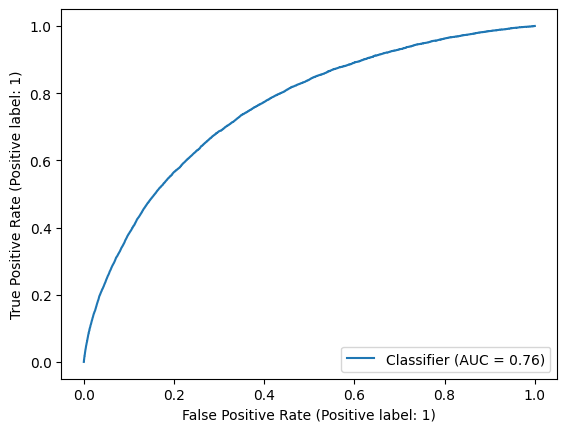

0.7574165124124494

In [6]:
# Test central MLP
from sklearn.metrics import RocCurveDisplay

y_pred = model(X_test).detach().numpy()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
test(model, X_test, y_test)

In [9]:
# Print 2 fold central MLP statistics
import statistics

aucs = [0.7398563647753225, 0.7394277571571156]
print(statistics.mean(aucs))
print(statistics.stdev(aucs))

0.7396420609662191
0.0003030713533022744


In [5]:
# Define MLP FL simulation wrapper
from fl_simu import mlp_simulation2

def run_simulation(split, dir='default', num_epoch=4, batch_size=128, num_rounds=5, dropout=True, dropout_rate=0.5):
    return mlp_simulation2(split, X_train, y_train, X_test, y_test, dir, num_epoch=4, batch_size=128, num_rounds=5, dropout=True, dropout_rate=0.5)

4 Epoch 0.2 Dropout

In [11]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-23 02:50:02,176 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-06-23 02:50:05,951	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-06-23 02:50:06,568 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8175910912.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-06-23 02:50:06,568 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-23 02:50:06,569 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-23 02:50:07,737 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-23 02:50:07,740 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-23 02:50:07,742 | server.py:101 | FL starting
DEBUG flwr 2023-06-23 02:50:07,743 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-23 02:50:27,458 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-23 02:50:27,460 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-23 02:50:27,461 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:50:41,521 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:50:41,540 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-23 02:50:45,352 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:50:45,354 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:50:59,028 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:50:59,047 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-23 02:51:03,221 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:51:03,223 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:51:16,680 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:51:16,699 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-23 02:51:20,428 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:51:20,430 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:51:33,941 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:51:33,958 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-23 02:51:38,040 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
INFO flwr 2023-06-23 02:51:38,041 | server.py:147 | FL finished in 90.29763166699558
INFO flwr 2023-06-23 02:51:38,042 | app.py:218 | app_fit: losses_distributed [(1, 0.069825679063797), (2, 0.06926320865750313), (3, 0.06900379434227943), (4, 0.06901085749268532), (5, 0.06897315755486488)]
INFO flwr 2023-06-23 02:51:38,042 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-23 02:51:38,042 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-23 02:51:38,043 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-06-23 02:51:38,043 | app.py:222 | app_fit: metrics_centralized {}


0.7451591197100811


In [12]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-14 07:44:51,677 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=2478) Client 1 evaluate, loss 0.07039797306060791, len 153756


2023-06-14 07:44:56,167	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-14 07:44:56,703 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8757624832.0, 'CPU': 8.0}
INFO flwr 2023-06-14 07:44:56,703 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-14 07:44:56,704 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-14 07:44:57,762 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-14 07:44:57,763 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-14 07:44:57,763 | server.py:101 | FL starting
DEBUG flwr 2023-06-14 07:44:57,763 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2659) Epoch: 1, Loss: 0.06805658340454102
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.11507796496152878
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.05899231508374214
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.00910655315965414
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.006573755759745836
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.09637828916311264
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.08228591829538345


DEBUG flwr 2023-06-14 07:45:20,972 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 07:45:20,978 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 07:45:20,991 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.16493810713291168


DEBUG flwr 2023-06-14 07:45:26,096 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 07:45:26,098 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 07:45:26,098 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2657) Client 1 evaluate, loss 0.06933504343032837, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.1045696958899498


(raylet) [2023-06-14 07:45:27,196 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24631508992; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 2, Loss: 0.10334406793117523
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.0019730653148144484
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.16386784613132477
(launch_and_evaluate pid=2659) Epoch: 1, Loss: 0.07626316696405411
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.08877816051244736 [repeated 2x across cluster]


(raylet) [2023-06-14 07:45:37,233 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24631619584; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 3, Loss: 0.010767410509288311


(raylet) [2023-06-14 07:45:47,271 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24631599104; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:45:47,725 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:45:47,743 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.010909301228821278


DEBUG flwr 2023-06-14 07:45:52,310 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:45:52,312 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2657) Client 0 evaluate, loss 0.06906972825527191, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.13308769464492798
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.049146320670843124
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.12407635897397995
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.012492724694311619


(raylet) [2023-06-14 07:45:57,297 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24610476032; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2659) Epoch: 1, Loss: 0.14319638907909393
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.09059662371873856 [repeated 2x across cluster]


(raylet) [2023-06-14 07:46:07,338 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24610643968; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:46:13,061 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:46:13,080 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2657) Epoch: 4, Loss: 0.009460645727813244 [repeated 2x across cluster]
Saving round 3 aggregated_parameters...


(raylet) [2023-06-14 07:46:17,373 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24610316288; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:46:17,500 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:46:17,501 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2657) Client 0 evaluate, loss 0.06879463791847229, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.014941057190299034
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.03641917556524277
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.10323846340179443
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.003318003611639142
(launch_and_evaluate pid=2659) Epoch: 1, Loss: 0.13089460134506226


(raylet) [2023-06-14 07:46:27,401 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24607223808; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 2, Loss: 0.1419837325811386 [repeated 2x across cluster]
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.08061825484037399


(raylet) [2023-06-14 07:46:37,498 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24606957568; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:46:39,412 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:46:39,430 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.04539959132671356


DEBUG flwr 2023-06-14 07:46:44,815 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:46:44,817 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.06884890049695969, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.05509011074900627
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.013721173629164696
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.15187270939350128
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.13319770991802216


(raylet) [2023-06-14 07:46:47,580 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24606752768; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.12269128113985062
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.12269128113985062
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.023898417130112648


(raylet) [2023-06-14 07:46:57,664 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24602804224; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 3, Loss: 0.14411675930023193


DEBUG flwr 2023-06-14 07:47:07,705 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:47:07,731 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.0027460891287773848


(raylet) [2023-06-14 07:47:12,522 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24602275840; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:47:13,348 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:47:13,349 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.06878376007080078, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.06444910913705826
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.11984769999980927
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.002875756472349167
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.0038799403700977564
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.09037160873413086
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.09037160873413086


(raylet) [2023-06-14 07:47:22,607 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589918208; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 2, Loss: 0.012145024724304676
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.15200179815292358


(raylet) [2023-06-14 07:47:32,706 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24588394496; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:47:36,157 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:47:36,177 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.0794592872262001


DEBUG flwr 2023-06-14 07:47:42,012 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:47:42,014 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.06878072768449783, len 153756


(raylet) [2023-06-14 07:47:42,719 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24592142336; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 1, Loss: 0.020346341654658318
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.0726870521903038
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.06923384964466095
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.026552971452474594
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.007683234754949808
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.08497848361730576 [repeated 2x across cluster]


(raylet) [2023-06-14 07:47:52,810 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24592179200; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 3, Loss: 0.1371631771326065


DEBUG flwr 2023-06-14 07:48:02,746 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:48:02,766 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
(raylet) [2023-06-14 07:48:02,895 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24590565376; capacity: 494384795648. Object creation will fail if spilling is required.


Saving round 7 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.05778626725077629


DEBUG flwr 2023-06-14 07:48:07,269 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:48:07,271 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 1 evaluate, loss 0.06892836838960648, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.05272991955280304
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.04590318724513054
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.006800112314522266
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.0888952910900116


(raylet) [2023-06-14 07:48:12,972 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24590495744; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.005972154904156923
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.006777070462703705 [repeated 2x across cluster]


(raylet) [2023-06-14 07:48:23,058 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24590475264; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 3, Loss: 0.1070515513420105


DEBUG flwr 2023-06-14 07:48:29,117 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:48:29,136 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.005845353007316589


(raylet) [2023-06-14 07:48:33,147 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24590233600; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:48:33,887 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:48:33,888 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.06909757852554321, len 153756
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.06162607669830322
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.16190503537654877
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.10265636444091797
(launch_and_fit pid=2657) 
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.12743577361106873
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.011845763772726059


(raylet) [2023-06-14 07:48:43,232 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24590217216; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 2, Loss: 0.12521927058696747 [repeated 2x across cluster]
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.010180113837122917


(raylet) [2023-06-14 07:48:53,321 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24590184448; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:48:55,022 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:48:55,041 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.010212250053882599


DEBUG flwr 2023-06-14 07:49:00,007 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:49:00,011 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.06940644234418869, len 153756
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.06309786438941956
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.0036496934480965137
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.06686123460531235
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.09279061108827591


(raylet) [2023-06-14 07:49:03,409 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589729792; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.005841126199811697
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.0029468529392033815 [repeated 2x across cluster]


(raylet) [2023-06-14 07:49:13,497 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589733888; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 3, Loss: 0.21426691114902496


DEBUG flwr 2023-06-14 07:49:20,832 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:49:20,861 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.056467071175575256


(raylet) [2023-06-14 07:49:23,587 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589451264; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:49:25,747 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:49:25,749 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.069936603307724, len 153756
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.0063833207823336124
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.06545267254114151
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.05704308673739433
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.054116878658533096
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.06371065229177475


(raylet) [2023-06-14 07:49:33,672 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589275136; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 2, Loss: 0.073160819709301 [repeated 2x across cluster]
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.07888980954885483


(raylet) [2023-06-14 07:49:43,753 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589340672; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:49:46,697 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:49:46,714 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2659) Epoch: 4, Loss: 0.012354052625596523
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-14 07:49:52,018 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:49:52,020 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2657) Client 0 evaluate, loss 0.06955397129058838, len 153756
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.05997101217508316
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.04889512434601784


(raylet) [2023-06-14 07:49:53,838 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589148160; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 3, Loss: 0.13457970321178436
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.011980838142335415
(launch_and_evaluate pid=2659) Epoch: 1, Loss: 0.006767780054360628
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.17266523838043213 [repeated 2x across cluster]


(raylet) [2023-06-14 07:50:03,923 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24589000704; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 3, Loss: 0.1005932167172432


DEBUG flwr 2023-06-14 07:50:13,205 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:50:13,230 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2659) Epoch: 4, Loss: 0.07003994286060333
Saving round 12 aggregated_parameters...


(raylet) [2023-06-14 07:50:14,008 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24588677120; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:50:17,749 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:50:17,750 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.0699082538485527, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.05084838345646858
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.07021713256835938
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.08868782967329025
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.08278995007276535
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.13708919286727905


(raylet) [2023-06-14 07:50:24,088 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24588652544; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 2, Loss: 0.04972871020436287 [repeated 2x across cluster]
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.0880395844578743


(raylet) [2023-06-14 07:50:34,178 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24586711040; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:50:38,931 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:50:38,954 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.0011493732454255223


(raylet) [2023-06-14 07:50:44,272 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24586973184; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:50:44,368 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:50:44,369 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 1 evaluate, loss 0.07020855695009232, len 153756
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.0053375279530882835
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.05836932361125946
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.11129412800073624
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.04768191650509834
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.14231880009174347


(raylet) [2023-06-14 07:50:54,352 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24587010048; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 2, Loss: 0.07138507813215256 [repeated 2x across cluster]


(raylet) [2023-06-14 07:51:04,438 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24586784768; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:51:05,037 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:51:05,058 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.16034571826457977 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 07:51:09,528 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:51:09,530 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.07055959105491638, len 153756
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.03194223344326019
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.03783953934907913
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.1261984258890152
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.07142958790063858


(raylet) [2023-06-14 07:51:14,523 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585699328; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.022185729816555977
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.010053287260234356 [repeated 2x across cluster]


(raylet) [2023-06-14 07:51:24,607 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585674752; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 3, Loss: 0.11378327757120132


DEBUG flwr 2023-06-14 07:51:30,393 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:51:30,412 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.15285606682300568


(raylet) [2023-06-14 07:51:34,688 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585068544; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:51:34,911 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:51:34,912 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.07074405997991562, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.1501915454864502
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.20755690336227417
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.12053832411766052
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.12869282066822052
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.005482656881213188


(raylet) [2023-06-14 07:51:44,784 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585080832; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 2, Loss: 0.08064117282629013 [repeated 2x across cluster]
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.08067034184932709


(raylet) [2023-06-14 07:51:54,867 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585076736; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:51:55,363 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:51:55,384 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2657) Epoch: 4, Loss: 0.024246729910373688
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-14 07:51:59,663 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:51:59,664 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2657) Client 0 evaluate, loss 0.07109911739826202, len 153756
(launch_and_fit pid=2657) Epoch: 1, Loss: 0.06475906074047089
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.10488543659448624
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.0716424509882927
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.06112348660826683
(launch_and_evaluate pid=2659) Epoch: 1, Loss: 0.05564581975340843


(raylet) [2023-06-14 07:52:04,953 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24583073792; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 2, Loss: 0.08823058009147644 [repeated 2x across cluster]


(raylet) [2023-06-14 07:52:15,042 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24583061504; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:52:19,487 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:52:19,506 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.15516503155231476 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 07:52:24,581 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:52:24,583 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 1 evaluate, loss 0.07106226682662964, len 153756


(raylet) [2023-06-14 07:52:25,135 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24586567680; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2659) Epoch: 1, Loss: 0.01223498024046421
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.015111214481294155
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.014734226278960705
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.008436792530119419
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.010804726742208004


(raylet) [2023-06-14 07:52:35,229 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585887744; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 2, Loss: 0.050459492951631546 [repeated 2x across cluster]
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.07486559450626373


(raylet) [2023-06-14 07:52:45,320 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585887744; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:52:46,074 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:52:46,093 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=2657) Epoch: 4, Loss: 0.02265920676290989
Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-14 07:52:50,763 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:52:50,766 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 0 evaluate, loss 0.07098119705915451, len 153756
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.1695503443479538
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.07328078895807266
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.00597427599132061
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.0046127489767968655


(raylet) [2023-06-14 07:52:55,344 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585531392; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.023303909227252007
(launch_and_fit pid=2657) Epoch: 2, Loss: 0.005284552928060293 [repeated 2x across cluster]


(raylet) [2023-06-14 07:53:05,436 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585453568; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 3, Loss: 0.004656170029193163


DEBUG flwr 2023-06-14 07:53:12,272 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:53:12,291 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.08110011368989944


(raylet) [2023-06-14 07:53:15,524 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585379840; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:53:17,448 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:53:17,449 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=2659) Client 1 evaluate, loss 0.07150878757238388, len 153756
(launch_and_evaluate pid=2659) 
(launch_and_fit pid=2659) Epoch: 1, Loss: 0.03644396364688873
(launch_and_fit pid=2659) Epoch: 2, Loss: 0.11270543187856674
(launch_and_fit pid=2659) Epoch: 3, Loss: 0.1279904544353485
(launch_and_fit pid=2659) Epoch: 4, Loss: 0.03689691051840782
(launch_and_evaluate pid=2657) Epoch: 1, Loss: 0.002972995163872838


(raylet) [2023-06-14 07:53:25,617 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24585334784; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2657) Epoch: 2, Loss: 0.030210478231310844 [repeated 2x across cluster]
(launch_and_fit pid=2657) Epoch: 3, Loss: 0.07869106531143188


(raylet) [2023-06-14 07:53:35,707 E 2652 11236311] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-44-54_341550_2451 is over 95% full, available space: 24584966144; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:53:37,933 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:53:37,951 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=2657) Epoch: 4, Loss: 0.1427624523639679


DEBUG flwr 2023-06-14 07:53:42,716 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-14 07:53:42,718 | server.py:147 | FL finished in 524.9587069170084
INFO flwr 2023-06-14 07:53:42,720 | app.py:218 | app_fit: losses_distributed [(1, 0.069411750882864), (2, 0.06909114122390747), (3, 0.06883856281638145), (4, 0.06878550723195076), (5, 0.06875526905059814), (6, 0.06880570575594902), (7, 0.06893519312143326), (8, 0.06908910349011421), (9, 0.06937996298074722), (10, 0.06988335773348808), (11, 0.06967715173959732), (12, 0.06995679810643196), (13, 0.0702090710401535), (14, 0.07050101459026337), (15, 0.07089631259441376), (16, 0.0711970254778862), (17, 0.07102234289050102), (18, 0.07095921039581299), (19, 0.07155532017350197), (20, 0.07138032838702202)]
INFO flwr 2023-06-14 07:53:42,720 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-14 07:53:42,720 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-14 07:53:42,720 | app

Loading pre-trained model from:  ./model_checkpoints2/split_90_10/model_round_20.pth
(launch_and_evaluate pid=2659) Client 1 evaluate, loss 0.07138560712337494, len 153756
0.7410748223880967


In [13]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-14 07:53:44,753 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=2657) Client 0 evaluate, loss 0.0713750496506691, len 153756


2023-06-14 07:53:48,944	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-14 07:53:49,580 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8425863578.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-14 07:53:49,580 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-14 07:53:49,580 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-14 07:53:50,723 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-14 07:53:50,723 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-14 07:53:50,723 | server.py:101 | FL starting
DEBUG flwr 2023-06-14 07:53:50,724 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=2937) Epoch: 1, Loss: 0.07195715606212616
(launch_and_fit pid=2937) Epoch: 3, Loss: 0.05214298889040947 [repeated 5x across cluster]


DEBUG flwr 2023-06-14 07:54:01,410 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 07:54:01,419 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 07:54:01,429 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-14 07:54:07,211 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 07:54:07,212 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 07:54:07,213 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2932) Client 2 evaluate, loss 0.06988120079040527, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.08312317728996277 [repeated 2x across cluster]
(launch_and_evaluate pid=2937) Epoch: 2, Loss: 0.12730655074119568
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.12730655074119568 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:54:17,730 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:54:17,751 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.0911187082529068 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:54:22,902 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:54:22,904 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 0 evaluate, loss 0.06939265877008438, len 153756
(launch_and_fit pid=2932) Epoch: 1, Loss: 0.07131628692150116


(raylet) [2023-06-14 07:54:27,067 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24563879936; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2932) Epoch: 3, Loss: 0.07473134249448776


DEBUG flwr 2023-06-14 07:54:31,017 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:54:31,038 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=2932) Epoch: 4, Loss: 0.07445104420185089 [repeated 6x across cluster]
Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-14 07:54:36,089 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:54:36,091 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2932) Client 0 evaluate, loss 0.06913119554519653, len 153756
(launch_and_fit pid=2937) Client 0 evaluate, loss 0.06913119554519653, len 153756


(raylet) [2023-06-14 07:54:37,152 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24453828608; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2937) Epoch: 1, Loss: 0.09986894577741623
(launch_and_evaluate pid=2937) Epoch: 2, Loss: 0.0509149432182312
(launch_and_fit pid=2932) Epoch: 3, Loss: 0.050244346261024475 [repeated 5x across cluster]


DEBUG flwr 2023-06-14 07:54:46,252 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:54:46,270 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


(raylet) [2023-06-14 07:54:47,233 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24453627904; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:54:50,855 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:54:50,857 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2932) Client 1 evaluate, loss 0.0689476877450943, len 153756
(launch_and_fit pid=2932) Epoch: 4, Loss: 0.04830227047204971 [repeated 2x across cluster]
(launch_and_evaluate pid=2937) Epoch: 3, Loss: 0.06935664266347885
(launch_and_fit pid=2932) Epoch: 3, Loss: 0.06935664266347885 [repeated 5x across cluster]


(raylet) [2023-06-14 07:54:57,316 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24452902912; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:54:58,981 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:54:59,003 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-14 07:55:03,496 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:03,498 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 2 evaluate, loss 0.06904295086860657, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.0818476602435112 [repeated 3x across cluster]


(raylet) [2023-06-14 07:55:07,402 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24452796416; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.05948391929268837
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.05948391929268837 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:55:13,870 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:13,888 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


(raylet) [2023-06-14 07:55:17,488 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24452472832; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:55:18,941 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:18,942 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 1 evaluate, loss 0.06890874356031418, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.052351854741573334 [repeated 4x across cluster]
(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.0450882762670517
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.0450882762670517 [repeated 4x across cluster]


(raylet) [2023-06-14 07:55:27,574 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23378382848; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:55:29,393 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:29,413 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.10299862921237946 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:55:34,243 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:34,245 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 0 evaluate, loss 0.06878809630870819, len 153756
(launch_and_fit pid=2937) Epoch: 1, Loss: 0.0968225747346878
(launch_and_fit pid=2932) Epoch: 1, Loss: 0.07219882309436798


(raylet) [2023-06-14 07:55:37,654 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23383281664; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2932) Epoch: 2, Loss: 0.14304620027542114
(launch_and_evaluate pid=2932) Epoch: 3, Loss: 0.05669853463768959


DEBUG flwr 2023-06-14 07:55:42,173 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:42,190 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=2932) Epoch: 4, Loss: 0.05798432603478432 [repeated 4x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-14 07:55:46,367 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:46,369 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 1 evaluate, loss 0.06884373724460602, len 153756


(raylet) [2023-06-14 07:55:47,741 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23382822912; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2932) Epoch: 1, Loss: 0.07705938071012497 [repeated 2x across cluster]
(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.0581490583717823
(launch_and_fit pid=2937) Epoch: 3, Loss: 0.08376255631446838 [repeated 5x across cluster]


DEBUG flwr 2023-06-14 07:55:56,538 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:55:56,557 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


(raylet) [2023-06-14 07:55:57,842 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23382503424; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:56:00,711 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:00,712 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2932) Client 0 evaluate, loss 0.06883532553911209, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.10548502951860428 [repeated 2x across cluster]
(launch_and_evaluate pid=2937) Epoch: 2, Loss: 0.08696842938661575
(launch_and_fit pid=2932) Epoch: 2, Loss: 0.08696842938661575 [repeated 4x across cluster]


(raylet) [2023-06-14 07:56:07,926 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23382478848; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:56:11,020 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:11,039 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-14 07:56:15,786 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:15,788 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 0 evaluate, loss 0.06876710802316666, len 153756
(launch_and_fit pid=2932) Epoch: 4, Loss: 0.0778169110417366 [repeated 4x across cluster]


(raylet) [2023-06-14 07:56:18,010 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23382339584; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.05908110737800598
(launch_and_fit pid=2932) Epoch: 2, Loss: 0.05908110737800598 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:56:25,747 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:25,768 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


(raylet) [2023-06-14 07:56:28,090 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23382233088; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:56:30,280 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:30,281 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 2 evaluate, loss 0.06887577474117279, len 153756
(launch_and_fit pid=2932) Epoch: 4, Loss: 0.06535647809505463 [repeated 4x across cluster]
(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.05876742675900459
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.05876742675900459 [repeated 4x across cluster]


(raylet) [2023-06-14 07:56:38,187 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23382175744; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:56:40,832 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:40,854 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.044359005987644196 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:56:45,515 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:45,518 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 2 evaluate, loss 0.0690007284283638, len 153756
(launch_and_fit pid=2932) Epoch: 1, Loss: 0.11557997763156891


(raylet) [2023-06-14 07:56:48,272 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23381377024; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2937) Epoch: 1, Loss: 0.052309345453977585
(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.053935371339321136
(launch_and_fit pid=2932) Epoch: 4, Loss: 0.027868183329701424 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:56:56,045 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:56:56,063 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


(raylet) [2023-06-14 07:56:58,359 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23379890176; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:57:00,468 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:00,471 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 2 evaluate, loss 0.06885680556297302, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.044078703969717026 [repeated 2x across cluster]
(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.1023392304778099
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.1023392304778099 [repeated 4x across cluster]


(raylet) [2023-06-14 07:57:08,445 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23379886080; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:57:10,669 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:10,686 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-14 07:57:15,140 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:15,141 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2932) Client 0 evaluate, loss 0.06899266690015793, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.039729971438646317 [repeated 4x across cluster]


(raylet) [2023-06-14 07:57:18,536 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 23378231296; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2937) Epoch: 2, Loss: 0.07457266747951508
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.07457266747951508 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:57:25,907 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:25,927 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.08196910470724106 [repeated 4x across cluster]


(raylet) [2023-06-14 07:57:28,621 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24451407872; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:57:30,762 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:30,764 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 2 evaluate, loss 0.06927814334630966, len 153756
(launch_and_fit pid=2932) Epoch: 1, Loss: 0.010076576843857765
(launch_and_fit pid=2937) Epoch: 1, Loss: 0.0692705512046814
(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.05100667476654053


(raylet) [2023-06-14 07:57:38,626 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24451375104; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=2937) Epoch: 3, Loss: 0.08872608840465546 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:57:41,781 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:41,800 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-14 07:57:46,067 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:46,068 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 0 evaluate, loss 0.0692322850227356, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.13984248042106628 [repeated 2x across cluster]


(raylet) [2023-06-14 07:57:48,710 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24450293760; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.09890300035476685
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.09890300035476685 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:57:56,406 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:57:56,425 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


(raylet) [2023-06-14 07:57:58,793 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24451862528; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:58:01,547 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:58:01,549 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2932) Client 2 evaluate, loss 0.06940818578004837, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.02292228303849697 [repeated 4x across cluster]
(launch_and_evaluate pid=2937) Epoch: 2, Loss: 0.018513256683945656
(launch_and_fit pid=2937) Epoch: 2, Loss: 0.018513256683945656 [repeated 4x across cluster]


(raylet) [2023-06-14 07:58:08,877 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24450011136; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:58:11,465 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:58:11,483 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-14 07:58:15,572 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:58:15,573 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 1 evaluate, loss 0.06936591863632202, len 153756
(launch_and_fit pid=2937) Epoch: 4, Loss: 0.031051136553287506 [repeated 4x across cluster]


(raylet) [2023-06-14 07:58:18,891 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24448876544; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=2932) Epoch: 2, Loss: 0.07062683254480362
(launch_and_fit pid=2932) Epoch: 2, Loss: 0.07062683254480362 [repeated 4x across cluster]


DEBUG flwr 2023-06-14 07:58:25,817 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:58:25,837 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


(raylet) [2023-06-14 07:58:28,978 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24448356352; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:58:30,675 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:58:30,676 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=2937) Client 1 evaluate, loss 0.06973986327648163, len 153756
(launch_and_fit pid=2932) Epoch: 4, Loss: 0.04245608299970627 [repeated 4x across cluster]
(launch_and_evaluate pid=2932) Epoch: 3, Loss: 0.03417665511369705
(launch_and_fit pid=2937) Epoch: 3, Loss: 0.03417665511369705 [repeated 5x across cluster]


DEBUG flwr 2023-06-14 07:58:38,605 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:58:38,621 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


(raylet) [2023-06-14 07:58:39,061 E 2929 11244060] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-53-47_142432_2451 is over 95% full, available space: 24447754240; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:58:43,233 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-14 07:58:43,235 | server.py:147 | FL finished in 292.5131818749942
INFO flwr 2023-06-14 07:58:43,235 | app.py:218 | app_fit: losses_distributed [(1, 0.06993360444903374), (2, 0.06939688697457314), (3, 0.06917065754532814), (4, 0.06900012493133545), (5, 0.06897402554750443), (6, 0.06893425062298775), (7, 0.06880159303545952), (8, 0.06881684064865112), (9, 0.06879055872559547), (10, 0.06882190704345703), (11, 0.06887112185359001), (12, 0.06899531930685043), (13, 0.06889467686414719), (14, 0.0690690204501152), (15, 0.06932030245661736), (16, 0.06924321874976158), (17, 0.0693553239107132), (18, 0.06938090175390244

(launch_and_evaluate pid=2937) Client 0 evaluate, loss 0.0694158673286438, len 153756
(launch_and_fit pid=2932) Epoch: 4, Loss: 0.036722466349601746 [repeated 3x across cluster]
Loading pre-trained model from:  ./model_checkpoints2/split_40_30_30/model_round_20.pth
0.7475125574322024


In [14]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-14 07:58:45,300 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=2932) Client 1 evaluate, loss 0.06930474191904068, len 153756


2023-06-14 07:58:49,074	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-14 07:58:49,696 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 8760868864.0}
INFO flwr 2023-06-14 07:58:49,697 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-14 07:58:49,697 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-14 07:58:50,813 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-14 07:58:50,814 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-14 07:58:50,814 | server.py:101 | FL starting
DEBUG flwr 2023-06-14 07:58:50,814 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=3077) Epoch: 1, Loss: 0.12001850455999374
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.005249178037047386
(launch_and_fit pid=3077) Epoch: 3, Loss: 0.061588115990161896
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.07080710679292679
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.033926479518413544 [repeated 2x across cluster]
(launch_and_fit pid=3073) Epoch: 3, Loss: 0.07574980705976486


DEBUG flwr 2023-06-14 07:59:11,279 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 07:59:11,286 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 07:59:11,295 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.05911848321557045


DEBUG flwr 2023-06-14 07:59:16,844 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 07:59:16,846 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 07:59:16,846 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.06967368721961975, len 153756
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.14382560551166534
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.013422643765807152
(launch_and_fit pid=3073) Epoch: 3, Loss: 0.0539872869849205
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.05934533104300499
(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.041591495275497437
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.04310368001461029 [repeated 2x across cluster]


(raylet) [2023-06-14 07:59:27,112 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24709050368; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:59:36,643 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:59:36,661 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.09908884018659592 [repeated 2x across cluster]


(raylet) [2023-06-14 07:59:37,176 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24447221760; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:59:41,680 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:59:41,682 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.06900407373905182, len 153756
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.04238127917051315


DEBUG flwr 2023-06-14 07:59:44,584 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:59:44,600 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


(raylet) [2023-06-14 07:59:47,207 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24446631936; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 07:59:49,248 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 07:59:49,250 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.06909413635730743, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.1788642853498459 [repeated 7x across cluster]
(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.043896064162254333
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.043896064162254333 [repeated 5x across cluster]


(raylet) [2023-06-14 07:59:57,235 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24446533632; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3077) Epoch: 3, Loss: 0.07305588573217392 [repeated 2x across cluster]


(raylet) [2023-06-14 08:00:07,269 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445984768; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:00:09,018 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:00:09,036 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-14 08:00:13,799 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:00:13,801 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.06886553764343262, len 153756
(launch_and_fit pid=3077) Client 1 evaluate, loss 0.06886553764343262, len 153756
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.054781440645456314
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.05402606725692749
(launch_and_fit pid=3077) Epoch: 3, Loss: 0.1488342434167862
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.005792725365608931


(raylet) [2023-06-14 08:00:17,314 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445493248; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.05593299865722656
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.07025513052940369 [repeated 2x across cluster]


(raylet) [2023-06-14 08:00:27,358 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445464576; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:00:33,326 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:00:33,348 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.04116852581501007 [repeated 2x across cluster]


(raylet) [2023-06-14 08:00:37,401 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445341696; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:00:38,217 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:00:38,218 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 2 evaluate, loss 0.06880712509155273, len 153756
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.005614721216261387
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.07350017130374908


DEBUG flwr 2023-06-14 08:00:40,981 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:00:40,996 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-14 08:00:44,771 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:00:44,772 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.06882257014513016, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.06056726723909378 [repeated 6x across cluster]


(raylet) [2023-06-14 08:00:47,430 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445169664; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.06860191375017166
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.06860191375017166 [repeated 5x across cluster]


(raylet) [2023-06-14 08:00:57,464 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445140992; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3073) Epoch: 3, Loss: 0.06903870403766632 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:01:04,171 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:01:04,191 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


(raylet) [2023-06-14 08:01:07,502 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24444538880; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:01:08,754 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:01:08,754 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.06881745904684067, len 153756
(launch_and_fit pid=3073) Client 1 evaluate, loss 0.06881745904684067, len 153756
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.11369068175554276
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.01742585562169552
(launch_and_fit pid=3077) Epoch: 3, Loss: 0.008301987312734127
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.05060061067342758
(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.06728536635637283


(raylet) [2023-06-14 08:01:17,547 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24444518400; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3073) Epoch: 2, Loss: 0.0527614988386631 [repeated 2x across cluster]


(raylet) [2023-06-14 08:01:27,582 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24444366848; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:01:28,170 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:01:28,192 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.05598302558064461 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:01:33,193 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:01:33,194 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.06889373064041138, len 153756
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.02799966372549534
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.05792458355426788
(launch_and_fit pid=3077) Epoch: 3, Loss: 0.06322585791349411
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.15272261202335358


(raylet) [2023-06-14 08:01:37,622 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24459378688; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.04415297880768776
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.07875534147024155 [repeated 2x across cluster]


(raylet) [2023-06-14 08:01:47,707 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445140992; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:01:53,305 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:01:53,324 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=3073) Epoch: 4, Loss: 0.058910153806209564 [repeated 2x across cluster]
Saving round 9 aggregated_parameters...


(raylet) [2023-06-14 08:01:57,793 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24441401344; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:01:58,565 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:01:58,566 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.06909715384244919, len 153756
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.0032412847504019737


DEBUG flwr 2023-06-14 08:02:01,464 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:02:01,478 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-14 08:02:06,106 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:02:06,108 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.06875886768102646, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.15730682015419006 [repeated 7x across cluster]


(raylet) [2023-06-14 08:02:07,873 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24440610816; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.04459073022007942
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.04459073022007942 [repeated 5x across cluster]


(raylet) [2023-06-14 08:02:17,962 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24443187200; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3077) Epoch: 3, Loss: 0.09443286061286926 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:02:24,782 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:02:24,802 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


(raylet) [2023-06-14 08:02:28,050 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24449294336; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:02:29,690 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:02:29,691 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 2 evaluate, loss 0.06913198530673981, len 153756
(launch_and_fit pid=3077) Client 2 evaluate, loss 0.06913198530673981, len 153756
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.00997527502477169
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.008048140443861485
(launch_and_fit pid=3073) Epoch: 3, Loss: 0.20326489210128784
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.05505608394742012
(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.0827566608786583


(raylet) [2023-06-14 08:02:38,052 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24449343488; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3077) Epoch: 2, Loss: 0.07186295837163925 [repeated 2x across cluster]


(raylet) [2023-06-14 08:02:48,149 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24449318912; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:02:49,254 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:02:49,274 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.05325938016176224 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:02:54,024 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:02:54,025 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.06919260323047638, len 153756
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.00600801594555378
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.04319051653146744
(launch_and_fit pid=3077) Epoch: 3, Loss: 0.06559781730175018
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.06246378645300865


(raylet) [2023-06-14 08:02:58,227 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24447037440; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.07343820482492447
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.058182910084724426 [repeated 2x across cluster]


(raylet) [2023-06-14 08:03:08,308 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24446967808; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:03:13,053 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:03:13,071 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.06055564433336258 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:03:17,808 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:03:17,809 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.06936846673488617, len 153756


(raylet) [2023-06-14 08:03:18,388 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445837312; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3073) Epoch: 1, Loss: 0.16693642735481262
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.03512916713953018
(launch_and_fit pid=3073) Epoch: 3, Loss: 0.08818122744560242
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.02340630814433098
(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.05655553191900253
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.05950677767395973 [repeated 2x across cluster]


(raylet) [2023-06-14 08:03:28,479 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445784064; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:03:36,664 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:03:36,686 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=3077) Epoch: 4, Loss: 0.06414590030908585 [repeated 2x across cluster]
Saving round 14 aggregated_parameters...


(raylet) [2023-06-14 08:03:38,564 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445181952; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:03:41,488 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:03:41,489 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.06971093267202377, len 153756
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.018902577459812164
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.06131690740585327
(launch_and_fit pid=3073) Epoch: 3, Loss: 0.04460874944925308
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.05314038321375847
(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.08399803936481476


(raylet) [2023-06-14 08:03:48,654 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24445173760; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3077) Epoch: 2, Loss: 0.056820616126060486 [repeated 2x across cluster]


(raylet) [2023-06-14 08:03:58,672 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24444641280; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:04:00,831 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:04:00,848 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.09097063541412354 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:04:05,692 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:04:05,693 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3077) Client 0 evaluate, loss 0.0699959546327591, len 153756
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.09521377831697464
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.005836622789502144
(launch_and_fit pid=3077) Epoch: 3, Loss: 0.0063087791204452515
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.050213523209095


(raylet) [2023-06-14 08:04:08,759 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24443924480; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3073) Epoch: 1, Loss: 0.029466703534126282
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.08692808449268341 [repeated 2x across cluster]


(raylet) [2023-06-14 08:04:18,847 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24443875328; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:04:24,757 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:04:24,794 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.06387665122747421 [repeated 2x across cluster]


(raylet) [2023-06-14 08:04:28,932 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24443564032; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:04:29,822 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:04:29,823 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.07011810690164566, len 153756
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.006768310442566872
(launch_and_fit pid=3073) Epoch: 2, Loss: 0.14821362495422363
(launch_and_fit pid=3073) Epoch: 3, Loss: 0.053893133997917175
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.08069411665201187
(launch_and_evaluate pid=3077) Epoch: 2, Loss: 0.04820406064391136
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.04820406064391136 [repeated 2x across cluster]


(raylet) [2023-06-14 08:04:38,957 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24443498496; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:04:47,822 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:04:47,841 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.08141534775495529 [repeated 2x across cluster]


(raylet) [2023-06-14 08:04:49,048 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24442519552; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:04:52,364 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:04:52,365 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 0 evaluate, loss 0.07028382271528244, len 153756
(launch_and_fit pid=3077) Epoch: 1, Loss: 0.08198048174381256
(launch_and_fit pid=3077) Epoch: 2, Loss: 0.28167977929115295
(launch_and_fit pid=3077) Epoch: 3, Loss: 0.1265672743320465
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.11607810109853745
(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.042930345982313156


(raylet) [2023-06-14 08:04:59,058 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24442134528; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3073) Epoch: 2, Loss: 0.07207825779914856 [repeated 2x across cluster]


(raylet) [2023-06-14 08:05:09,146 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24441843712; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:05:12,133 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:05:12,163 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=3073) Epoch: 4, Loss: 0.048884548246860504 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:05:17,914 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:05:17,915 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.07065124064683914, len 153756
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.05479966104030609


(raylet) [2023-06-14 08:05:19,229 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24442044416; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:05:20,854 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:05:20,870 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-14 08:05:25,371 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:05:25,372 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.06956282258033752, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3077) Epoch: 4, Loss: 0.10287312418222427 [repeated 7x across cluster]


(raylet) [2023-06-14 08:05:29,312 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24439341056; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3077) Epoch: 1, Loss: 0.06411871314048767
(launch_and_fit pid=3073) Epoch: 1, Loss: 0.06411871314048767 [repeated 5x across cluster]
(launch_and_fit pid=3073) Epoch: 3, Loss: 0.06749133765697479 [repeated 2x across cluster]


(raylet) [2023-06-14 08:05:39,400 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24439410688; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:05:43,912 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:05:43,932 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-14 08:05:48,346 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-14 08:05:48,348 | server.py:147 | FL finished in 417.5362798341084
INFO flwr 2023-06-14 08:05:48,349 | app.py:218 | app_fit: losses_distributed [(1, 0.06962995231151581), (2, 0.06908271089196205), (3, 0.0690796747803688), (4, 0.06888332217931747), (5, 0.06879755854606628), (6, 0.06881356239318848), (7, 0.06879523023962975), (8, 0.06892948597669601), (9, 0.06911129131913185), (10, 0.06879102811217308), (11, 0.06917458400130272), (12, 0.06929084658622742), (13, 0.06943859159946442), (14, 0.06963144242763519), (15, 0.07003649324178696), (16, 0.07014390453696251), (17, 0.07029323279857635), (18, 0.07070674747228622), (19, 0.0695631168782711), (20, 0.07077579200267792)]
INFO flwr 2023-06-14 08:05:48,349 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-14 08:05:48,349 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-14 08:05:48,349 | a

(launch_and_evaluate pid=3077) Client 0 evaluate, loss 0.07071555405855179, len 153756
(launch_and_fit pid=3073) Client 0 evaluate, loss 0.07071555405855179, len 153756
Loading pre-trained model from:  ./model_checkpoints2/split_80_10_10/model_round_20.pth


(raylet) [2023-06-14 08:05:49,488 E 3070 11249090] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_07-58-47_156984_2451 is over 95% full, available space: 24438603776; capacity: 494384795648. Object creation will fail if spilling is required.


0.7430488029745618


In [15]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-14 08:05:50,365 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=3073) Client 1 evaluate, loss 0.07083602994680405, len 153756


2023-06-14 08:05:54,394	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-14 08:05:54,936 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 8806255821.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-14 08:05:54,937 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-14 08:05:54,937 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-14 08:05:56,000 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-14 08:05:56,001 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-14 08:05:56,001 | server.py:101 | FL starting
DEBUG flwr 2023-06-14 08:05:56,001 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=3264) Epoch: 1, Loss: 0.03157816827297211


DEBUG flwr 2023-06-14 08:06:02,103 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 08:06:02,113 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 08:06:02,122 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-14 08:06:06,838 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 08:06:06,839 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 08:06:06,840 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 1 evaluate, loss 0.071015365421772, len 153756
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.07642702013254166 [repeated 7x across cluster]


DEBUG flwr 2023-06-14 08:06:12,092 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:12,108 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.05678485333919525
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.05678485333919525 [repeated 7x across cluster]
Saving round 2 aggregated_parameters...


(raylet) [2023-06-14 08:06:16,381 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24580120576; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:06:16,744 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:16,754 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 3 evaluate, loss 0.07005801796913147, len 153756
(launch_and_fit pid=3264) Epoch: 1, Loss: 0.055911269038915634 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:06:22,096 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:22,115 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.04270610213279724


DEBUG flwr 2023-06-14 08:06:26,289 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:26,290 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Client 2 evaluate, loss 0.06977400928735733, len 153756
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.1038198173046112 [repeated 7x across cluster]


(raylet) [2023-06-14 08:06:26,461 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 23657512960; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:06:31,668 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:31,685 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=3264) Epoch: 4, Loss: 0.07639816403388977
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.07639816403388977 [repeated 7x across cluster]


DEBUG flwr 2023-06-14 08:06:36,277 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:36,278 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Client 4 evaluate, loss 0.06951957195997238, len 153756


(raylet) [2023-06-14 08:06:36,547 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 23359504384; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3266) Epoch: 1, Loss: 0.02169107273221016 [repeated 2x across cluster]
(launch_and_evaluate pid=3264) Epoch: 4, Loss: 0.1153431162238121


DEBUG flwr 2023-06-14 08:06:41,670 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:41,687 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-14 08:06:45,816 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:45,817 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 3 evaluate, loss 0.06933875381946564, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.06839628517627716 [repeated 7x across cluster]


(raylet) [2023-06-14 08:06:46,630 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 23359356928; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:06:50,875 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:50,892 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.0435103215277195
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.0435103215277195 [repeated 8x across cluster]


DEBUG flwr 2023-06-14 08:06:55,453 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:06:55,455 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 1 evaluate, loss 0.06942319869995117, len 153756


(raylet) [2023-06-14 08:06:56,708 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 23359705088; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3264) Epoch: 1, Loss: 0.028861114755272865
(launch_and_fit pid=3266) Epoch: 1, Loss: 0.03270438686013222
(launch_and_fit pid=3266) Epoch: 2, Loss: 0.06149890646338463


DEBUG flwr 2023-06-14 08:07:00,675 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:00,693 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.09862076491117477
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-14 08:07:05,046 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:05,048 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 2 evaluate, loss 0.06918558478355408, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.052348699420690536 [repeated 5x across cluster]


(raylet) [2023-06-14 08:07:06,786 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 23356370944; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.05515587702393532
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.05515587702393532 [repeated 7x across cluster]


DEBUG flwr 2023-06-14 08:07:10,512 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:10,529 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-14 08:07:14,703 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:14,704 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 2 evaluate, loss 0.06922383606433868, len 153756
(launch_and_fit pid=3266) Epoch: 1, Loss: 0.09647656977176666 [repeated 2x across cluster]


(raylet) [2023-06-14 08:07:16,883 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 23359258624; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.007043525576591492


DEBUG flwr 2023-06-14 08:07:20,550 | server.py:232 | fit_round 9 received 2 results and 0 failures


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-14 08:07:21,077 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
(raylet) [2023-06-14 08:07:26,994 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24436289536; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:07:27,245 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:27,246 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 4 evaluate, loss 0.06900043785572052, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.06278025358915329 [repeated 7x across cluster]
(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.005888016428798437
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.005888016428798437 [repeated 7x across cluster]


DEBUG flwr 2023-06-14 08:07:33,176 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:33,191 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


(raylet) [2023-06-14 08:07:37,087 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24435384320; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:07:40,463 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:40,465 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 0 evaluate, loss 0.06896878033876419, len 153756
(launch_and_fit pid=3264) Client 0 evaluate, loss 0.06896878033876419, len 153756
(launch_and_fit pid=3266) Epoch: 1, Loss: 0.0366763174533844
(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.08634516596794128


DEBUG flwr 2023-06-14 08:07:46,249 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:46,273 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


(raylet) [2023-06-14 08:07:47,108 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24434798592; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:07:50,657 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:50,659 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 0 evaluate, loss 0.06900503486394882, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.09643028676509857 [repeated 7x across cluster]
(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.035430096089839935
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.035430096089839935 [repeated 7x across cluster]


DEBUG flwr 2023-06-14 08:07:56,581 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:07:56,600 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


(raylet) [2023-06-14 08:07:57,137 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24434720768; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:08:02,088 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:02,092 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 1 evaluate, loss 0.06898965686559677, len 153756
(launch_and_fit pid=3264) Client 1 evaluate, loss 0.06898965686559677, len 153756
(launch_and_fit pid=3266) Epoch: 1, Loss: 0.033065084367990494


(raylet) [2023-06-14 08:08:07,231 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24432758784; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:08:07,331 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:07,348 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.015619263984262943
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-14 08:08:12,284 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:12,286 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 3 evaluate, loss 0.06891562789678574, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.015619263984262943 [repeated 7x across cluster]


(raylet) [2023-06-14 08:08:17,317 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24430280704; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.08011958003044128
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.08011958003044128 [repeated 7x across cluster]


DEBUG flwr 2023-06-14 08:08:17,718 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:17,738 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-14 08:08:22,626 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:22,628 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 4 evaluate, loss 0.06909281015396118, len 153756
(launch_and_fit pid=3264) Client 4 evaluate, loss 0.06909281015396118, len 153756
(launch_and_fit pid=3266) Epoch: 1, Loss: 0.03413594886660576


(raylet) [2023-06-14 08:08:27,403 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24429047808; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.0723365992307663


DEBUG flwr 2023-06-14 08:08:28,161 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:28,212 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-14 08:08:32,876 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:32,878 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Client 0 evaluate, loss 0.06919440627098083, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.11214716732501984 [repeated 7x across cluster]


(raylet) [2023-06-14 08:08:37,409 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24428040192; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:08:38,181 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:38,208 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Epoch: 4, Loss: 0.08617214113473892
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.08617214113473892 [repeated 7x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-14 08:08:42,573 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:42,577 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 0 evaluate, loss 0.06913461536169052, len 153756
(launch_and_fit pid=3264) Epoch: 1, Loss: 0.12548772990703583 [repeated 2x across cluster]


(raylet) [2023-06-14 08:08:47,493 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24427384832; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:08:47,837 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:47,875 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.07635568082332611
Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-14 08:08:52,650 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:52,652 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 1 evaluate, loss 0.06898544728755951, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.006904036737978458 [repeated 7x across cluster]


(raylet) [2023-06-14 08:08:57,575 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24419143680; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:08:57,978 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:08:57,995 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.06604033708572388
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.06604033708572388 [repeated 7x across cluster]
Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-14 08:09:03,041 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:09:03,043 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 4 evaluate, loss 0.06893950700759888, len 153756
(launch_and_fit pid=3264) Client 4 evaluate, loss 0.06893950700759888, len 153756
(launch_and_fit pid=3266) Epoch: 1, Loss: 0.10553436726331711


(raylet) [2023-06-14 08:09:07,660 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 23344881664; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.05529412999749184


DEBUG flwr 2023-06-14 08:09:08,603 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:09:08,625 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-14 08:09:14,400 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:09:14,402 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3264) Client 0 evaluate, loss 0.06900713592767715, len 153756
(launch_and_fit pid=3264) Epoch: 4, Loss: 0.007895765826106071 [repeated 7x across cluster]


(raylet) [2023-06-14 08:09:17,660 E 3260 11255906] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-05-52_549183_2451 is over 95% full, available space: 24419414016; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3266) Epoch: 4, Loss: 0.06441853195428848
(launch_and_fit pid=3266) Epoch: 4, Loss: 0.06441853195428848 [repeated 7x across cluster]


DEBUG flwr 2023-06-14 08:09:19,978 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:09:19,995 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-14 08:09:24,920 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-14 08:09:24,922 | server.py:147 | FL finished in 208.92215704196133
INFO flwr 2023-06-14 08:09:24,923 | app.py:218 | app_fit: losses_distributed [(1, 0.07100041210651398), (2, 0.06999936327338219), (3, 0.06980560347437859), (4, 0.06952286884188652), (5, 0.06927387788891792), (6, 0.06937118247151375), (7, 0.06919823959469795), (8, 0.06921855732798576), (9, 0.06900366768240929), (10, 0.06901279836893082), (11, 0.06900548934936523), (12, 0.06892091408371925), (13, 0.06889140605926514), (14, 0.06906632706522942), (15, 0.06919674202799797), (16, 0.06911125406622887), (17, 0.06898210570216179), (18, 0.06895781680941582), (19, 0.0689171589910984), (20, 0.06920558586716652)]
INFO flwr 2023-06-14 08:09:24,924 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-14 08:09:24,924 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-14 08:09:24,924 |

Loading pre-trained model from:  ./model_checkpoints2/split_20_20_20_20_20/model_round_20.pth
(launch_and_evaluate pid=3264) Client 0 evaluate, loss 0.0691363587975502, len 153756
(launch_and_fit pid=3264) Client 0 evaluate, loss 0.0691363587975502, len 153756
0.7470885831031375


In [16]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-14 08:09:27,465 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=3266) Client 1 evaluate, loss 0.06927481293678284, len 153756


2023-06-14 08:09:31,421	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-14 08:09:32,022 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8470365799.0}
INFO flwr 2023-06-14 08:09:32,023 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-14 08:09:32,023 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-14 08:09:33,244 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-14 08:09:33,244 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-14 08:09:33,245 | server.py:101 | FL starting
DEBUG flwr 2023-06-14 08:09:33,245 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=3485) Epoch: 1, Loss: 0.11725125461816788
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.17663827538490295


DEBUG flwr 2023-06-14 08:09:36,823 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 08:09:36,831 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 08:09:36,839 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-14 08:09:42,017 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-14 08:09:42,018 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-14 08:09:42,018 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 1 evaluate, loss 0.07294159382581711, len 153756
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.06337306648492813 [repeated 6x across cluster]


DEBUG flwr 2023-06-14 08:09:44,902 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:09:44,919 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-14 08:09:49,724 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:09:49,725 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3487) Client 2 evaluate, loss 0.07103584706783295, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.15504124760627747 [repeated 8x across cluster]
(launch_and_evaluate pid=3485) Epoch: 2, Loss: 0.05104568228125572
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.05104568228125572 [repeated 6x across cluster]


(raylet) [2023-06-14 08:09:59,161 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24678264832; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:10:04,647 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:10:04,676 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=3485) Epoch: 4, Loss: 0.09392208606004715 [repeated 2x across cluster]


(raylet) [2023-06-14 08:10:09,251 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24628883456; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:10:10,200 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:10:10,201 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 3 evaluate, loss 0.06953572481870651, len 153756
(launch_and_fit pid=3487) Epoch: 1, Loss: 0.009205082431435585
(launch_and_fit pid=3487) Epoch: 2, Loss: 0.03271406143903732
(launch_and_fit pid=3487) Epoch: 3, Loss: 0.09851063042879105
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.002517109038308263
(launch_and_evaluate pid=3487) Epoch: 2, Loss: 0.11429086327552795
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.11429086327552795 [repeated 2x across cluster]


(raylet) [2023-06-14 08:10:19,330 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 23556390912; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:10:25,329 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:10:25,383 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=3485) Epoch: 4, Loss: 0.04436975345015526 [repeated 2x across cluster]


(raylet) [2023-06-14 08:10:29,422 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24629055488; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:10:31,746 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:10:31,747 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 1 evaluate, loss 0.06924137473106384, len 153756
(launch_and_fit pid=3487) Epoch: 1, Loss: 0.025950631126761436


DEBUG flwr 2023-06-14 08:10:35,074 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:10:35,093 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


(raylet) [2023-06-14 08:10:39,426 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24632684544; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:10:40,211 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:10:40,212 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3487) Client 4 evaluate, loss 0.06906379014253616, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.008263573981821537 [repeated 7x across cluster]
(launch_and_evaluate pid=3485) Epoch: 2, Loss: 0.03482894226908684
(launch_and_fit pid=3487) Epoch: 2, Loss: 0.03482894226908684 [repeated 6x across cluster]


(raylet) [2023-06-14 08:10:49,509 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24633720832; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:10:55,425 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:10:55,475 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=3487) Epoch: 4, Loss: 0.07074183970689774 [repeated 2x across cluster]
Saving round 6 aggregated_parameters...


(raylet) [2023-06-14 08:10:59,588 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24633081856; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:11:00,440 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:00,441 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 4 evaluate, loss 0.06904453039169312, len 153756
(launch_and_evaluate pid=3485) 
(launch_and_fit pid=3485) Epoch: 1, Loss: 0.05140381306409836


DEBUG flwr 2023-06-14 08:11:03,285 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:03,302 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-14 08:11:07,572 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:07,574 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 2 evaluate, loss 0.068950355052948, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.10079679638147354 [repeated 7x across cluster]


(raylet) [2023-06-14 08:11:09,676 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24633188352; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:11:10,308 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:10,324 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-14 08:11:15,144 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:15,146 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 4 evaluate, loss 0.06899742037057877, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.06464643776416779 [repeated 8x across cluster]


(raylet) [2023-06-14 08:11:19,758 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24634880000; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3487) Epoch: 2, Loss: 0.10165662318468094
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.10165662318468094 [repeated 6x across cluster]


DEBUG flwr 2023-06-14 08:11:29,906 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:29,926 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
(raylet) [2023-06-14 08:11:29,845 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24633118720; capacity: 494384795648. Object creation will fail if spilling is required.


Saving round 9 aggregated_parameters...
(launch_and_fit pid=3485) Epoch: 4, Loss: 0.07205379754304886 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:11:35,030 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:35,032 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 3 evaluate, loss 0.06889055669307709, len 153756
(launch_and_fit pid=3485) Epoch: 1, Loss: 0.00785496924072504


DEBUG flwr 2023-06-14 08:11:37,853 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:37,873 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


(raylet) [2023-06-14 08:11:39,929 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24631382016; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:11:42,027 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:42,028 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 2 evaluate, loss 0.06878496706485748, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.07052190601825714 [repeated 7x across cluster]
(launch_and_evaluate pid=3487) Epoch: 2, Loss: 0.06317965686321259
(launch_and_fit pid=3487) Epoch: 2, Loss: 0.06317965686321259 [repeated 6x across cluster]


(raylet) [2023-06-14 08:11:50,015 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24637571072; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:11:57,324 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:11:57,345 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.08977295458316803 [repeated 2x across cluster]


(raylet) [2023-06-14 08:12:00,026 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24635195392; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:12:03,509 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:12:03,512 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 3 evaluate, loss 0.06882143765687943, len 153756
(launch_and_fit pid=3485) Epoch: 1, Loss: 0.056485895067453384
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.014534102752804756
(launch_and_fit pid=3485) Epoch: 3, Loss: 0.010228190571069717
(launch_and_fit pid=3485) Epoch: 4, Loss: 0.06499654799699783


(raylet) [2023-06-14 08:12:10,105 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 23561359360; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3487) Epoch: 2, Loss: 0.053716011345386505
(launch_and_fit pid=3487) Epoch: 2, Loss: 0.053716011345386505 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:12:18,946 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:12:18,972 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.05754775181412697 [repeated 2x across cluster]


(raylet) [2023-06-14 08:12:20,204 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24634707968; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:12:24,409 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:12:24,411 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 0 evaluate, loss 0.06892317533493042, len 153756
(launch_and_fit pid=3487) Epoch: 1, Loss: 0.06754421442747116
(launch_and_fit pid=3487) Epoch: 2, Loss: 0.06187467277050018
(launch_and_fit pid=3487) Epoch: 3, Loss: 0.07151303440332413
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.0065644364804029465


(raylet) [2023-06-14 08:12:30,209 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 23560712192; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3487) Epoch: 2, Loss: 0.05889778584241867
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.05889778584241867 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:12:38,652 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:12:38,678 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=3485) Epoch: 4, Loss: 0.06126825511455536 [repeated 2x across cluster]


(raylet) [2023-06-14 08:12:40,299 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 23560560640; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:12:43,520 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:12:43,521 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3487) Client 0 evaluate, loss 0.06912508606910706, len 153756
(launch_and_fit pid=3485) Epoch: 1, Loss: 0.008992856368422508
(launch_and_fit pid=3487) Epoch: 1, Loss: 0.1273239403963089


DEBUG flwr 2023-06-14 08:12:46,543 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:12:46,560 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


(raylet) [2023-06-14 08:12:50,391 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24632418304; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:12:51,520 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:12:51,521 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3487) Client 3 evaluate, loss 0.06887419521808624, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.04947780445218086 [repeated 6x across cluster]
(launch_and_evaluate pid=3485) Epoch: 2, Loss: 0.042224179953336716
(launch_and_fit pid=3487) Epoch: 2, Loss: 0.042224179953336716 [repeated 6x across cluster]


(raylet) [2023-06-14 08:13:00,478 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24624242688; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:13:05,411 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:05,434 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.0195806585252285 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:13:09,525 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:09,527 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 1 evaluate, loss 0.06914901733398438, len 153756


(raylet) [2023-06-14 08:13:10,564 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24623976448; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_fit pid=3485) Epoch: 2, Loss: 0.07440848648548126 [repeated 3x across cluster]


DEBUG flwr 2023-06-14 08:13:12,322 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:12,345 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-14 08:13:16,523 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:16,524 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 0 evaluate, loss 0.0688997134566307, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.04672490060329437 [repeated 5x across cluster]


DEBUG flwr 2023-06-14 08:13:19,333 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:19,400 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


(raylet) [2023-06-14 08:13:20,659 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24622485504; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:13:24,060 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:24,062 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3485) Client 4 evaluate, loss 0.06890451163053513, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.10778186470270157 [repeated 8x across cluster]


(raylet) [2023-06-14 08:13:30,745 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 23540985856; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3487) Epoch: 2, Loss: 0.07703141123056412
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.07703141123056412 [repeated 6x across cluster]


DEBUG flwr 2023-06-14 08:13:39,060 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:39,138 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=3485) Epoch: 4, Loss: 0.04657362028956413 [repeated 2x across cluster]


(raylet) [2023-06-14 08:13:40,832 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24615587840; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:13:43,828 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:43,829 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3487) Client 4 evaluate, loss 0.06906027346849442, len 153756
(launch_and_fit pid=3485) Epoch: 1, Loss: 0.05042928457260132
(launch_and_fit pid=3487) Epoch: 1, Loss: 0.1125473603606224


DEBUG flwr 2023-06-14 08:13:46,600 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:46,617 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-14 08:13:50,601 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:13:50,603 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=3487) Client 3 evaluate, loss 0.06881239265203476, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=3487) Epoch: 4, Loss: 0.0030566321220248938 [repeated 6x across cluster]


(raylet) [2023-06-14 08:13:50,915 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24615096320; capacity: 494384795648. Object creation will fail if spilling is required.


(launch_and_evaluate pid=3485) Epoch: 2, Loss: 0.05086992681026459
(launch_and_fit pid=3485) Epoch: 2, Loss: 0.05086992681026459 [repeated 6x across cluster]


(raylet) [2023-06-14 08:14:01,002 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24600858624; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-14 08:14:05,213 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-14 08:14:05,234 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=3485) Epoch: 4, Loss: 0.07048738747835159 [repeated 2x across cluster]


DEBUG flwr 2023-06-14 08:14:09,650 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-14 08:14:09,651 | server.py:147 | FL finished in 276.408339999849
INFO flwr 2023-06-14 08:14:09,653 | app.py:218 | app_fit: losses_distributed [(1, 0.07289780303835869), (2, 0.0710560567677021), (3, 0.06952039524912834), (4, 0.06921745464205742), (5, 0.06908735260367393), (6, 0.06901145726442337), (7, 0.06895937398076057), (8, 0.06898969411849976), (9, 0.06890405714511871), (10, 0.0688338652253151), (11, 0.06883614510297775), (12, 0.06887422502040863), (13, 0.06909215450286865), (14, 0.06886797025799751), (15, 0.06916969642043114), (16, 0.06887565925717354), (17, 0.06885898113250732), (18, 0.06911079213023186), (19, 0.06884674355387688), (20, 0.0695812776684761)]
INFO flwr 2023-06-14 08:14:09,653 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-14 08:14:09,654 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-14 08:14:09,654 | app

(launch_and_evaluate pid=3487) Client 0 evaluate, loss 0.06952690333127975, len 153756
Loading pre-trained model from:  ./model_checkpoints2/split_60_10_10_10_10/model_round_20.pth


(raylet) [2023-06-14 08:14:11,085 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24599298048; capacity: 494384795648. Object creation will fail if spilling is required.


0.7469725083899692


(raylet) [2023-06-14 08:14:21,179 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24597221376; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-06-14 08:14:31,182 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24596951040; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-06-14 08:14:41,281 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24599257088; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-06-14 08:14:51,282 E 3478 11261402] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-14_08-09-29_492323_2451 is over 95% full, available space: 24599322624; capacity: 494384795648. Object crea

2 Epoch 0.2 Dropout

In [10]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', num_epoch=2, num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:06:58,030 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-15 21:07:00,023	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:07:00,673 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 7354227098.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-06-15 21:07:00,674 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:07:00,674 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:07:01,838 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:07:01,839 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:07:01,839 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:07:01,839 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=28682) Epoch: 1, Loss: 0.08124011009931564


DEBUG flwr 2023-06-15 21:07:09,848 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:07:09,856 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:07:09,869 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 21:07:15,680 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:07:15,682 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:07:15,682 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Client 1 evaluate, loss 0.07048861682415009, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.07928743958473206 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


DEBUG flwr 2023-06-15 21:07:22,658 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:07:22,678 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Epoch: 2, Loss: 0.0832943394780159
(launch_and_fit pid=28682) Epoch: 2, Loss: 0.0832943394780159 [repeated 3x across cluster]
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 21:07:27,807 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:07:27,809 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 0 evaluate, loss 0.06975536793470383, len 153756
(launch_and_fit pid=28676) Client 0 evaluate, loss 0.06975536793470383, len 153756
(launch_and_fit pid=28682) Epoch: 1, Loss: 0.07808112353086472


DEBUG flwr 2023-06-15 21:07:35,161 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:07:35,181 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.04015038534998894
Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 21:07:40,305 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:07:40,307 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Client 1 evaluate, loss 0.06936019659042358, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.11559466272592545 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:07:47,189 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:07:47,215 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=28682) Epoch: 2, Loss: 0.05106841400265694
(launch_and_fit pid=28682) Epoch: 2, Loss: 0.05106841400265694 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:07:51,863 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:07:51,864 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 0 evaluate, loss 0.06928583234548569, len 153756
(launch_and_fit pid=28682) Epoch: 1, Loss: 0.05764497444033623 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:07:58,968 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:07:58,989 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.05049137398600578
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 21:08:03,199 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:03,201 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 0 evaluate, loss 0.06906484812498093, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.027093423530459404 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:08:10,458 | server.py:232 | fit_round 6 received 2 results and 0 failures


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.07539144158363342
(launch_and_fit pid=28682) Epoch: 2, Loss: 0.07539144158363342 [repeated 3x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 21:08:10,479 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 21:08:14,328 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:14,329 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 0 evaluate, loss 0.06909734755754471, len 153756
(launch_and_fit pid=28676) Epoch: 1, Loss: 0.05732707306742668 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:08:21,406 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:21,430 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.06394670903682709
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 21:08:25,015 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:25,016 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06904109567403793, len 153756
(launch_and_fit pid=28682) Epoch: 2, Loss: 0.1305387318134308 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:08:31,797 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:31,821 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.08640234172344208
(launch_and_fit pid=28682) Epoch: 2, Loss: 0.08640234172344208 [repeated 3x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 21:08:35,471 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:35,473 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06903281807899475, len 153756
(launch_and_fit pid=28682) Epoch: 1, Loss: 0.09714139252901077 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:08:42,437 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:42,460 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.06616009771823883


DEBUG flwr 2023-06-15 21:08:46,429 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:46,431 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06897839903831482, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.06019488722085953 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:08:53,318 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:53,342 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.04009189084172249
(launch_and_fit pid=28682) Epoch: 2, Loss: 0.04009189084172249 [repeated 3x across cluster]
Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:08:57,309 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:08:57,310 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Client 0 evaluate, loss 0.0688285231590271, len 153756
(launch_and_fit pid=28682) Epoch: 1, Loss: 0.03179505839943886 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:09:04,293 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:04,315 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Epoch: 2, Loss: 0.07944800704717636
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 21:09:08,075 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:08,076 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Client 1 evaluate, loss 0.06879818439483643, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.06806624680757523 [repeated 3x across cluster]
(launch_and_evaluate pid=28682) Epoch: 2, Loss: 0.08235028386116028
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.08235028386116028 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:09:15,160 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:15,181 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 21:09:19,007 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:19,008 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Client 1 evaluate, loss 0.06869780272245407, len 153756
(launch_and_fit pid=28682) Epoch: 1, Loss: 0.05913541838526726 [repeated 2x across cluster]
(launch_and_evaluate pid=28682) Epoch: 2, Loss: 0.07697369158267975


DEBUG flwr 2023-06-15 21:09:25,846 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:25,869 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 21:09:29,494 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:29,495 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06877317279577255, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.04545144364237785 [repeated 3x across cluster]
(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.06173120439052582
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.06173120439052582 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:09:36,330 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:36,355 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 21:09:40,227 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:40,228 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06874508410692215, len 153756
(launch_and_fit pid=28682) Epoch: 1, Loss: 0.03088167868554592 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:09:47,088 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:47,109 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.11092473566532135
Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 21:09:51,038 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:51,040 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06889285892248154, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.08327452093362808 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:09:57,898 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:09:57,917 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.06048770621418953
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.06048770621418953 [repeated 3x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 21:10:01,717 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:01,718 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 0 evaluate, loss 0.0688677430152893, len 153756
(launch_and_fit pid=28682) Epoch: 1, Loss: 0.05771947279572487 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:10:08,700 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:08,724 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.05711528658866882


DEBUG flwr 2023-06-15 21:10:12,448 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:12,450 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06878682225942612, len 153756
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.05383048206567764 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:10:19,323 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:19,345 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.06344004720449448
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.06344004720449448 [repeated 3x across cluster]
Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 21:10:23,050 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:23,052 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Client 1 evaluate, loss 0.06875148415565491, len 153756
(launch_and_fit pid=28676) Epoch: 1, Loss: 0.04801519960165024 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:10:29,922 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:29,943 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Epoch: 2, Loss: 0.08474868535995483
Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 21:10:33,598 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:33,599 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28676) Client 1 evaluate, loss 0.06883318722248077, len 153756
(launch_and_fit pid=28682) Epoch: 2, Loss: 0.06283419579267502 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:10:40,315 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:10:40,338 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28682) Epoch: 2, Loss: 0.04593528062105179
(launch_and_fit pid=28676) Epoch: 2, Loss: 0.04593528062105179 [repeated 3x across cluster]
Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 21:10:43,868 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:10:43,869 | server.py:147 | FL finished in 222.02847012504935
INFO flwr 2023-06-15 21:10:43,871 | app.py:218 | app_fit: losses_distributed [(1, 0.07052857056260109), (2, 0.06971317529678345), (3, 0.06942944973707199), (4, 0.06928496807813644), (5, 0.06913132965564728), (6, 0.06910068169236183), (7, 0.0689690075814724), (8, 0.06908754631876945), (9, 0.06893183290958405), (10, 0.06881028413772583), (11, 0.06879235804080963), (12, 0.06878611445426941), (13, 0.06883518025279045), (14, 0.06867022067308426), (15, 0.06890160962939262), (16, 0.06885731965303421), (17, 0.06878160312771797), (18, 0.0688113197684288), (19, 0.06884389370679855), (20, 0.06889387220144272)]
INFO flwr 2023-06-15 21:10:43,871 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:10:43,871 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:10:43,871 | 

(launch_and_evaluate pid=28682) Client 0 evaluate, loss 0.06892627477645874, len 153756
Loading pre-trained model from:  ./model_checkpoints2/split_50_50/model_round_20.pth
0.7469705779151715


In [11]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', num_epoch=2, num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:13:18,931 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=28682) Epoch: 2, Loss: 0.06175611540675163
(launch_and_evaluate pid=28676) Client 1 evaluate, loss 0.0688614696264267, len 153756


2023-06-15 21:13:23,838	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:13:24,379 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7351233741.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 21:13:24,380 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:13:24,380 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:13:25,348 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:13:25,349 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:13:25,349 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:13:25,349 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=28719) Epoch: 1, Loss: 0.12193675339221954
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.0074349092319607735


DEBUG flwr 2023-06-15 21:13:37,072 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:13:37,080 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:13:37,147 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.17346926033496857 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:13:41,523 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:13:41,525 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:13:41,525 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.0699954628944397, len 153756
(launch_and_fit pid=28717) Epoch: 1, Loss: 0.006203899625688791
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.048238515853881836
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.06754215806722641


DEBUG flwr 2023-06-15 21:13:52,817 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:13:52,839 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.08016975969076157 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:13:56,962 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:13:56,964 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 1 evaluate, loss 0.06936024129390717, len 153756
(launch_and_fit pid=28717) Epoch: 1, Loss: 0.006826645229011774
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.000996159273199737
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.09401962161064148


DEBUG flwr 2023-06-15 21:14:08,229 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:08,249 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.09911724179983139 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:14:12,157 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:12,158 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28719) Client 0 evaluate, loss 0.06913056969642639, len 153756
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.00817583967000246 [repeated 2x across cluster]
(launch_and_evaluate pid=28717) Epoch: 1, Loss: 0.0026098182424902916


DEBUG flwr 2023-06-15 21:14:23,498 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:23,521 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.005517156329005957 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:14:27,697 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:27,698 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.06895754486322403, len 153756
(launch_and_fit pid=28719) Epoch: 1, Loss: 0.06746742874383926
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.06355777382850647
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.05523870885372162


DEBUG flwr 2023-06-15 21:14:38,727 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:38,748 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.1908615678548813 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:14:42,717 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:42,718 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.06885688751935959, len 153756
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.030964702367782593 [repeated 2x across cluster]
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.01018585730344057


DEBUG flwr 2023-06-15 21:14:53,613 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:53,635 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.008336187340319157 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:14:57,221 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:14:57,222 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28719) Client 1 evaluate, loss 0.06883380562067032, len 153756
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.06345871835947037 [repeated 2x across cluster]
(launch_and_evaluate pid=28717) Epoch: 1, Loss: 0.010109474882483482


DEBUG flwr 2023-06-15 21:15:08,112 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:08,133 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.10596325993537903 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:15:11,872 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:11,874 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.06881560385227203, len 153756
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.18035393953323364 [repeated 2x across cluster]
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.1653500348329544


DEBUG flwr 2023-06-15 21:15:23,208 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:23,228 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.15771660208702087 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:15:27,903 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:27,905 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.06871671229600906, len 153756
(launch_and_fit pid=28719) Epoch: 1, Loss: 0.0167305376380682
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.06453794986009598
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.08126218616962433


DEBUG flwr 2023-06-15 21:15:39,228 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:39,249 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.06987417489290237 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:15:43,508 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:43,510 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 1 evaluate, loss 0.06894905865192413, len 153756
(launch_and_fit pid=28719) Epoch: 1, Loss: 0.07875217497348785
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.01692386530339718
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.06699957698583603


DEBUG flwr 2023-06-15 21:15:55,175 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:55,194 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=28717) Epoch: 2, Loss: 0.007787184324115515 [repeated 2x across cluster]
Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:15:59,440 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:15:59,442 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.06870990991592407, len 153756
(launch_and_fit pid=28719) Epoch: 1, Loss: 0.12517425417900085
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.013098541647195816
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.08474106341600418


DEBUG flwr 2023-06-15 21:16:10,801 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:16:10,821 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.0014832951128482819 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:16:14,908 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:16:14,909 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.0687737986445427, len 153756
(launch_and_fit pid=28719) Epoch: 1, Loss: 0.03926299139857292
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.0791444331407547
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.0583607517182827


DEBUG flwr 2023-06-15 21:16:26,266 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:16:26,286 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.05981970205903053 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:16:30,602 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:16:30,603 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28719) Client 0 evaluate, loss 0.06895627826452255, len 153756
(launch_and_fit pid=28719) Epoch: 1, Loss: 0.00817274022847414
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.1259658932685852
(launch_and_evaluate pid=28717) Epoch: 1, Loss: 0.04532187804579735


DEBUG flwr 2023-06-15 21:16:42,392 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:16:42,416 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.1422971785068512 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:16:47,019 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:16:47,020 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.0689629390835762, len 153756
(launch_and_fit pid=28717) Epoch: 1, Loss: 0.004439853131771088
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.07059153914451599
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.05170946195721626


DEBUG flwr 2023-06-15 21:16:58,407 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:16:58,428 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.0404101237654686 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:17:02,414 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:17:02,415 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28719) Client 0 evaluate, loss 0.06874969601631165, len 153756
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.08429854363203049 [repeated 2x across cluster]
(launch_and_evaluate pid=28717) Epoch: 1, Loss: 0.26323235034942627


DEBUG flwr 2023-06-15 21:17:13,753 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:17:13,774 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.17274461686611176 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:17:18,422 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:17:18,423 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28719) Client 1 evaluate, loss 0.06934428960084915, len 153756
(launch_and_fit pid=28717) Epoch: 1, Loss: 0.017247917130589485
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.009718140587210655
(launch_and_evaluate pid=28717) Epoch: 1, Loss: 0.003987788688391447


DEBUG flwr 2023-06-15 21:17:29,926 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:17:29,947 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.0784439966082573 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:17:34,772 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:17:34,773 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 1 evaluate, loss 0.06926601380109787, len 153756
(launch_and_fit pid=28717) Epoch: 1, Loss: 0.12598535418510437
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.0954727828502655
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.11860349774360657


DEBUG flwr 2023-06-15 21:17:46,079 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:17:46,099 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.007802600506693125 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:17:50,934 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:17:50,940 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28719) Client 1 evaluate, loss 0.0691395252943039, len 153756
(launch_and_fit pid=28719) Epoch: 1, Loss: 0.13193556666374207
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.08085061609745026
(launch_and_evaluate pid=28717) Epoch: 1, Loss: 0.23330508172512054


DEBUG flwr 2023-06-15 21:18:02,622 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:18:02,646 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.15515869855880737 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:18:06,493 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:18:06,495 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28717) Client 1 evaluate, loss 0.06927385926246643, len 153756
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.009436669759452343 [repeated 2x across cluster]
(launch_and_evaluate pid=28719) Epoch: 1, Loss: 0.004054081626236439


DEBUG flwr 2023-06-15 21:18:17,429 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:18:17,450 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.09080568701028824 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:18:21,579 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:18:21,580 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=28719) Client 1 evaluate, loss 0.06946789473295212, len 153756
(launch_and_fit pid=28719) Epoch: 2, Loss: 0.003171668155118823 [repeated 2x across cluster]
(launch_and_evaluate pid=28717) Epoch: 1, Loss: 0.16999340057373047


DEBUG flwr 2023-06-15 21:18:32,704 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:18:32,728 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=28717) Epoch: 2, Loss: 0.07200883328914642 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:18:36,444 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:18:36,446 | server.py:147 | FL finished in 311.09451579186134
INFO flwr 2023-06-15 21:18:36,447 | app.py:218 | app_fit: losses_distributed [(1, 0.07000744715332985), (2, 0.06934964284300804), (3, 0.06911363825201988), (4, 0.06899572163820267), (5, 0.0689070001244545), (6, 0.06887400150299072), (7, 0.06890271976590157), (8, 0.06878867372870445), (9, 0.06891109421849251), (10, 0.06872247159481049), (11, 0.06879110634326935), (12, 0.06896549090743065), (13, 0.06895564496517181), (14, 0.06881086155772209), (15, 0.06922020390629768), (16, 0.06927922740578651), (17, 0.06914754956960678), (18, 0.06928032636642456), (19, 0.06945959851145744), (20, 0.06947827711701393)]
INFO flwr 2023-06-15 21:18:36,447 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:18:36,447 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:18:36,447 |

Loading pre-trained model from:  ./model_checkpoints2/split_90_10/model_round_20.pth
(launch_and_evaluate pid=28717) Client 0 evaluate, loss 0.06958440691232681, len 153756
0.7457985899142938


In [12]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', num_epoch=2, num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:18:38,275 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=28719) Client 1 evaluate, loss 0.06937214732170105, len 153756


2023-06-15 21:18:41,712	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:18:42,312 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 9037142426.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 21:18:42,313 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:18:42,313 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:18:43,291 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:18:43,291 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:18:43,292 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:18:43,292 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=28838) Epoch: 1, Loss: 0.09365395456552505


DEBUG flwr 2023-06-15 21:18:48,773 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:18:48,780 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:18:48,790 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 21:18:52,896 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:18:52,898 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:18:52,898 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28835) Client 0 evaluate, loss 0.07130122184753418, len 153756
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.08187799900770187 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:18:58,349 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:18:58,367 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=28838) Epoch: 2, Loss: 0.08887917548418045
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.08887917548418045 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:19:02,542 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:02,544 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.07008005678653717, len 153756
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.07788176089525223
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.08924272656440735


DEBUG flwr 2023-06-15 21:19:07,928 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:07,951 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.06407733261585236


DEBUG flwr 2023-06-15 21:19:12,010 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:12,011 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.06970006227493286, len 153756
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.06407733261585236 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:19:16,204 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:16,222 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 21:19:21,002 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:21,004 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 2 evaluate, loss 0.06956025958061218, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.058200348168611526 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:19:26,091 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:26,112 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.11630532145500183
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.11630532145500183 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:19:30,050 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:30,052 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.06938004493713379, len 153756
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.0519479438662529
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.0811438038945198


DEBUG flwr 2023-06-15 21:19:35,310 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:35,329 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.07039710879325867


DEBUG flwr 2023-06-15 21:19:39,065 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:39,067 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 2 evaluate, loss 0.06929413229227066, len 153756
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.07039710879325867 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:19:44,248 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:44,269 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.04067319259047508
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.04067319259047508 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:19:48,287 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:48,288 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 2 evaluate, loss 0.06908653676509857, len 153756
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.042215459048748016
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.014926355332136154


DEBUG flwr 2023-06-15 21:19:53,556 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:53,576 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.059025876224040985


DEBUG flwr 2023-06-15 21:19:57,187 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:19:57,189 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28835) Client 2 evaluate, loss 0.0690029039978981, len 153756
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.059025876224040985 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:20:02,180 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:02,199 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=28838) Epoch: 2, Loss: 0.06381154805421829
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.06381154805421829 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:20:06,006 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:06,008 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.06906521320343018, len 153756
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.08826944231987
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.08261681348085403


DEBUG flwr 2023-06-15 21:20:11,238 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:11,260 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.06876319646835327


DEBUG flwr 2023-06-15 21:20:14,910 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:14,911 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.06904210150241852, len 153756
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.06876319646835327 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:20:20,355 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:20,376 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.08901333808898926
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.08901333808898926 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:20:24,427 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:24,429 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.06899627298116684, len 153756
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.011857808567583561
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.038854192942380905


DEBUG flwr 2023-06-15 21:20:29,687 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:29,708 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.0804034173488617


DEBUG flwr 2023-06-15 21:20:33,734 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:33,736 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28835) Client 2 evaluate, loss 0.06897545605897903, len 153756
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.0804034173488617 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:20:38,691 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:38,712 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=28838) Epoch: 2, Loss: 0.09039613604545593
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.09039613604545593 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:20:42,623 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:42,625 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 1 evaluate, loss 0.06892897188663483, len 153756
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.03932113200426102
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.06175503134727478


DEBUG flwr 2023-06-15 21:20:47,893 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:47,912 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.05252937227487564


DEBUG flwr 2023-06-15 21:20:51,353 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:51,354 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 1 evaluate, loss 0.06882215291261673, len 153756
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.05252937227487564 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:20:55,510 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:55,530 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 21:20:59,002 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:20:59,004 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28835) Client 0 evaluate, loss 0.06888248771429062, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.13890138268470764 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:21:04,047 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:04,067 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=28838) Epoch: 2, Loss: 0.10021743178367615
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.10021743178367615 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:21:07,579 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:07,580 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 2 evaluate, loss 0.06887348741292953, len 153756
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.09769126772880554
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.05090811476111412


DEBUG flwr 2023-06-15 21:21:12,873 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:12,893 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.0339159220457077


DEBUG flwr 2023-06-15 21:21:16,918 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:16,919 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 2 evaluate, loss 0.06896256655454636, len 153756
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.0339159220457077 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:21:22,041 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:22,061 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.030944230034947395
(launch_and_fit pid=28838) Epoch: 2, Loss: 0.030944230034947395 [repeated 4x across cluster]
Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 21:21:26,061 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:26,063 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.06893207132816315, len 153756
(launch_and_fit pid=28838) Epoch: 1, Loss: 0.053096916526556015
(launch_and_fit pid=28835) Epoch: 1, Loss: 0.06769978255033493


DEBUG flwr 2023-06-15 21:21:31,331 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:31,350 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=28835) Epoch: 2, Loss: 0.05898597836494446


DEBUG flwr 2023-06-15 21:21:34,910 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:34,911 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28835) Client 0 evaluate, loss 0.06879113614559174, len 153756
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.05898597836494446 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:21:39,846 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:21:39,867 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=28838) Epoch: 2, Loss: 0.021651994436979294
(launch_and_fit pid=28835) Epoch: 2, Loss: 0.021651994436979294 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:21:43,411 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:21:43,412 | server.py:147 | FL finished in 180.11861220793799
INFO flwr 2023-06-15 21:21:43,412 | app.py:218 | app_fit: losses_distributed [(1, 0.07126228511333466), (2, 0.07008082419633865), (3, 0.06971258297562599), (4, 0.06953109428286552), (5, 0.06941226869821548), (6, 0.06930800154805183), (7, 0.06909536942839622), (8, 0.06904309615492821), (9, 0.06904201209545135), (10, 0.06899189949035645), (11, 0.06902485713362694), (12, 0.0689544752240181), (13, 0.06891679763793945), (14, 0.06884364038705826), (15, 0.06888673454523087), (16, 0.06887191906571388), (17, 0.0689588263630867), (18, 0.06884099543094635), (19, 0.068839892745018), (20, 0.06887108832597733)]
INFO flwr 2023-06-15 21:21:43,412 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:21:43,413 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:21:43,413 | ap

(launch_and_evaluate pid=28838) Client 0 evaluate, loss 0.06885704398155212, len 153756
Loading pre-trained model from:  ./model_checkpoints2/split_40_30_30/model_round_20.pth
0.746679542737879


In [13]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', num_epoch=2, num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:21:45,252 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=28835) Client 2 evaluate, loss 0.06888513267040253, len 153756


2023-06-15 21:21:49,206	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:21:49,763 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 9431041639.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 21:21:49,763 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:21:49,763 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:21:50,706 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:21:50,706 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:21:50,707 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:21:50,707 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=28937) Epoch: 1, Loss: 0.07426866143941879
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.007512827403843403


DEBUG flwr 2023-06-15 21:22:01,000 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:22:01,006 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:22:01,016 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.0727679580450058 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:22:04,757 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:22:04,758 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:22:04,758 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 1 evaluate, loss 0.0702921599149704, len 153756


DEBUG flwr 2023-06-15 21:22:06,340 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:06,357 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=28937) Epoch: 2, Loss: 0.011963564902544022 [repeated 3x across cluster]
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 21:22:09,835 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:09,836 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06987312436103821, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:22:11,411 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:11,427 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=28937) Epoch: 2, Loss: 0.06551942229270935 [repeated 4x across cluster]
Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 21:22:14,862 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:14,864 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 0 evaluate, loss 0.0697576180100441, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.12251918017864227 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:22:25,243 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:25,265 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.036511871963739395 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:22:29,749 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:29,751 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 0 evaluate, loss 0.06949571520090103, len 153756
(launch_and_fit pid=28938) Epoch: 1, Loss: 0.12005134671926498
(launch_and_fit pid=28937) Epoch: 1, Loss: 0.08108072727918625


DEBUG flwr 2023-06-15 21:22:31,406 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:31,422 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 21:22:35,342 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:35,343 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28937) Client 1 evaluate, loss 0.06930989772081375, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=28938) Epoch: 1, Loss: 0.10668996721506119 [repeated 3x across cluster]
(launch_and_evaluate pid=28938) Epoch: 1, Loss: 0.0697803646326065


DEBUG flwr 2023-06-15 21:22:45,119 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:45,139 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=28937) Epoch: 2, Loss: 0.05229233205318451 [repeated 3x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 21:22:49,102 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:49,103 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06906990706920624, len 153756
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.053828928619623184 [repeated 2x across cluster]
(launch_and_evaluate pid=28937) Epoch: 1, Loss: 0.07195259630680084


DEBUG flwr 2023-06-15 21:22:58,605 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:22:58,624 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.06726126372814178 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:23:02,597 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:02,599 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 1 evaluate, loss 0.06896892189979553, len 153756
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.09658436477184296 [repeated 2x across cluster]
(launch_and_evaluate pid=28937) Epoch: 1, Loss: 0.0861537754535675


DEBUG flwr 2023-06-15 21:23:12,700 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:12,720 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.03847145661711693 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:23:16,668 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:16,669 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06898728758096695, len 153756
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.009431509301066399 [repeated 2x across cluster]
(launch_and_evaluate pid=28937) Epoch: 1, Loss: 0.037242308259010315


DEBUG flwr 2023-06-15 21:23:26,862 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:26,883 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.05994964763522148 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:23:30,551 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:30,552 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06894885748624802, len 153756


DEBUG flwr 2023-06-15 21:23:32,131 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:32,148 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=28938) Epoch: 2, Loss: 0.2161487638950348 [repeated 3x across cluster]
Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:23:36,048 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:36,049 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 0 evaluate, loss 0.06891264021396637, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.11120185256004333 [repeated 3x across cluster]
(launch_and_evaluate pid=28937) Epoch: 1, Loss: 0.05331955850124359


DEBUG flwr 2023-06-15 21:23:45,906 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:45,924 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=28938) Epoch: 2, Loss: 0.04974328726530075 [repeated 2x across cluster]
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 21:23:50,216 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:23:50,217 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28937) Client 2 evaluate, loss 0.06886810809373856, len 153756
(launch_and_fit pid=28938) Epoch: 1, Loss: 0.13694466650485992
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.10649922490119934
(launch_and_evaluate pid=28938) Epoch: 1, Loss: 0.08198485523462296


DEBUG flwr 2023-06-15 21:24:00,476 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:00,494 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.04144316166639328 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:24:04,374 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:04,375 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06885948777198792, len 153756
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.009835824370384216 [repeated 2x across cluster]
(launch_and_evaluate pid=28937) Epoch: 1, Loss: 0.06096884235739708


DEBUG flwr 2023-06-15 21:24:14,118 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:14,137 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.07305875420570374 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:24:18,446 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:18,447 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28937) Client 1 evaluate, loss 0.06890907138586044, len 153756
(launch_and_fit pid=28937) Epoch: 1, Loss: 0.22795982658863068
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.006556766573339701
(launch_and_evaluate pid=28938) Epoch: 1, Loss: 0.09642087668180466


DEBUG flwr 2023-06-15 21:24:28,466 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:28,486 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.05395600199699402 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:24:32,654 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:32,656 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06877587735652924, len 153756


DEBUG flwr 2023-06-15 21:24:34,205 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:34,224 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.17717304825782776 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:24:37,913 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:37,914 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28937) Client 0 evaluate, loss 0.068662129342556, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.01139547023922205 [repeated 3x across cluster]
(launch_and_evaluate pid=28938) Epoch: 1, Loss: 0.07669182121753693


DEBUG flwr 2023-06-15 21:24:48,075 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:48,097 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.09292779117822647 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:24:51,895 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:51,897 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 0 evaluate, loss 0.06877607852220535, len 153756


DEBUG flwr 2023-06-15 21:24:53,416 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:53,432 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.0030165351927280426 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:24:57,274 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:24:57,276 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06878924369812012, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.003344911616295576 [repeated 3x across cluster]
(launch_and_evaluate pid=28937) Epoch: 1, Loss: 0.06803032010793686


DEBUG flwr 2023-06-15 21:25:07,396 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:07,417 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.07121036946773529 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:25:11,361 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:11,363 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 1 evaluate, loss 0.06877519190311432, len 153756
(launch_and_fit pid=28937) Epoch: 2, Loss: 0.006294499151408672 [repeated 2x across cluster]
(launch_and_evaluate pid=28937) Epoch: 1, Loss: 0.09113838523626328


DEBUG flwr 2023-06-15 21:25:21,147 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:21,167 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.09900113940238953 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:25:25,187 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:25,189 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=28938) Client 2 evaluate, loss 0.06894256174564362, len 153756


DEBUG flwr 2023-06-15 21:25:26,693 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:26,712 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=28938) Epoch: 2, Loss: 0.062278445810079575 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:25:30,686 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:25:30,687 | server.py:147 | FL finished in 219.97901050001383
INFO flwr 2023-06-15 21:25:30,688 | app.py:218 | app_fit: losses_distributed [(1, 0.07029739022254944), (2, 0.06985422223806381), (3, 0.06975595280528069), (4, 0.06938168033957481), (5, 0.06930851936340332), (6, 0.06910688802599907), (7, 0.06897789239883423), (8, 0.06902647390961647), (9, 0.06895690783858299), (10, 0.06886623054742813), (11, 0.06888053193688393), (12, 0.06886692717671394), (13, 0.06893187016248703), (14, 0.06875350698828697), (15, 0.06872593984007835), (16, 0.06881833076477051), (17, 0.06876438856124878), (18, 0.06880060583353043), (19, 0.06896670535206795), (20, 0.06876993551850319)]
INFO flwr 2023-06-15 21:25:30,688 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:25:30,689 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:25:30,689 

Loading pre-trained model from:  ./model_checkpoints2/split_80_10_10/model_round_20.pth
(launch_and_evaluate pid=28938) Client 0 evaluate, loss 0.06874765455722809, len 153756 [repeated 2x across cluster]
0.7456432471094735


In [14]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', num_epoch=2, num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:25:32,496 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=28937) Epoch: 2, Loss: 0.011622804217040539
(launch_and_evaluate pid=28937) Client 2 evaluate, loss 0.06879221647977829, len 153756


2023-06-15 21:25:36,294	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:25:36,894 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 9406210048.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 21:25:36,895 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:25:36,895 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:25:37,802 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:25:37,802 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:25:37,802 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:25:37,803 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=29113) Epoch: 1, Loss: 0.03539172559976578


DEBUG flwr 2023-06-15 21:25:41,353 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:25:41,358 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:25:41,367 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 21:25:45,065 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:25:45,066 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:25:45,067 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29110) Client 0 evaluate, loss 0.07288305461406708, len 153756
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.15769407153129578 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:25:47,946 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:47,961 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 21:25:51,560 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:51,561 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29110) Client 1 evaluate, loss 0.07103151082992554, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.06938742101192474 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:25:54,401 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:54,416 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 21:25:57,828 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:25:57,829 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 4 evaluate, loss 0.07028738409280777, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.11091664433479309 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:00,562 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:00,578 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:04,395 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:04,396 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 1 evaluate, loss 0.06991764903068542, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.07453141361474991 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:07,248 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:07,264 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:10,948 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:10,950 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 4 evaluate, loss 0.06986242532730103, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.08822663873434067 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:13,813 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:13,848 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:18,039 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:18,040 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29110) Client 2 evaluate, loss 0.06964827328920364, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.037778183817863464 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:20,792 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:20,808 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:24,524 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:24,525 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 3 evaluate, loss 0.06954186409711838, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.05302688851952553 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:27,363 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:27,380 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:31,003 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:31,004 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 2 evaluate, loss 0.06943769007921219, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.06401447206735611 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:33,923 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:33,940 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:37,413 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:37,414 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 2 evaluate, loss 0.069334015250206, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.04460591822862625 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:40,187 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:40,204 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:44,188 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:44,190 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 4 evaluate, loss 0.06943082809448242, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.08381637185811996 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:46,983 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:47,000 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:51,222 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:51,223 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 1 evaluate, loss 0.06921058893203735, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.0713757649064064 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:26:53,988 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:54,006 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 21:26:57,303 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:26:57,305 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 4 evaluate, loss 0.06916821002960205, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.009549942798912525 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:00,080 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:00,095 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:03,506 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:03,508 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 3 evaluate, loss 0.06920036673545837, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.09410380572080612 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:06,258 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:06,274 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:09,590 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:09,592 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 4 evaluate, loss 0.06917525082826614, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.044570788741111755 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:12,297 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:12,314 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:15,910 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:15,911 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 0 evaluate, loss 0.06909788399934769, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.07837580144405365 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:18,702 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:18,719 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:22,360 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:22,362 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29110) Client 4 evaluate, loss 0.06901619583368301, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.060273896902799606 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:25,052 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:25,070 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:29,380 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:29,384 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29113) Client 4 evaluate, loss 0.06898470222949982, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.022744880989193916 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:32,177 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:32,192 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:36,142 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:36,143 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29110) Client 0 evaluate, loss 0.06902971118688583, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.06606017053127289 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:39,032 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:39,051 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:42,590 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:42,591 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29110) Client 4 evaluate, loss 0.06899720430374146, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.10656304657459259 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:27:45,351 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:27:45,367 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 21:27:49,052 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:27:49,054 | server.py:147 | FL finished in 131.25079145887867
INFO flwr 2023-06-15 21:27:49,055 | app.py:218 | app_fit: losses_distributed [(1, 0.07291031628847122), (2, 0.07101170346140862), (3, 0.07028241828083992), (4, 0.0699453130364418), (5, 0.06988275423645973), (6, 0.06968293339014053), (7, 0.06955644860863686), (8, 0.06940707936882973), (9, 0.06935160234570503), (10, 0.06936484947800636), (11, 0.06929067149758339), (12, 0.06920342892408371), (13, 0.06917645409703255), (14, 0.06921380758285522), (15, 0.06908923014998436), (16, 0.0690486803650856), (17, 0.0690663643181324), (18, 0.06904591992497444), (19, 0.06900660693645477), (20, 0.06906779482960701)]
INFO flwr 2023-06-15 21:27:49,055 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:27:49,055 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:27:49,055 | a

Loading pre-trained model from:  ./model_checkpoints2/split_20_20_20_20_20/model_round_20.pth
(launch_and_evaluate pid=29113) Client 1 evaluate, loss 0.06907821446657181, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29110) Epoch: 2, Loss: 0.0556945763528347 [repeated 4x across cluster]
0.7419396634131639


In [15]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', num_epoch=2, num_rounds=20)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:27:50,908 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=29110) Client 4 evaluate, loss 0.06905737519264221, len 153756


2023-06-15 21:27:54,886	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:27:55,454 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 9589881242.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-06-15 21:27:55,455 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:27:55,455 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:27:56,314 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:27:56,315 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:27:56,315 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:27:56,315 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=29174) Epoch: 1, Loss: 0.12088211625814438
(launch_and_fit pid=29174) Epoch: 2, Loss: 0.005177946295589209


DEBUG flwr 2023-06-15 21:28:04,805 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:28:04,811 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:28:04,820 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.06032167375087738 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:28:08,117 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:28:08,118 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:28:08,118 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 0 evaluate, loss 0.07042093575000763, len 153756
(launch_and_fit pid=29174) Epoch: 1, Loss: 0.09344930946826935 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:28:15,871 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:15,887 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=29174) Epoch: 2, Loss: 0.05907966196537018


DEBUG flwr 2023-06-15 21:28:20,130 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:20,132 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 4 evaluate, loss 0.06973524391651154, len 153756
(launch_and_fit pid=29174) Client 4 evaluate, loss 0.06973524391651154, len 153756
(launch_and_fit pid=29173) Epoch: 1, Loss: 0.05879136547446251


DEBUG flwr 2023-06-15 21:28:21,650 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:21,665 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 21:28:25,310 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:25,312 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 0 evaluate, loss 0.06962358951568604, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29174) Epoch: 1, Loss: 0.15432031452655792 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:28:33,046 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:33,064 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=29174) Epoch: 2, Loss: 0.0489620678126812
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.0489620678126812 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:28:36,536 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:36,537 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 0 evaluate, loss 0.06937658786773682, len 153756
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.14099359512329102 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:28:44,156 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:44,170 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=29173) Epoch: 2, Loss: 0.039583366364240646
(launch_and_fit pid=29174) Epoch: 2, Loss: 0.039583366364240646 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:28:47,635 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:47,636 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 4 evaluate, loss 0.06925985962152481, len 153756
(launch_and_fit pid=29173) Epoch: 1, Loss: 0.09928884357213974 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:28:55,768 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:55,783 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=29173) Epoch: 2, Loss: 0.029726266860961914


DEBUG flwr 2023-06-15 21:28:59,351 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:28:59,352 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 1 evaluate, loss 0.06910616904497147, len 153756
(launch_and_fit pid=29173) Client 1 evaluate, loss 0.06910616904497147, len 153756
(launch_and_fit pid=29173) Epoch: 1, Loss: 0.007424245122820139


DEBUG flwr 2023-06-15 21:29:00,902 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:00,917 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 21:29:04,340 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:04,341 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 2 evaluate, loss 0.06915578991174698, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.061090484261512756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:29:11,815 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:11,831 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=29174) Epoch: 2, Loss: 0.07030440866947174 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:29:15,236 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:15,237 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 4 evaluate, loss 0.06907565146684647, len 153756


DEBUG flwr 2023-06-15 21:29:16,774 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:16,789 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 21:29:20,618 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:20,620 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=29174) Epoch: 2, Loss: 0.06781528890132904 [repeated 4x across cluster]
(launch_and_evaluate pid=29173) Client 1 evaluate, loss 0.06898047775030136, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:29:28,067 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:28,084 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.0498124323785305 [repeated 4x across cluster]
(launch_and_evaluate pid=29174) Epoch: 2, Loss: 0.0498124323785305


DEBUG flwr 2023-06-15 21:29:31,675 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:31,676 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 4 evaluate, loss 0.06898268312215805, len 153756


DEBUG flwr 2023-06-15 21:29:33,162 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:33,182 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.05588822066783905 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:29:36,916 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:36,917 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 2 evaluate, loss 0.06885696202516556, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:29:38,376 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:38,390 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=29173) Epoch: 2, Loss: 0.13051407039165497 [repeated 4x across cluster]
Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 21:29:41,873 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:41,875 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 4 evaluate, loss 0.0688646137714386, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:29:43,343 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:43,361 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 21:29:46,936 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:46,938 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=29174) Epoch: 2, Loss: 0.2206021398305893 [repeated 5x across cluster]
(launch_and_evaluate pid=29173) Client 0 evaluate, loss 0.06889745593070984, len 153756
(launch_and_evaluate pid=29174) Client 2 evaluate, loss 0.06891703605651855, len 153756


DEBUG flwr 2023-06-15 21:29:48,445 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:48,459 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 21:29:51,803 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:51,805 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 4 evaluate, loss 0.06890487670898438, len 153756
(launch_and_fit pid=29173) Epoch: 1, Loss: 0.01747353933751583 [repeated 5x across cluster]
(launch_and_evaluate pid=29173) Epoch: 1, Loss: 0.01747353933751583


DEBUG flwr 2023-06-15 21:29:53,230 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:53,245 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 21:29:56,969 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:29:56,971 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 2 evaluate, loss 0.06892020255327225, len 153756
(launch_and_fit pid=29174) Epoch: 1, Loss: 0.007802125997841358 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:30:04,186 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:04,204 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=29174) Epoch: 2, Loss: 0.08869630843400955
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.08869630843400955 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:30:08,066 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:08,068 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 4 evaluate, loss 0.06875278800725937, len 153756
(launch_and_fit pid=29174) Epoch: 2, Loss: 0.006486976984888315 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:30:15,194 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:15,215 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=29174) Epoch: 2, Loss: 0.05588356778025627
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.05588356778025627 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:30:19,463 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:19,465 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 3 evaluate, loss 0.06890586018562317, len 153756
(launch_and_fit pid=29173) Epoch: 1, Loss: 0.044546715915203094
(launch_and_fit pid=29174) Epoch: 1, Loss: 0.07352592051029205


DEBUG flwr 2023-06-15 21:30:20,972 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:20,990 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 21:30:24,955 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:24,956 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29174) Client 0 evaluate, loss 0.06877774000167847, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29173) Epoch: 1, Loss: 0.140178382396698 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:30:26,439 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:26,455 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 21:30:30,499 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:30,501 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=29173) Client 3 evaluate, loss 0.06880434602499008, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29174) Epoch: 1, Loss: 0.054807212203741074 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:30:37,699 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:30:37,716 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=29174) Epoch: 2, Loss: 0.06628846377134323
(launch_and_fit pid=29173) Epoch: 2, Loss: 0.06628846377134323 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 21:30:41,276 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:30:41,277 | server.py:147 | FL finished in 164.96072629187256
INFO flwr 2023-06-15 21:30:41,278 | app.py:218 | app_fit: losses_distributed [(1, 0.07041113451123238), (2, 0.06967147067189217), (3, 0.06962164118885994), (4, 0.06939803808927536), (5, 0.06928010657429695), (6, 0.06915513426065445), (7, 0.06912447512149811), (8, 0.06912172585725784), (9, 0.06899311766028404), (10, 0.06898016855120659), (11, 0.06889340654015541), (12, 0.06887947022914886), (13, 0.0689072459936142), (14, 0.06888727843761444), (15, 0.0689505822956562), (16, 0.06875229626893997), (17, 0.06891936808824539), (18, 0.06876737624406815), (19, 0.06882894411683083), (20, 0.06886018067598343)]
INFO flwr 2023-06-15 21:30:41,278 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:30:41,278 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:30:41,279 | 

(launch_and_evaluate pid=29173) Client 3 evaluate, loss 0.06887055188417435, len 153756
Loading pre-trained model from:  ./model_checkpoints2/split_60_10_10_10_10/model_round_20.pth
0.7467722471356857


1 Epoch 0.2 Dropout

In [40]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', num_epoch=1, num_rounds=10, dropout_rate=0.2)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-16 02:06:30,487 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


(launch_and_evaluate pid=33954) Client 1 evaluate, loss 0.06893596798181534, len 153756


2023-06-16 02:06:34,202	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-16 02:06:34,908 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8080005530.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-16 02:06:34,909 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-16 02:06:34,909 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-16 02:06:35,797 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-16 02:06:35,798 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-16 02:06:35,798 | server.py:101 | FL starting
DEBUG flwr 2023-06-16 02:06:35,798 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=33988) Epoch: 1, Loss: 0.09417922049760818


DEBUG flwr 2023-06-16 02:06:40,075 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:06:40,083 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:06:40,094 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-16 02:06:44,342 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:06:44,344 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:06:44,344 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33986) Client 0 evaluate, loss 0.06999543309211731, len 153756
(launch_and_fit pid=33986) Client 1 evaluate, loss 0.0700037032365799, len 153756


DEBUG flwr 2023-06-16 02:06:47,929 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:06:47,950 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=33988) Epoch: 1, Loss: 0.08112198859453201
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-16 02:06:51,758 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:06:51,760 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33986) Client 1 evaluate, loss 0.06903562694787979, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:06:55,342 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:06:55,362 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=33988) Epoch: 1, Loss: 0.04255446791648865 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:06:59,487 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:06:59,489 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33988) Client 0 evaluate, loss 0.06885608285665512, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:03,130 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:03,150 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=33988) Epoch: 1, Loss: 0.07583291828632355 [repeated 2x across cluster]
Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-16 02:07:06,726 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:06,727 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33988) Client 0 evaluate, loss 0.06861569732427597, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:10,257 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:10,276 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=33986) Epoch: 1, Loss: 0.12136183679103851 [repeated 2x across cluster]
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-16 02:07:13,836 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:13,837 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33988) Client 1 evaluate, loss 0.06854268908500671, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:17,512 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:17,533 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=33988) Epoch: 1, Loss: 0.05075988918542862 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:21,796 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:21,797 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33986) Client 1 evaluate, loss 0.06852716207504272, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:25,306 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:25,325 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=33986) Epoch: 1, Loss: 0.05178201198577881 [repeated 2x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-16 02:07:28,786 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:28,787 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33988) Client 1 evaluate, loss 0.06847230345010757, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=33986) Epoch: 1, Loss: 0.05179551988840103 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:32,356 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:32,377 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-16 02:07:36,117 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:36,118 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33986) Client 1 evaluate, loss 0.06852766126394272, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:39,702 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:39,731 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=33988) Epoch: 1, Loss: 0.0868697389960289 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:44,217 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:44,219 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=33986) Client 0 evaluate, loss 0.06844635307788849, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:47,516 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:07:47,535 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=33988) Epoch: 1, Loss: 0.05316067859530449 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:07:51,478 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-06-16 02:07:51,480 | server.py:147 | FL finished in 75.68187237507664
INFO flwr 2023-06-16 02:07:51,481 | app.py:218 | app_fit: losses_distributed [(1, 0.0699995681643486), (2, 0.06904951483011246), (3, 0.06884479895234108), (4, 0.06862710416316986), (5, 0.06855741143226624), (6, 0.0685347244143486), (7, 0.06849391013383865), (8, 0.06846953928470612), (9, 0.06843815743923187), (10, 0.06842466443777084)]
INFO flwr 2023-06-16 02:07:51,482 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-16 02:07:51,482 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-16 02:07:51,482 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-06-16 02:07:51,482 | app.py:222 | app_fit: metrics_centralized {}


(launch_and_evaluate pid=33988) Client 0 evaluate, loss 0.0683833658695221, len 153756 [repeated 2x across cluster]
0.7496442413376223


In [41]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', num_epoch=1, num_rounds=10, dropout_rate=0.2)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-16 02:07:53,787 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


(launch_and_fit pid=33986) Epoch: 1, Loss: 0.06380067020654678
(launch_and_evaluate pid=33986) Client 1 evaluate, loss 0.06846596300601959, len 153756


2023-06-16 02:07:57,708	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-16 02:07:58,332 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8984589108.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-16 02:07:58,332 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-16 02:07:58,333 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-16 02:07:59,255 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-16 02:07:59,255 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-16 02:07:59,256 | server.py:101 | FL starting
DEBUG flwr 2023-06-16 02:07:59,256 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=34031) Epoch: 1, Loss: 0.11827221512794495


DEBUG flwr 2023-06-16 02:08:04,950 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:08:04,957 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:08:04,965 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-16 02:08:09,352 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:08:09,354 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:08:09,354 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34034) Client 1 evaluate, loss 0.06954194605350494, len 153756
(launch_and_fit pid=34034) Client 1 evaluate, loss 0.06954194605350494, len 153756
(launch_and_fit pid=34034) Epoch: 1, Loss: 0.14903348684310913


DEBUG flwr 2023-06-16 02:08:15,300 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:15,318 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=34031) Epoch: 1, Loss: 0.0730588361620903
(launch_and_fit pid=34031) Epoch: 1, Loss: 0.0730588361620903


DEBUG flwr 2023-06-16 02:08:20,254 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:20,256 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34034) Client 0 evaluate, loss 0.06883752346038818, len 153756
(launch_and_fit pid=34031) Epoch: 1, Loss: 0.10938772559165955


DEBUG flwr 2023-06-16 02:08:25,803 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:25,819 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=34031) Epoch: 1, Loss: 0.0063130795024335384


DEBUG flwr 2023-06-16 02:08:29,787 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:29,788 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34034) Client 1 evaluate, loss 0.0686919316649437, len 153756
(launch_and_fit pid=34034) Client 1 evaluate, loss 0.0686919316649437, len 153756
(launch_and_fit pid=34034) Epoch: 1, Loss: 0.06616026908159256


DEBUG flwr 2023-06-16 02:08:35,352 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:35,373 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=34031) Epoch: 1, Loss: 0.07837296277284622


DEBUG flwr 2023-06-16 02:08:39,063 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:39,065 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34034) Client 1 evaluate, loss 0.06860440224409103, len 153756
(launch_and_fit pid=34031) Client 1 evaluate, loss 0.06860440224409103, len 153756
(launch_and_fit pid=34031) Epoch: 1, Loss: 0.05404522642493248


DEBUG flwr 2023-06-16 02:08:44,549 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:44,564 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=34031) Epoch: 1, Loss: 0.004137280862778425


DEBUG flwr 2023-06-16 02:08:48,296 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:48,298 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34031) Client 1 evaluate, loss 0.06860670447349548, len 153756
(launch_and_fit pid=34034) Client 1 evaluate, loss 0.06860670447349548, len 153756
(launch_and_fit pid=34034) Epoch: 1, Loss: 0.14476104080677032


DEBUG flwr 2023-06-16 02:08:54,037 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:54,053 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=34034) Epoch: 1, Loss: 0.1387358456850052
(launch_and_fit pid=34031) Epoch: 1, Loss: 0.1387358456850052


DEBUG flwr 2023-06-16 02:08:58,200 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:08:58,201 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34031) Client 1 evaluate, loss 0.06846374273300171, len 153756
(launch_and_fit pid=34031) Epoch: 1, Loss: 0.0745917335152626


DEBUG flwr 2023-06-16 02:09:03,758 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:03,840 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=34034) Epoch: 1, Loss: 0.01761571504175663


DEBUG flwr 2023-06-16 02:09:07,959 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:07,961 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34034) Client 0 evaluate, loss 0.0684247836470604, len 153756
(launch_and_fit pid=34034) Client 0 evaluate, loss 0.0684247836470604, len 153756
(launch_and_fit pid=34034) Epoch: 1, Loss: 0.1198018342256546


DEBUG flwr 2023-06-16 02:09:13,593 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:13,612 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=34031) Epoch: 1, Loss: 0.007138393819332123


DEBUG flwr 2023-06-16 02:09:17,406 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:17,408 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34034) Client 0 evaluate, loss 0.0684070885181427, len 153756
(launch_and_fit pid=34031) Client 0 evaluate, loss 0.0684070885181427, len 153756
(launch_and_fit pid=34034) Epoch: 1, Loss: 0.04075208678841591


DEBUG flwr 2023-06-16 02:09:23,177 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:23,195 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=34031) Epoch: 1, Loss: 0.037036020308732986


DEBUG flwr 2023-06-16 02:09:26,475 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:26,477 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=34031) Client 0 evaluate, loss 0.0685679093003273, len 153756
(launch_and_fit pid=34031) Client 0 evaluate, loss 0.0685679093003273, len 153756
(launch_and_fit pid=34031) Epoch: 1, Loss: 0.11356457322835922


DEBUG flwr 2023-06-16 02:09:32,078 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:32,098 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=34034) Epoch: 1, Loss: 0.058334220200777054


DEBUG flwr 2023-06-16 02:09:35,993 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-06-16 02:09:35,994 | server.py:147 | FL finished in 96.73885104199871
INFO flwr 2023-06-16 02:09:35,995 | app.py:218 | app_fit: losses_distributed [(1, 0.0695735551416874), (2, 0.06883978843688965), (3, 0.06868138909339905), (4, 0.06862210482358932), (5, 0.06858102977275848), (6, 0.06844286620616913), (7, 0.06843055412173271), (8, 0.0683857835829258), (9, 0.06857475638389587), (10, 0.06852929294109344)]
INFO flwr 2023-06-16 02:09:35,995 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-16 02:09:35,995 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-16 02:09:35,995 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-06-16 02:09:35,996 | app.py:222 | app_fit: metrics_centralized {}


(launch_and_evaluate pid=34034) Client 0 evaluate, loss 0.0685468316078186, len 153756
(launch_and_fit pid=34034) Client 0 evaluate, loss 0.0685468316078186, len 153756
0.7524199808236196


In [42]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', num_epoch=1, num_rounds=10, dropout_rate=0.2)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-16 02:09:37,830 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


(launch_and_evaluate pid=34031) Client 1 evaluate, loss 0.06851175427436829, len 153756


2023-06-16 02:09:41,897	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-16 02:09:42,541 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 9215180800.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-16 02:09:42,541 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-16 02:09:42,541 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-16 02:09:43,426 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-16 02:09:43,427 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-16 02:09:43,427 | server.py:101 | FL starting
DEBUG flwr 2023-06-16 02:09:43,427 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=34081) Epoch: 1, Loss: 0.04584639519453049


DEBUG flwr 2023-06-16 02:09:46,197 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:09:46,206 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:09:46,214 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=34078) Client 1 evaluate, loss 0.07151786983013153, len 153756


DEBUG flwr 2023-06-16 02:09:49,877 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:09:49,878 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:09:49,878 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=34078) Epoch: 1, Loss: 0.04426010698080063 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:09:52,551 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:52,567 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-16 02:09:56,311 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:56,314 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34081) Client 1 evaluate, loss 0.06958477944135666, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34078) Epoch: 1, Loss: 0.09062517434358597 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:09:59,083 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:09:59,101 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:02,971 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:02,972 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34081) Client 1 evaluate, loss 0.06904418766498566, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34081) Epoch: 1, Loss: 0.13432829082012177 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:10:05,798 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:05,819 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:09,464 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:09,465 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34078) Client 0 evaluate, loss 0.06887811422348022, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34081) Epoch: 1, Loss: 0.06255658715963364 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:10:12,223 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:12,240 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:16,431 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:16,434 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34081) Client 1 evaluate, loss 0.06886045634746552, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34078) Epoch: 1, Loss: 0.010726109147071838 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:10:19,389 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:19,408 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:23,852 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:23,854 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34081) Client 0 evaluate, loss 0.06875742971897125, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34081) Client 0 evaluate, loss 0.06875742971897125, len 153756
(launch_and_fit pid=34078) Epoch: 1, Loss: 0.08391124755144119


DEBUG flwr 2023-06-16 02:10:26,664 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:26,683 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:30,882 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:30,884 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34081) Client 0 evaluate, loss 0.06862378120422363, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34081) Client 2 evaluate, loss 0.06865157186985016, len 153756
(launch_and_fit pid=34081) Epoch: 1, Loss: 0.064875029027462


DEBUG flwr 2023-06-16 02:10:33,570 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:33,593 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:37,077 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:37,078 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34081) Client 0 evaluate, loss 0.06873083114624023, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34078) Epoch: 1, Loss: 0.047920554876327515 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:10:39,801 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:39,819 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:43,330 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:43,331 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34081) Client 1 evaluate, loss 0.06867508590221405, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34078) Epoch: 1, Loss: 0.05122866481542587 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:10:45,931 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:10:45,949 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-16 02:10:49,460 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-06-16 02:10:49,462 | server.py:147 | FL finished in 66.03561254194938
INFO flwr 2023-06-16 02:10:49,463 | app.py:218 | app_fit: losses_distributed [(1, 0.07152057811617851), (2, 0.06958035379648209), (3, 0.06904101371765137), (4, 0.06889894232153893), (5, 0.06885477155447006), (6, 0.06875143572688103), (7, 0.0686376765370369), (8, 0.0687113106250763), (9, 0.0686853900551796), (10, 0.06860362738370895)]
INFO flwr 2023-06-16 02:10:49,463 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-16 02:10:49,463 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-16 02:10:49,464 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-06-16 02:10:49,464 | app.py:222 | app_fit: metrics_centralized {}


(launch_and_evaluate pid=34081) Client 0 evaluate, loss 0.06860746443271637, len 153756 [repeated 2x across cluster]
0.7497969554593109


In [43]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', num_epoch=1, num_rounds=10, dropout_rate=0.2)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-16 02:10:51,353 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


(launch_and_fit pid=34081) Epoch: 1, Loss: 0.11632592976093292
(launch_and_evaluate pid=34078) Client 2 evaluate, loss 0.06859979033470154, len 153756


2023-06-16 02:10:55,072	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-16 02:10:55,623 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8939393844.0, 'CPU': 8.0}
INFO flwr 2023-06-16 02:10:55,624 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-16 02:10:55,624 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-16 02:10:56,518 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-16 02:10:56,519 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-16 02:10:56,519 | server.py:101 | FL starting
DEBUG flwr 2023-06-16 02:10:56,519 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=34115) Epoch: 1, Loss: 0.12082899361848831


DEBUG flwr 2023-06-16 02:11:01,500 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:11:01,508 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:11:01,519 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-16 02:11:05,228 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:11:05,229 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:11:05,229 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34115) Client 0 evaluate, loss 0.0694851279258728, len 153756
(launch_and_fit pid=34113) Client 0 evaluate, loss 0.0694851279258728, len 153756


DEBUG flwr 2023-06-16 02:11:06,116 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:06,131 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=34113) Epoch: 1, Loss: 0.143099844455719


DEBUG flwr 2023-06-16 02:11:09,844 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:09,848 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34115) Client 1 evaluate, loss 0.06921263784170151, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-16 02:11:14,934 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:14,950 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=34115) Epoch: 1, Loss: 0.04950437322258949 [repeated 3x across cluster]


DEBUG flwr 2023-06-16 02:11:18,770 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:18,772 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34113) Client 2 evaluate, loss 0.06889241188764572, len 153756
(launch_and_evaluate pid=34115) Client 1 evaluate, loss 0.06883440911769867, len 153756


DEBUG flwr 2023-06-16 02:11:19,636 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:19,652 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-16 02:11:23,352 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:23,353 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34115) Client 2 evaluate, loss 0.06876654922962189, len 153756
(launch_and_fit pid=34115) Epoch: 1, Loss: 0.10317616164684296 [repeated 2x across cluster]
(launch_and_evaluate pid=34113) Epoch: 1, Loss: 0.10607153922319412


DEBUG flwr 2023-06-16 02:11:28,467 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:28,482 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=34115) Epoch: 1, Loss: 0.07013612985610962 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:11:32,416 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:32,418 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=34113) Client 1 evaluate, loss 0.06862359493970871, len 153756


DEBUG flwr 2023-06-16 02:11:33,272 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:33,284 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-16 02:11:37,121 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:37,123 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=34113) Epoch: 1, Loss: 0.12169374525547028 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:11:37,955 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:37,969 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=34115) Client 2 evaluate, loss 0.06858798861503601, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-16 02:11:42,022 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:42,024 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=34113) Epoch: 1, Loss: 0.18341287970542908 [repeated 3x across cluster]


DEBUG flwr 2023-06-16 02:11:46,954 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:46,970 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=34115) Client 2 evaluate, loss 0.0686551108956337, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:11:50,857 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:50,859 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=34115) Client 2 evaluate, loss 0.06869100034236908, len 153756
(launch_and_fit pid=34115) Epoch: 1, Loss: 0.09048166871070862


DEBUG flwr 2023-06-16 02:11:55,819 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:55,839 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=34115) Client 0 evaluate, loss 0.06868261098861694, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:11:59,633 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:11:59,635 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=34113) Client 2 evaluate, loss 0.06859957426786423, len 153756
(launch_and_fit pid=34115) Epoch: 1, Loss: 0.02085231803357601


DEBUG flwr 2023-06-16 02:12:04,920 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:04,939 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=34115) Client 0 evaluate, loss 0.06867432594299316, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:08,994 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-06-16 02:12:08,996 | server.py:147 | FL finished in 72.47703704191372
INFO flwr 2023-06-16 02:12:08,996 | app.py:218 | app_fit: losses_distributed [(1, 0.06945569440722466), (2, 0.06920289248228073), (3, 0.0688634105026722), (4, 0.06876427680253983), (5, 0.06861186400055885), (6, 0.06859000399708748), (7, 0.06865157559514046), (8, 0.06868680566549301), (9, 0.0686369501054287), (10, 0.06848106905817986)]
INFO flwr 2023-06-16 02:12:08,997 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-16 02:12:08,997 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-16 02:12:08,997 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-06-16 02:12:08,997 | app.py:222 | app_fit: metrics_centralized {}


(launch_and_fit pid=34113) Client 2 evaluate, loss 0.0685199499130249, len 153756
0.7516850572756455


In [44]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', num_epoch=1, num_rounds=10, dropout_rate=0.2)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-16 02:12:10,875 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


(launch_and_evaluate pid=34113) Client 0 evaluate, loss 0.06844218820333481, len 153756 [repeated 2x across cluster]


2023-06-16 02:12:15,074	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-16 02:12:15,736 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 9074345575.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-16 02:12:15,736 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-16 02:12:15,737 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-16 02:12:16,706 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-16 02:12:16,707 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-16 02:12:16,707 | server.py:101 | FL starting
DEBUG flwr 2023-06-16 02:12:16,707 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34151) Epoch: 1, Loss: 0.08896724879741669


DEBUG flwr 2023-06-16 02:12:19,019 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:12:19,027 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:12:19,038 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-16 02:12:22,889 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:12:22,890 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:12:22,890 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34149) Client 4 evaluate, loss 0.07293765246868134, len 153756


DEBUG flwr 2023-06-16 02:12:24,463 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:24,479 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34151) Epoch: 1, Loss: 0.06695900112390518 [repeated 2x across cluster]
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-16 02:12:28,707 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:28,709 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34149) Client 3 evaluate, loss 0.07047764956951141, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:30,853 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:30,868 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=34151) Epoch: 1, Loss: 0.1625773161649704 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:35,395 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:35,398 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34151) Client 4 evaluate, loss 0.06954193860292435, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:36,982 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:36,999 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=34151) Epoch: 1, Loss: 0.14855358004570007 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:41,218 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:41,220 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34149) Client 0 evaluate, loss 0.06924576312303543, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:43,013 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:43,031 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34151) Epoch: 1, Loss: 0.06606200337409973 [repeated 2x across cluster]
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-16 02:12:47,724 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:47,725 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34151) Client 0 evaluate, loss 0.06896865367889404, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:49,199 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:49,214 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=34151) Epoch: 1, Loss: 0.013739575631916523 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:53,228 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:53,230 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34151) Client 0 evaluate, loss 0.06890350580215454, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:54,666 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:54,681 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=34151) Epoch: 1, Loss: 0.008165440522134304 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:58,441 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:58,442 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34149) Client 3 evaluate, loss 0.06877205520868301, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:12:59,952 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:12:59,967 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=34151) Epoch: 1, Loss: 0.07060746848583221 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:13:03,505 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:03,507 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34151) Client 1 evaluate, loss 0.06875745207071304, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:13:05,017 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:05,032 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=34151) Epoch: 1, Loss: 0.10243800282478333 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:13:08,754 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:08,756 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34151) Client 0 evaluate, loss 0.06871628016233444, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:13:10,212 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:10,228 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=34151) Epoch: 1, Loss: 0.027883265167474747 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:13:13,605 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-06-16 02:13:13,606 | server.py:147 | FL finished in 56.89924387494102
INFO flwr 2023-06-16 02:13:13,607 | app.py:218 | app_fit: losses_distributed [(1, 0.07294424623250961), (2, 0.07046876102685928), (3, 0.06956085562705994), (4, 0.0692625343799591), (5, 0.06896472349762917), (6, 0.06890176236629486), (7, 0.06882204860448837), (8, 0.06877141445875168), (9, 0.06871044263243675), (10, 0.06876607239246368)]
INFO flwr 2023-06-16 02:13:13,608 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-16 02:13:13,608 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-16 02:13:13,609 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-06-16 02:13:13,609 | app.py:222 | app_fit: metrics_centralized {}


0.7464941051589833


In [45]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', num_epoch=1, num_rounds=10, dropout_rate=0.2)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-16 02:13:15,493 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


(launch_and_evaluate pid=34151) Client 4 evaluate, loss 0.06883222609758377, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=34149) Epoch: 1, Loss: 0.0644824355840683


2023-06-16 02:13:19,605	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-16 02:13:20,153 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 9070585447.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-16 02:13:20,153 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-16 02:13:20,154 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-16 02:13:21,056 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-16 02:13:21,056 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-16 02:13:21,057 | server.py:101 | FL starting
DEBUG flwr 2023-06-16 02:13:21,057 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34219) Epoch: 1, Loss: 0.0666414350271225


DEBUG flwr 2023-06-16 02:13:22,541 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:13:22,545 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:13:22,555 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-16 02:13:26,536 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-16 02:13:26,538 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-16 02:13:26,539 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34219) Client 0 evaluate, loss 0.07500134408473969, len 153756
(launch_and_fit pid=34214) Epoch: 1, Loss: 0.01388917863368988 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:13:30,793 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:30,811 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-16 02:13:35,055 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:35,056 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34219) Client 2 evaluate, loss 0.06952331215143204, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34219) Client 2 evaluate, loss 0.06952331215143204, len 153756
(launch_and_fit pid=34219) Epoch: 1, Loss: 0.09785686433315277


DEBUG flwr 2023-06-16 02:13:39,222 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:39,237 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-16 02:13:43,552 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:43,554 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34219) Client 0 evaluate, loss 0.06904714554548264, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34214) Client 0 evaluate, loss 0.06904714554548264, len 153756
(launch_and_fit pid=34214) Epoch: 1, Loss: 0.1162494346499443


DEBUG flwr 2023-06-16 02:13:47,583 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:47,601 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-16 02:13:51,319 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:51,320 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34219) Client 1 evaluate, loss 0.06882260739803314, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=34219) Client 1 evaluate, loss 0.06882260739803314, len 153756


DEBUG flwr 2023-06-16 02:13:52,235 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:52,246 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34214) Epoch: 1, Loss: 0.007895877584815025
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-16 02:13:55,838 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:55,840 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-16 02:13:56,739 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:13:56,754 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=34219) Client 1 evaluate, loss 0.06876906007528305, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-16 02:14:00,851 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:00,853 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34214) Epoch: 1, Loss: 0.010498909279704094 [repeated 3x across cluster]
(launch_and_evaluate pid=34214) Client 1 evaluate, loss 0.06880661100149155, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-16 02:14:05,058 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:05,077 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-16 02:14:08,553 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:08,554 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34214) Epoch: 1, Loss: 0.10083625465631485 [repeated 2x across cluster]
(launch_and_evaluate pid=34214) Client 0 evaluate, loss 0.0686703696846962, len 153756
(launch_and_evaluate pid=34219) Client 2 evaluate, loss 0.0687011107802391, len 153756


DEBUG flwr 2023-06-16 02:14:12,657 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:12,676 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-16 02:14:16,473 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:16,475 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=34219) Client 0 evaluate, loss 0.06863643229007721, len 153756
(launch_and_fit pid=34214) Epoch: 1, Loss: 0.06859034299850464 [repeated 2x across cluster]
(launch_and_evaluate pid=34214) Client 3 evaluate, loss 0.06861761957406998, len 153756


DEBUG flwr 2023-06-16 02:14:20,616 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:20,634 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-16 02:14:24,772 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:24,774 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=34219) Epoch: 1, Loss: 0.07270454615354538 [repeated 2x across cluster]
(launch_and_evaluate pid=34219) Client 4 evaluate, loss 0.06862486153841019, len 153756
(launch_and_evaluate pid=34214) Client 1 evaluate, loss 0.06860064715147018, len 153756


DEBUG flwr 2023-06-16 02:14:25,658 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-16 02:14:25,676 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-16 02:14:30,101 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-06-16 02:14:30,103 | server.py:147 | FL finished in 69.04673158284277
INFO flwr 2023-06-16 02:14:30,104 | app.py:218 | app_fit: losses_distributed [(1, 0.07500699535012245), (2, 0.06951500475406647), (3, 0.06907874345779419), (4, 0.06880099326372147), (5, 0.06878229975700378), (6, 0.06882834061980247), (7, 0.06868574023246765), (8, 0.0686270259320736), (9, 0.06861275434494019), (10, 0.06859586760401726)]
INFO flwr 2023-06-16 02:14:30,104 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-16 02:14:30,104 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-16 02:14:30,104 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-06-16 02:14:30,104 | app.py:222 | app_fit: metrics_centralized {}


(launch_and_fit pid=34214) Epoch: 1, Loss: 0.1811949610710144 [repeated 2x across cluster]
(launch_and_evaluate pid=34219) Client 3 evaluate, loss 0.06857777386903763, len 153756
(launch_and_evaluate pid=34214) Client 0 evaluate, loss 0.06861396133899689, len 153756
0.7486161552143095


4 Epoch 0 Dropout

In [23]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:45:24,327 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=29649) Epoch: 1, Loss: 0.1676359325647354 [repeated 2x across cluster]
(launch_and_evaluate pid=29649) Client 0 evaluate, loss 0.0692400261759758, len 153756 [repeated 2x across cluster]


2023-06-15 21:45:28,680	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:45:29,252 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 9251012608.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 21:45:29,253 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:45:29,253 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:45:30,109 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:45:30,109 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:45:30,110 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:45:30,110 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29742) Epoch: 1, Loss: 0.08127415180206299
(launch_and_fit pid=29742) Epoch: 4, Loss: 0.10574815422296524 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 21:45:39,319 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:45:39,332 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:45:39,340 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 21:45:40,318 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:45:40,318 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:45:40,319 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 1 evaluate, loss 0.06818701326847076, len 153756
(launch_and_fit pid=29742) Epoch: 2, Loss: 0.05840735509991646 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.0397067628800869


DEBUG flwr 2023-06-15 21:45:49,252 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:45:49,269 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 21:45:50,187 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:45:50,187 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.06831569969654083, len 153756
(launch_and_fit pid=29741) Epoch: 4, Loss: 0.048961471766233444 [repeated 5x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.05305295065045357
(launch_and_fit pid=29742) Epoch: 3, Loss: 0.05305295065045357 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:45:59,398 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:45:59,412 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 21:46:00,280 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:00,281 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29741) Client 0 evaluate, loss 0.07164066284894943, len 153756
(launch_and_fit pid=29742) Epoch: 1, Loss: 0.0805751234292984 [repeated 4x across cluster]
(launch_and_evaluate pid=29742) Epoch: 3, Loss: 0.05971438065171242
(launch_and_fit pid=29741) Epoch: 4, Loss: 0.03803325071930885 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 21:46:09,392 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:09,410 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 21:46:10,248 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:10,249 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.0756181851029396, len 153756
(launch_and_fit pid=29742) Epoch: 2, Loss: 0.08946623653173447 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.06432203948497772


DEBUG flwr 2023-06-15 21:46:19,847 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:19,864 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 21:46:20,877 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:20,877 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.07536332309246063, len 153756
(launch_and_fit pid=29741) Epoch: 4, Loss: 0.07342182844877243 [repeated 5x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.03002476692199707
(launch_and_fit pid=29741) Epoch: 3, Loss: 0.03002476692199707 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:46:29,735 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:29,750 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 21:46:30,626 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:30,626 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.07803601026535034, len 153756
(launch_and_fit pid=29742) Epoch: 1, Loss: 0.016632040962576866 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.019201692193746567
(launch_and_fit pid=29742) Epoch: 4, Loss: 0.054524052888154984 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 21:46:40,121 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:40,139 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 21:46:41,114 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:41,114 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 1 evaluate, loss 0.07978788018226624, len 153756
(launch_and_fit pid=29741) Epoch: 2, Loss: 0.057521067559719086 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.02737600728869438


DEBUG flwr 2023-06-15 21:46:50,542 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:50,557 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 21:46:51,423 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:46:51,423 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 1 evaluate, loss 0.08099581301212311, len 153756
(launch_and_fit pid=29742) Epoch: 4, Loss: 0.056060243397951126 [repeated 5x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.04318428039550781
(launch_and_fit pid=29742) Epoch: 3, Loss: 0.04318428039550781 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:47:00,781 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:00,795 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 21:47:01,683 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:01,683 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29741) Client 0 evaluate, loss 0.08267505466938019, len 153756
(launch_and_fit pid=29741) Epoch: 1, Loss: 0.07398804277181625 [repeated 4x across cluster]
(launch_and_evaluate pid=29742) Epoch: 3, Loss: 0.012804025784134865


DEBUG flwr 2023-06-15 21:47:10,747 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:10,762 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29741) Epoch: 4, Loss: 0.003445681184530258 [repeated 6x across cluster]
Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:47:11,698 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:11,699 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 1 evaluate, loss 0.08556345105171204, len 153756
(launch_and_fit pid=29742) Epoch: 2, Loss: 0.027685673907399178 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.03091028518974781


DEBUG flwr 2023-06-15 21:47:21,062 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:21,078 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 21:47:21,975 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:21,975 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.08953293412923813, len 153756
(launch_and_fit pid=29742) Epoch: 4, Loss: 0.03650983050465584 [repeated 5x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.02784740924835205
(launch_and_fit pid=29741) Epoch: 3, Loss: 0.02784740924835205 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:47:31,449 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:31,466 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 21:47:32,638 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:32,639 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.08740818500518799, len 153756
(launch_and_fit pid=29742) Epoch: 1, Loss: 0.03871225193142891 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 2, Loss: 0.03689253330230713


DEBUG flwr 2023-06-15 21:47:42,447 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:42,461 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29741) Epoch: 4, Loss: 0.028384339064359665 [repeated 6x across cluster]
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 21:47:43,400 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:43,401 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.08322334289550781, len 153756
(launch_and_fit pid=29742) Epoch: 2, Loss: 0.07345299422740936 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 2, Loss: 0.04134615883231163


DEBUG flwr 2023-06-15 21:47:53,047 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:53,063 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 21:47:54,011 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:47:54,012 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.08788032829761505, len 153756
(launch_and_fit pid=29741) Epoch: 4, Loss: 0.04770408943295479 [repeated 5x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.024049188941717148
(launch_and_fit pid=29742) Epoch: 3, Loss: 0.024049188941717148 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:48:03,393 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:03,408 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 21:48:04,398 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:04,399 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 1 evaluate, loss 0.09004650264978409, len 153756
(launch_and_fit pid=29742) Epoch: 1, Loss: 0.03899987041950226 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.028931643813848495


DEBUG flwr 2023-06-15 21:48:13,575 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:13,592 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29742) Epoch: 4, Loss: 0.027488192543387413 [repeated 6x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 21:48:14,435 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:14,435 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.08983460813760757, len 153756
(launch_and_fit pid=29742) Epoch: 2, Loss: 0.012744520790874958 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.0029471598099917173


DEBUG flwr 2023-06-15 21:48:23,835 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:23,850 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 21:48:24,805 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:24,806 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.08431314677000046, len 153756
(launch_and_fit pid=29741) Epoch: 4, Loss: 0.039730254560709 [repeated 5x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.014744536019861698
(launch_and_fit pid=29742) Epoch: 3, Loss: 0.014744536019861698 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:48:34,431 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:34,446 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 21:48:35,417 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:35,417 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 1 evaluate, loss 0.08406034857034683, len 153756
(launch_and_fit pid=29742) Epoch: 1, Loss: 0.006104203872382641 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.0014289896935224533


DEBUG flwr 2023-06-15 21:48:45,172 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:45,186 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29742) Epoch: 4, Loss: 0.04849855229258537 [repeated 6x across cluster]
Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 21:48:46,168 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:46,169 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29742) Client 0 evaluate, loss 0.09197967499494553, len 153756
(launch_and_fit pid=29742) Epoch: 2, Loss: 0.01608106680214405 [repeated 4x across cluster]
(launch_and_evaluate pid=29741) Epoch: 3, Loss: 0.021757351234555244


DEBUG flwr 2023-06-15 21:48:55,785 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:48:55,803 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=29741) Epoch: 4, Loss: 0.025121813639998436 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:48:57,316 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:48:57,317 | server.py:147 | FL finished in 207.20587341696955
INFO flwr 2023-06-15 21:48:57,318 | app.py:218 | app_fit: losses_distributed [(1, 0.06818701326847076), (2, 0.06831569969654083), (3, 0.07164066284894943), (4, 0.0756181851029396), (5, 0.07536332309246063), (6, 0.07803601026535034), (7, 0.07978788018226624), (8, 0.08099581301212311), (9, 0.08267505466938019), (10, 0.08556345105171204), (11, 0.08953293412923813), (12, 0.08740818500518799), (13, 0.08322334289550781), (14, 0.08788032829761505), (15, 0.09004650264978409), (16, 0.08983460813760757), (17, 0.08431314677000046), (18, 0.08406034857034683), (19, 0.09197967499494553), (20, 0.08421273529529572)]
INFO flwr 2023-06-15 21:48:57,318 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:48:57,319 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:48:57,319 |

(launch_and_evaluate pid=29742) Client 1 evaluate, loss 0.08421273529529572, len 153756
0.5941111858606937


In [24]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:48:57,805 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=29741) Client 0 evaluate, loss 0.08421273529529572, len 153756


2023-06-15 21:49:01,900	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:49:02,532 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8646443008.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-15 21:49:02,532 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:49:02,533 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:49:03,425 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:49:03,426 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:49:03,426 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:49:03,426 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29775) Epoch: 1, Loss: 0.12941157817840576
(launch_and_fit pid=29775) Epoch: 2, Loss: 0.12265872955322266
(launch_and_fit pid=29775) Epoch: 3, Loss: 0.1879875808954239
(launch_and_fit pid=29775) Epoch: 4, Loss: 0.06774687021970749
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.046954795718193054 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:49:19,946 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:49:19,953 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:49:19,963 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.09390117973089218 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:49:21,175 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:49:21,176 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:49:21,176 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29777) Client 1 evaluate, loss 0.06823510676622391, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.1180335283279419 [repeated 5x across cluster]
(launch_and_evaluate pid=29775) Epoch: 2, Loss: 0.026117287576198578
(launch_and_fit pid=29775) Epoch: 3, Loss: 0.010289899073541164 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:49:36,683 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:49:36,697 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 21:49:37,886 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:49:37,887 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 0 evaluate, loss 0.0689493790268898, len 153756
(launch_and_fit pid=29775) Client 0 evaluate, loss 0.0689493790268898, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.06459227204322815
(launch_and_fit pid=29775) Epoch: 2, Loss: 0.06092933937907219
(launch_and_fit pid=29775) Epoch: 3, Loss: 0.007472091820091009
(launch_and_fit pid=29775) Epoch: 4, Loss: 0.12195339053869247
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.1135035827755928
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.1135035827755928 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:49:53,465 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:49:53,482 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.09347448498010635 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:49:54,553 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:49:54,554 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.07339146733283997, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.18317373096942902 [repeated 5x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.09264425188302994
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.001599153853021562 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:50:10,111 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:50:10,124 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 21:50:11,310 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:50:11,311 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 0 evaluate, loss 0.0767064243555069, len 153756
(launch_and_fit pid=29777) Client 1 evaluate, loss 0.0767064243555069, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.05063379555940628
(launch_and_fit pid=29775) Epoch: 2, Loss: 0.13957637548446655
(launch_and_fit pid=29775) Epoch: 3, Loss: 0.02696121111512184
(launch_and_fit pid=29775) Epoch: 4, Loss: 0.015939967706799507
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.006362352520227432
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.006362352520227432 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:50:27,006 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:50:27,022 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.057872459292411804 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:50:28,258 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:50:28,258 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.0844988003373146, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.002541234949603677 [repeated 5x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.0777115598320961
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.0783933624625206 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:50:43,758 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:50:43,774 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 21:50:44,878 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:50:44,879 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.08006086200475693, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.007576176431030035 [repeated 2x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.0023817620240151882
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.0023817620240151882 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:51:00,537 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:00,553 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29777) Epoch: 4, Loss: 0.0016972715966403484 [repeated 2x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 21:51:01,952 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:01,952 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29777) Client 0 evaluate, loss 0.08447135984897614, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.001243653241544962 [repeated 5x across cluster]
(launch_and_evaluate pid=29775) Epoch: 2, Loss: 0.000943388557061553
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.08270450681447983 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:51:16,823 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:16,839 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 21:51:18,085 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:18,085 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29777) Client 1 evaluate, loss 0.08337046951055527, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.014636320061981678 [repeated 2x across cluster]
(launch_and_evaluate pid=29775) Epoch: 2, Loss: 0.06706968694925308
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.06706968694925308 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:51:33,148 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:33,163 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.07982233166694641 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:51:34,561 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:34,561 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.08574187755584717, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.07625018805265427 [repeated 5x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.0009352749329991639
(launch_and_fit pid=29775) Epoch: 3, Loss: 0.000710079912096262 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:51:49,279 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:49,294 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:51:50,554 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:51:50,554 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 0 evaluate, loss 0.08934279531240463, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.008398103527724743 [repeated 2x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.0009982117917388678
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.0009982117917388678 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:52:05,834 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:05,848 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.0007267380133271217 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:52:07,029 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:07,029 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29777) Client 1 evaluate, loss 0.08783725649118423, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.003664050018414855 [repeated 5x across cluster]
(launch_and_evaluate pid=29775) Epoch: 2, Loss: 0.045499224215745926
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.0008655127021484077 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:52:23,236 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:23,251 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 21:52:24,542 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:24,543 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.09278421849012375, len 153756
(launch_and_fit pid=29777) Client 1 evaluate, loss 0.09278421849012375, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.06275735050439835
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.07288502901792526
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.15214094519615173
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.0023330659605562687
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.08314909040927887
(launch_and_fit pid=29775) Epoch: 2, Loss: 0.08314909040927887 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:52:40,748 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:40,761 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29775) Epoch: 4, Loss: 0.0012714524054899812 [repeated 2x across cluster]
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 21:52:41,895 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:41,895 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.0878056138753891, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.00037967905518598855 [repeated 5x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.00037692731712013483
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.0005192483658902347 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:52:56,883 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:56,900 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 21:52:58,225 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:52:58,225 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 0 evaluate, loss 0.08718181401491165, len 153756
(launch_and_fit pid=29777) Client 1 evaluate, loss 0.08718181401491165, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.11237272620201111
(launch_and_fit pid=29775) Epoch: 2, Loss: 0.195443257689476
(launch_and_fit pid=29775) Epoch: 3, Loss: 0.06885818392038345
(launch_and_fit pid=29775) Epoch: 4, Loss: 0.11356446146965027
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.08644425123929977
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.08644425123929977 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:53:13,643 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:53:13,656 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.059173982590436935 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:53:14,904 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:53:14,905 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 0 evaluate, loss 0.08586195856332779, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.001174825825728476 [repeated 5x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.0003341669507790357
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.0023762246128171682 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:53:30,448 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:53:30,464 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 21:53:31,817 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:53:31,819 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.09051955491304398, len 153756
(launch_and_fit pid=29777) Client 1 evaluate, loss 0.09051955491304398, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.266740620136261
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.05587029829621315
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.00545957125723362
(launch_and_fit pid=29777) Epoch: 4, Loss: 0.06313661485910416
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.07884463667869568
(launch_and_fit pid=29775) Epoch: 2, Loss: 0.07884463667869568 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:53:47,836 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:53:47,853 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=29775) Epoch: 4, Loss: 0.0005444300477392972 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:53:49,083 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:53:49,083 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29777) Client 0 evaluate, loss 0.09119388461112976, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.21078021824359894 [repeated 5x across cluster]
(launch_and_evaluate pid=29775) Epoch: 2, Loss: 0.0004904902307316661
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.00036010067560710013 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:54:05,152 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:54:05,166 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 21:54:06,410 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:54:06,411 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 0 evaluate, loss 0.09139256179332733, len 153756
(launch_and_fit pid=29777) Client 0 evaluate, loss 0.09139256179332733, len 153756
(launch_and_fit pid=29775) Epoch: 1, Loss: 0.007479590829461813
(launch_and_fit pid=29775) Epoch: 2, Loss: 0.06593430042266846
(launch_and_fit pid=29775) Epoch: 3, Loss: 0.061215970665216446
(launch_and_fit pid=29775) Epoch: 4, Loss: 0.0034299781545996666
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.0006125275394879282
(launch_and_fit pid=29777) Epoch: 2, Loss: 0.0006125275394879282 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:54:21,808 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:54:21,824 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=29777) Epoch: 4, Loss: 0.0016252248315140605 [repeated 2x across cluster]
Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 21:54:23,008 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:54:23,008 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=29775) Client 0 evaluate, loss 0.09092851728200912, len 153756
(launch_and_fit pid=29777) Epoch: 1, Loss: 0.000681181438267231 [repeated 5x across cluster]
(launch_and_evaluate pid=29777) Epoch: 2, Loss: 0.0011761154746636748
(launch_and_fit pid=29777) Epoch: 3, Loss: 0.0010386955691501498 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:54:38,495 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:54:38,512 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 21:54:39,938 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:54:39,939 | server.py:147 | FL finished in 336.51070362492464
INFO flwr 2023-06-15 21:54:39,940 | app.py:218 | app_fit: losses_distributed [(1, 0.06823510676622391), (2, 0.0689493790268898), (3, 0.07339146733283997), (4, 0.0767064243555069), (5, 0.0844988003373146), (6, 0.08006086200475693), (7, 0.08447135984897614), (8, 0.08337046951055527), (9, 0.08574187755584717), (10, 0.08934279531240463), (11, 0.08783725649118423), (12, 0.09278421849012375), (13, 0.0878056138753891), (14, 0.08718181401491165), (15, 0.08586195856332779), (16, 0.09051955491304398), (17, 0.09119388461112976), (18, 0.09139256179332733), (19, 0.09092851728200912), (20, 0.08618408441543579)]
INFO flwr 2023-06-15 21:54:39,940 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:54:39,940 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:54:39,940 | ap

(launch_and_evaluate pid=29775) Client 1 evaluate, loss 0.08618408441543579, len 153756
(launch_and_fit pid=29777) Client 1 evaluate, loss 0.08618408441543579, len 153756
0.5875742633406633


In [25]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:54:40,393 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=29777) Client 0 evaluate, loss 0.08618408441543579, len 153756


2023-06-15 21:54:44,647	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:54:45,221 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 8864265012.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 21:54:45,221 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:54:45,222 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:54:46,155 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:54:46,156 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:54:46,156 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:54:46,156 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29820) Epoch: 1, Loss: 0.07116272300481796


DEBUG flwr 2023-06-15 21:54:53,331 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:54:53,339 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:54:53,351 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=29820) Epoch: 4, Loss: 0.07905368506908417 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 21:54:54,680 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:54:54,680 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:54:54,681 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 2 evaluate, loss 0.06846068054437637, len 153756
(launch_and_fit pid=29820) Epoch: 3, Loss: 0.13843326270580292 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:55:00,149 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:00,164 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.050961609929800034
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:01,541 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:01,542 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 2 evaluate, loss 0.0682358518242836, len 153756
(launch_and_fit pid=29820) Epoch: 2, Loss: 0.08604371547698975 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 21:55:06,988 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:07,001 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.06468427926301956
Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:08,423 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:08,424 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 0 evaluate, loss 0.06899029016494751, len 153756
(launch_and_fit pid=29822) Epoch: 1, Loss: 0.028318649157881737 [repeated 6x across cluster]
(launch_and_evaluate pid=29822) Epoch: 3, Loss: 0.04846547171473503


DEBUG flwr 2023-06-15 21:55:15,479 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:15,493 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29820) Epoch: 4, Loss: 0.04350265488028526 [repeated 7x across cluster]
Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:16,770 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:16,771 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Client 1 evaluate, loss 0.06996682286262512, len 153756
(launch_and_fit pid=29822) Epoch: 3, Loss: 0.08468834310770035 [repeated 5x across cluster]
(launch_and_evaluate pid=29820) Epoch: 3, Loss: 0.049418769776821136


DEBUG flwr 2023-06-15 21:55:23,739 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:23,753 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:25,119 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:25,120 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 1 evaluate, loss 0.0714496448636055, len 153756
(launch_and_fit pid=29820) Epoch: 1, Loss: 0.02678818255662918 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 21:55:30,548 | server.py:232 | fit_round 6 received 2 results and 0 failures


(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.03184144198894501
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:30,564 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 21:55:31,830 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:31,830 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Client 0 evaluate, loss 0.0734671801328659, len 153756
(launch_and_fit pid=29822) Epoch: 4, Loss: 0.048653971403837204 [repeated 7x across cluster]
(launch_and_evaluate pid=29820) Epoch: 3, Loss: 0.033604785799980164
(launch_and_fit pid=29820) Epoch: 3, Loss: 0.033604785799980164 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 21:55:38,950 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:38,967 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:40,243 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:40,244 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Client 0 evaluate, loss 0.08002256602048874, len 153756
(launch_and_fit pid=29820) Epoch: 2, Loss: 0.0035517418291419744 [repeated 5x across cluster]
(launch_and_evaluate pid=29820) Epoch: 4, Loss: 0.1252405345439911


DEBUG flwr 2023-06-15 21:55:47,288 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:47,301 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:48,671 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:48,672 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 1 evaluate, loss 0.07909391075372696, len 153756
(launch_and_fit pid=29822) Epoch: 4, Loss: 0.05999324843287468 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:55:54,231 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:54,245 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.04791558161377907
(launch_and_fit pid=29820) Epoch: 4, Loss: 0.04791558161377907 [repeated 7x across cluster]
Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 21:55:55,464 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:55:55,464 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 2 evaluate, loss 0.08102566748857498, len 153756
(launch_and_fit pid=29820) Epoch: 3, Loss: 0.00792698934674263 [repeated 6x across cluster]
(launch_and_evaluate pid=29822) Epoch: 3, Loss: 0.04504144936800003


DEBUG flwr 2023-06-15 21:56:02,289 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:02,305 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:56:03,742 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:03,742 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Client 1 evaluate, loss 0.0808022990822792, len 153756
(launch_and_fit pid=29822) Epoch: 1, Loss: 0.023387093096971512 [repeated 4x across cluster]
(launch_and_evaluate pid=29820) Epoch: 3, Loss: 0.09180255234241486


DEBUG flwr 2023-06-15 21:56:10,531 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:10,548 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=29820) Epoch: 4, Loss: 0.010443165898323059 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 21:56:11,859 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:11,859 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 0 evaluate, loss 0.08399059623479843, len 153756
(launch_and_fit pid=29822) Epoch: 3, Loss: 0.022610990330576897 [repeated 5x across cluster]
(launch_and_evaluate pid=29822) Epoch: 3, Loss: 0.02240983583033085


DEBUG flwr 2023-06-15 21:56:18,883 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:18,900 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 21:56:20,373 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:20,374 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 0 evaluate, loss 0.08401571214199066, len 153756
(launch_and_fit pid=29822) Epoch: 1, Loss: 0.032358694821596146 [repeated 4x across cluster]
(launch_and_evaluate pid=29822) Epoch: 3, Loss: 0.014956878498196602


DEBUG flwr 2023-06-15 21:56:27,400 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:27,419 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=29820) Epoch: 4, Loss: 0.04617105796933174 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 21:56:28,914 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:28,915 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 2 evaluate, loss 0.08427529782056808, len 153756
(launch_and_fit pid=29822) Epoch: 2, Loss: 0.02259107120335102 [repeated 4x across cluster]
(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.041320908814668655


DEBUG flwr 2023-06-15 21:56:36,148 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:36,160 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 21:56:37,488 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:37,489 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 1 evaluate, loss 0.08074948936700821, len 153756
(launch_and_fit pid=29820) Epoch: 1, Loss: 0.060571182519197464 [repeated 5x across cluster]
(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.0014282033080235124


DEBUG flwr 2023-06-15 21:56:44,742 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:44,756 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=29822) Epoch: 4, Loss: 0.03738679364323616 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 21:56:45,995 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:45,996 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 0 evaluate, loss 0.08581406623125076, len 153756
(launch_and_fit pid=29820) Epoch: 3, Loss: 0.03219115361571312 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:56:51,451 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:51,466 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.022739991545677185
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 21:56:52,712 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:52,713 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 1 evaluate, loss 0.08151695132255554, len 153756
(launch_and_fit pid=29820) Epoch: 2, Loss: 0.05172833800315857 [repeated 6x across cluster]
(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.021987417712807655


DEBUG flwr 2023-06-15 21:56:59,764 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:56:59,777 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 21:57:01,072 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:57:01,072 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 2 evaluate, loss 0.08965814113616943, len 153756
(launch_and_fit pid=29822) Epoch: 4, Loss: 0.04488315433263779 [repeated 5x across cluster]
(launch_and_evaluate pid=29822) Epoch: 3, Loss: 0.002032382180914283
(launch_and_fit pid=29820) Epoch: 3, Loss: 0.002032382180914283 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 21:57:08,058 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:57:08,074 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 21:57:09,410 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:57:09,411 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29820) Client 0 evaluate, loss 0.08583419024944305, len 153756
(launch_and_fit pid=29820) Epoch: 2, Loss: 0.022664953023195267 [repeated 5x across cluster]
(launch_and_evaluate pid=29822) Epoch: 4, Loss: 0.04295336827635765


DEBUG flwr 2023-06-15 21:57:14,976 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:57:14,990 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 21:57:16,272 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:57:16,273 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29822) Client 1 evaluate, loss 0.0892820954322815, len 153756
(launch_and_fit pid=29822) Epoch: 1, Loss: 0.003526440355926752 [repeated 6x across cluster]
(launch_and_evaluate pid=29820) Epoch: 3, Loss: 0.03401298448443413


DEBUG flwr 2023-06-15 21:57:24,024 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:57:24,039 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=29820) Epoch: 4, Loss: 0.03341597691178322 [repeated 7x across cluster]
(launch_and_evaluate pid=29820) Client 1 evaluate, loss 0.08901068568229675, len 153756


DEBUG flwr 2023-06-15 21:57:25,732 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 21:57:25,733 | server.py:147 | FL finished in 159.57621912495233
INFO flwr 2023-06-15 21:57:25,734 | app.py:218 | app_fit: losses_distributed [(1, 0.06846068054437637), (2, 0.0682358518242836), (3, 0.06899029016494751), (4, 0.06996682286262512), (5, 0.0714496448636055), (6, 0.0734671801328659), (7, 0.08002256602048874), (8, 0.07909391075372696), (9, 0.08102566748857498), (10, 0.0808022990822792), (11, 0.08399059623479843), (12, 0.08401571214199066), (13, 0.08427529782056808), (14, 0.08074948936700821), (15, 0.08581406623125076), (16, 0.08151695132255554), (17, 0.08965814113616943), (18, 0.08583419024944305), (19, 0.0892820954322815), (20, 0.08901068568229675)]
INFO flwr 2023-06-15 21:57:25,735 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 21:57:25,736 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 21:57:25,742 | app

0.6277294737081869


In [26]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 21:57:26,475 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=29822) Client 2 evaluate, loss 0.08901068568229675, len 153756


2023-06-15 21:57:30,356	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 21:57:30,968 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8405957018.0}
INFO flwr 2023-06-15 21:57:30,968 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 21:57:30,969 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 21:57:31,917 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 21:57:31,918 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 21:57:31,918 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 21:57:31,918 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29928) Epoch: 1, Loss: 0.11785420775413513
(launch_and_fit pid=29928) Epoch: 2, Loss: 0.07003128528594971
(launch_and_fit pid=29928) Epoch: 3, Loss: 0.0713522732257843
(launch_and_fit pid=29928) Epoch: 4, Loss: 0.10749313235282898
(launch_and_fit pid=29933) Epoch: 2, Loss: 0.04623670503497124 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:57:46,627 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:57:46,634 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:57:46,642 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=29933) Epoch: 4, Loss: 0.05155491083860397 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:57:48,277 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 21:57:48,278 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 21:57:48,278 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 2 evaluate, loss 0.06820813566446304, len 153756
(launch_and_fit pid=29933) Epoch: 1, Loss: 0.07263345271348953 [repeated 5x across cluster]
(launch_and_evaluate pid=29928) Epoch: 2, Loss: 0.0877327024936676
(launch_and_fit pid=29933) Epoch: 3, Loss: 0.0650096982717514 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:58:03,272 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:03,288 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 21:58:04,791 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:04,792 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 0 evaluate, loss 0.06983619183301926, len 153756
(launch_and_fit pid=29933) Client 0 evaluate, loss 0.06983619183301926, len 153756
(launch_and_fit pid=29933) Epoch: 1, Loss: 0.009685339406132698
(launch_and_fit pid=29933) Epoch: 2, Loss: 0.0761633813381195
(launch_and_fit pid=29933) Epoch: 3, Loss: 0.012072558514773846
(launch_and_fit pid=29933) Epoch: 4, Loss: 0.0489625483751297
(launch_and_evaluate pid=29928) Epoch: 2, Loss: 0.04709111526608467
(launch_and_fit pid=29928) Epoch: 2, Loss: 0.04709111526608467 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:58:19,187 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:19,205 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=29928) Epoch: 4, Loss: 0.06075017899274826 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:58:20,756 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:20,757 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 0 evaluate, loss 0.07215818762779236, len 153756


DEBUG flwr 2023-06-15 21:58:22,721 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:22,736 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 21:58:23,982 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:23,982 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29928) Epoch: 1, Loss: 0.0649866834282875 [repeated 9x across cluster]
(launch_and_evaluate pid=29933) Client 1 evaluate, loss 0.07005655020475388, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=29933) Epoch: 2, Loss: 0.05146382004022598 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 21:58:38,534 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:38,547 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=29933) Epoch: 4, Loss: 0.04769056290388107 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:58:39,976 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:39,977 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 2 evaluate, loss 0.07791216671466827, len 153756
(launch_and_fit pid=29933) Epoch: 1, Loss: 0.04504379630088806 [repeated 5x across cluster]
(launch_and_evaluate pid=29928) Epoch: 2, Loss: 0.042597826570272446
(launch_and_fit pid=29933) Epoch: 3, Loss: 0.024588080123066902 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:58:54,775 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:54,791 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 21:58:55,899 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:55,900 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 0 evaluate, loss 0.08279016613960266, len 153756
(launch_and_fit pid=29933) Epoch: 1, Loss: 0.059540972113609314 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:58:57,794 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:57,808 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 21:58:59,295 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:58:59,300 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 21:59:01,342 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:01,355 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29928) Client 0 evaluate, loss 0.07651350647211075, len 153756 [repeated 3x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 21:59:02,726 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:02,727 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29933) Epoch: 4, Loss: 0.06699829548597336 [repeated 15x across cluster]
(launch_and_evaluate pid=29928) Client 1 evaluate, loss 0.07687430083751678, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29933) Epoch: 2, Loss: 0.036863334476947784 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 21:59:17,094 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:17,109 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=29933) Epoch: 4, Loss: 0.025716792792081833 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:59:18,527 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:18,528 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 1 evaluate, loss 0.08214978873729706, len 153756
(launch_and_fit pid=29933) Epoch: 1, Loss: 0.037730854004621506 [repeated 5x across cluster]
(launch_and_evaluate pid=29928) Epoch: 2, Loss: 0.0391707569360733
(launch_and_fit pid=29933) Epoch: 3, Loss: 0.07570374757051468 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:59:33,155 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:33,171 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 21:59:34,718 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:34,719 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 2 evaluate, loss 0.08223018795251846, len 153756
(launch_and_fit pid=29933) Client 2 evaluate, loss 0.08223018795251846, len 153756
(launch_and_fit pid=29928) Epoch: 1, Loss: 0.005987180396914482
(launch_and_fit pid=29928) Epoch: 2, Loss: 0.049123525619506836
(launch_and_fit pid=29928) Epoch: 3, Loss: 0.001156188198365271
(launch_and_fit pid=29928) Epoch: 4, Loss: 0.0031447650399059057
(launch_and_evaluate pid=29928) Epoch: 2, Loss: 0.045954395085573196
(launch_and_fit pid=29933) Epoch: 2, Loss: 0.045954395085573196 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:59:49,393 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:49,427 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=29933) Epoch: 4, Loss: 0.027554843574762344 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 21:59:51,092 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:51,093 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29928) Client 0 evaluate, loss 0.08966280519962311, len 153756


DEBUG flwr 2023-06-15 21:59:53,115 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:53,130 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 21:59:54,506 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 21:59:54,506 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29928) Epoch: 4, Loss: 0.07317166775465012 [repeated 8x across cluster]
(launch_and_evaluate pid=29928) Client 2 evaluate, loss 0.0772872045636177, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=29928) Epoch: 2, Loss: 0.024684524163603783 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:00:08,343 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:08,361 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=29928) Epoch: 4, Loss: 0.019358491525053978 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:00:09,925 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:09,927 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29933) Client 1 evaluate, loss 0.0845942497253418, len 153756
(launch_and_fit pid=29928) Epoch: 1, Loss: 0.03473524749279022 [repeated 5x across cluster]
(launch_and_evaluate pid=29928) Epoch: 2, Loss: 0.031069109216332436
(launch_and_fit pid=29928) Epoch: 3, Loss: 0.023879636079072952 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:00:23,693 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:23,710 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:00:25,108 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:25,110 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29928) Client 0 evaluate, loss 0.0859641507267952, len 153756
(launch_and_fit pid=29933) Epoch: 1, Loss: 0.11805617809295654 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:00:27,023 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:27,072 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:00:28,415 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:28,416 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:00:30,327 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:30,339 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29928) Client 0 evaluate, loss 0.08076096326112747, len 153756 [repeated 3x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:00:31,769 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:31,770 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29928) Epoch: 4, Loss: 0.05797072872519493 [repeated 15x across cluster]
(launch_and_evaluate pid=29928) Client 1 evaluate, loss 0.08194456994533539, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29928) Epoch: 2, Loss: 0.02759445086121559 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:00:46,007 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:46,022 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=29928) Epoch: 4, Loss: 0.012862682342529297 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:00:47,304 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:47,304 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=29928) Client 1 evaluate, loss 0.08290907740592957, len 153756


DEBUG flwr 2023-06-15 22:00:49,108 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:49,120 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:00:50,320 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:50,320 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29933) Epoch: 2, Loss: 0.005162836518138647 [repeated 11x across cluster]


DEBUG flwr 2023-06-15 22:00:52,243 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:52,309 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=29933) Client 0 evaluate, loss 0.08482612669467926, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:00:53,586 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:00:53,587 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=29933) Epoch: 1, Loss: 0.026263628154993057 [repeated 10x across cluster]
(launch_and_evaluate pid=29928) Client 1 evaluate, loss 0.08357270061969757, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=29933) Epoch: 3, Loss: 0.014286978170275688 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:01:06,829 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:06,844 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:08,015 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:01:08,016 | server.py:147 | FL finished in 216.09623562498018
INFO flwr 2023-06-15 22:01:08,017 | app.py:218 | app_fit: losses_distributed [(1, 0.06820813566446304), (2, 0.06983619183301926), (3, 0.07215818762779236), (4, 0.07005655020475388), (5, 0.07791216671466827), (6, 0.08279016613960266), (7, 0.07651350647211075), (8, 0.07687430083751678), (9, 0.08214978873729706), (10, 0.08223018795251846), (11, 0.08966280519962311), (12, 0.0772872045636177), (13, 0.0845942497253418), (14, 0.0859641507267952), (15, 0.08076096326112747), (16, 0.08194456994533539), (17, 0.08290907740592957), (18, 0.08482612669467926), (19, 0.08357270061969757), (20, 0.09088398516178131)]
INFO flwr 2023-06-15 22:01:08,017 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:01:08,017 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:01:08,018 | a

(launch_and_evaluate pid=29933) Client 2 evaluate, loss 0.09088398516178131, len 153756
0.631963549257061


In [27]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:01:08,482 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=29933) Epoch: 4, Loss: 0.012546440586447716
(launch_and_evaluate pid=29928) Client 0 evaluate, loss 0.09088398516178131, len 153756


2023-06-15 22:01:12,435	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:01:12,967 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 9063920436.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 22:01:12,967 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:01:12,967 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:01:13,862 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:01:13,862 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:01:13,862 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:01:13,863 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30115) Epoch: 1, Loss: 0.14103080332279205


DEBUG flwr 2023-06-15 22:01:18,052 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:01:18,058 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:01:18,068 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:19,800 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:01:19,801 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:01:19,801 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 3 evaluate, loss 0.06870976090431213, len 153756
(launch_and_fit pid=30110) Epoch: 1, Loss: 0.09095137566328049 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:01:23,826 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:23,839 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:25,550 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:25,560 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 2 evaluate, loss 0.06889926642179489, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 1, Loss: 0.016104169189929962 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:01:29,616 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:29,630 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:31,266 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:31,267 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 0 evaluate, loss 0.06910893321037292, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 1, Loss: 0.0349564254283905 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:01:35,187 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:35,201 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:36,940 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:36,942 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 4 evaluate, loss 0.0706198588013649, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 1, Loss: 0.11858350783586502 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:01:40,873 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:40,886 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:43,079 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:43,081 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 4 evaluate, loss 0.06919916719198227, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.1145976260304451 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 22:01:47,300 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:47,316 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:49,084 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:49,085 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 3 evaluate, loss 0.0719650536775589, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30110) Epoch: 4, Loss: 0.12326408922672272 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:01:52,861 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:52,875 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:54,451 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:54,452 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 1 evaluate, loss 0.07416684925556183, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.029273133724927902 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:01:58,542 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:58,555 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:01:59,974 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:01:59,974 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 2 evaluate, loss 0.07446515560150146, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30110) Epoch: 4, Loss: 0.001504190731793642 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:02:03,778 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:03,794 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:05,557 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:05,559 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 0 evaluate, loss 0.07084712386131287, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.005952843464910984 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:02:09,139 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:09,154 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:10,736 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:10,737 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 1 evaluate, loss 0.07672160118818283, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30110) Epoch: 4, Loss: 0.04871816188097 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:02:14,357 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:14,371 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:15,981 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:15,982 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 3 evaluate, loss 0.07585350424051285, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.07603944838047028 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:02:19,888 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:19,900 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:21,973 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:21,974 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 4 evaluate, loss 0.0794188603758812, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.029696552082896233 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:02:25,606 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:25,621 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:27,227 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:27,228 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 2 evaluate, loss 0.078816257417202, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.034338805824518204 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:02:30,675 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:30,688 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:32,223 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:32,224 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 3 evaluate, loss 0.08025556802749634, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30110) Epoch: 4, Loss: 0.07158923894166946 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:02:35,892 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:35,904 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:37,341 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:37,342 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 1 evaluate, loss 0.08102021366357803, len 153756
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.07640639692544937 [repeated 8x across cluster]
(launch_and_evaluate pid=30110) Client 3 evaluate, loss 0.08102021366357803, len 153756


DEBUG flwr 2023-06-15 22:02:41,280 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:41,296 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:43,220 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:43,221 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30110) Client 1 evaluate, loss 0.08302000164985657, len 153756
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.002165976446121931 [repeated 8x across cluster]
(launch_and_evaluate pid=30115) Client 0 evaluate, loss 0.08302000164985657, len 153756


DEBUG flwr 2023-06-15 22:02:47,008 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:47,024 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:48,970 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:48,972 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30115) Client 1 evaluate, loss 0.08014550805091858, len 153756
(launch_and_fit pid=30115) Epoch: 4, Loss: 0.005979516077786684 [repeated 8x across cluster]
(launch_and_evaluate pid=30110) Client 0 evaluate, loss 0.08014550805091858, len 153756


DEBUG flwr 2023-06-15 22:02:52,674 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:52,689 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:53,853 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:53,853 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30115) Epoch: 1, Loss: 0.027184640988707542 [repeated 9x across cluster]
(launch_and_evaluate pid=30110) Client 1 evaluate, loss 0.08087286353111267, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:02:57,452 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:57,473 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:02:59,000 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:02:59,001 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30110) Epoch: 1, Loss: 0.0030348256696015596 [repeated 8x across cluster]
(launch_and_evaluate pid=30115) Client 1 evaluate, loss 0.0794057548046112, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:03:02,642 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:02,655 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:03:03,936 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:03:03,936 | server.py:147 | FL finished in 110.07340291608125
INFO flwr 2023-06-15 22:03:03,937 | app.py:218 | app_fit: losses_distributed [(1, 0.06870976090431213), (2, 0.06889926642179489), (3, 0.06910893321037292), (4, 0.0706198588013649), (5, 0.06919916719198227), (6, 0.0719650536775589), (7, 0.07416684925556183), (8, 0.07446515560150146), (9, 0.07084712386131287), (10, 0.07672160118818283), (11, 0.07585350424051285), (12, 0.0794188603758812), (13, 0.078816257417202), (14, 0.08025556802749634), (15, 0.08102021366357803), (16, 0.08302000164985657), (17, 0.08014550805091858), (18, 0.08087286353111267), (19, 0.0794057548046112), (20, 0.08686435222625732)]
INFO flwr 2023-06-15 22:03:03,937 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:03:03,938 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:03:03,938 | app.

0.6535475327942455


In [28]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:03:04,419 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30115) Epoch: 4, Loss: 0.06285693496465683 [repeated 7x across cluster]
(launch_and_evaluate pid=30110) Client 2 evaluate, loss 0.08686435222625732, len 153756 [repeated 2x across cluster]


2023-06-15 22:03:08,708	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:03:09,307 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 9248830260.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 22:03:09,307 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:03:09,307 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:03:10,225 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:03:10,226 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:03:10,226 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:03:10,226 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30226) Epoch: 1, Loss: 0.11507745087146759
(launch_and_fit pid=30226) Epoch: 2, Loss: 0.10860713571310043


DEBUG flwr 2023-06-15 22:03:12,767 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:03:12,772 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:03:12,783 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:03:14,530 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:03:14,531 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:03:14,531 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30226) Client 2 evaluate, loss 0.06963610649108887, len 153756
(launch_and_fit pid=30220) Epoch: 3, Loss: 0.09995319694280624 [repeated 11x across cluster]


DEBUG flwr 2023-06-15 22:03:16,465 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:16,477 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:03:18,264 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:18,266 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 4 evaluate, loss 0.06890565901994705, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30226) Epoch: 1, Loss: 0.08659850805997849 [repeated 8x across cluster]
(launch_and_fit pid=30226) Epoch: 3, Loss: 0.04929222911596298 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:03:29,127 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:29,152 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:03:30,937 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:30,938 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 2 evaluate, loss 0.06831354647874832, len 153756
(launch_and_fit pid=30220) Epoch: 1, Loss: 0.17953899502754211 [repeated 2x across cluster]
(launch_and_evaluate pid=30226) Epoch: 2, Loss: 0.0740676298737526
(launch_and_fit pid=30226) Epoch: 2, Loss: 0.0740676298737526 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:03:42,965 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:42,991 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=30226) Epoch: 4, Loss: 0.038832344114780426 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:03:44,892 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:44,893 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 3 evaluate, loss 0.06981632858514786, len 153756


DEBUG flwr 2023-06-15 22:03:46,879 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:46,892 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:03:48,597 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:48,597 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30220) Epoch: 4, Loss: 0.02235163189470768 [repeated 8x across cluster]
(launch_and_evaluate pid=30220) Client 3 evaluate, loss 0.06907550245523453, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30226) Epoch: 2, Loss: 0.062434446066617966 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:03:59,750 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:03:59,766 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=30226) Epoch: 4, Loss: 0.06745710223913193 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:04:00,934 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:00,934 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30226) Client 2 evaluate, loss 0.07204009592533112, len 153756
(launch_and_fit pid=30220) Epoch: 2, Loss: 0.054337676614522934 [repeated 6x across cluster]
(launch_and_evaluate pid=30220) Epoch: 2, Loss: 0.054337676614522934


DEBUG flwr 2023-06-15 22:04:11,012 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:11,028 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:04:12,651 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:12,654 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30226) Client 1 evaluate, loss 0.07707525044679642, len 153756
(launch_and_fit pid=30220) Epoch: 4, Loss: 0.05740192160010338 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:04:14,711 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:14,726 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:04:16,373 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:16,375 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 2 evaluate, loss 0.07353249937295914, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30226) Epoch: 3, Loss: 0.0008693671552464366 [repeated 11x across cluster]
(launch_and_fit pid=30220) Epoch: 3, Loss: 0.07994361966848373 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:04:27,317 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:27,334 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 22:04:29,088 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:29,089 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 4 evaluate, loss 0.07980214804410934, len 153756
(launch_and_fit pid=30226) Epoch: 1, Loss: 0.1330660730600357 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:04:31,134 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:31,150 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:04:32,434 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:32,434 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30226) Client 1 evaluate, loss 0.07337022572755814, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:04:34,372 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:34,387 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:04:35,646 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:35,647 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30220) Epoch: 4, Loss: 0.08995284885168076 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 22:04:37,707 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:37,721 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:04:39,369 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:39,371 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30226) Client 2 evaluate, loss 0.07656672596931458, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30226) Epoch: 3, Loss: 0.028944488614797592 [repeated 11x across cluster]
(launch_and_evaluate pid=30220) Epoch: 2, Loss: 0.0628756582736969
(launch_and_fit pid=30220) Epoch: 3, Loss: 0.030132465064525604 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:04:50,283 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:50,298 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:04:52,245 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:04:52,246 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 1 evaluate, loss 0.08308222144842148, len 153756
(launch_and_fit pid=30226) Epoch: 1, Loss: 0.11715482920408249 [repeated 2x across cluster]
(launch_and_evaluate pid=30226) Epoch: 2, Loss: 0.04245540127158165
(launch_and_fit pid=30220) Epoch: 3, Loss: 0.02331119030714035 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:05:02,837 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:02,855 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:05:04,527 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:04,527 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 1 evaluate, loss 0.08118394762277603, len 153756
(launch_and_fit pid=30226) Epoch: 2, Loss: 0.062358539551496506 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:05:06,537 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:06,552 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:05:07,727 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:07,727 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30226) Client 1 evaluate, loss 0.07707001268863678, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30226) Epoch: 1, Loss: 0.05945644900202751 [repeated 10x across cluster]
(launch_and_fit pid=30226) Epoch: 3, Loss: 0.04210454225540161 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:05:18,626 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:18,638 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:05:20,131 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:20,133 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 1 evaluate, loss 0.08627597987651825, len 153756
(launch_and_fit pid=30226) Epoch: 2, Loss: 0.0035277765709906816 [repeated 3x across cluster]
(launch_and_evaluate pid=30226) Epoch: 2, Loss: 0.014948582276701927
(launch_and_fit pid=30220) Epoch: 3, Loss: 0.025768032297492027 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:05:30,176 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:30,191 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:05:31,691 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:31,692 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30226) Client 4 evaluate, loss 0.08586114645004272, len 153756
(launch_and_fit pid=30226) Epoch: 2, Loss: 0.003278947900980711 [repeated 3x across cluster]
(launch_and_evaluate pid=30220) Epoch: 2, Loss: 0.03182820603251457
(launch_and_fit pid=30220) Epoch: 3, Loss: 0.01703283190727234 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:05:42,658 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:42,675 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:05:44,047 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:44,048 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 0 evaluate, loss 0.08812118321657181, len 153756
(launch_and_fit pid=30226) Epoch: 2, Loss: 0.010842988267540932 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:05:45,977 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:45,990 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:05:47,232 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:47,232 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:05:49,299 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:05:49,312 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30220) Client 1 evaluate, loss 0.07413667440414429, len 153756 [repeated 3x across cluster]
Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:05:50,854 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:05:50,855 | server.py:147 | FL finished in 160.6278421659954
INFO flwr 2023-06-15 22:05:50,856 | app.py:218 | app_fit: losses_distributed [(1, 0.06963610649108887), (2, 0.06890565901994705), (3, 0.06831354647874832), (4, 0.06981632858514786), (5, 0.06907550245523453), (6, 0.07204009592533112), (7, 0.07707525044679642), (8, 0.07353249937295914), (9, 0.07980214804410934), (10, 0.07337022572755814), (11, 0.07407641410827637), (12, 0.07656672596931458), (13, 0.08308222144842148), (14, 0.08118394762277603), (15, 0.07707001268863678), (16, 0.08627597987651825), (17, 0.08586114645004272), (18, 0.08812118321657181), (19, 0.07413667440414429), (20, 0.08219657838344574)]
INFO flwr 2023-06-15 22:05:50,856 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:05:50,856 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:05:50,856 |

(launch_and_fit pid=30226) Epoch: 4, Loss: 0.047572556883096695 [repeated 13x across cluster]
0.7172303181239109


2 Epoch 0 Dropout

In [29]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', num_epoch=2, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:05:51,331 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=30220) Client 4 evaluate, loss 0.08219657838344574, len 153756 [repeated 2x across cluster]


2023-06-15 22:05:55,316	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:05:55,909 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 9342523802.0}
INFO flwr 2023-06-15 22:05:55,910 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:05:55,910 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:05:56,750 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:05:56,750 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:05:56,750 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:05:56,751 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 1, Loss: 0.09688249230384827


DEBUG flwr 2023-06-15 22:06:02,170 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:06:02,180 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:06:02,191 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:06:04,085 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:06:04,086 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:06:04,087 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.06847141683101654, len 153756
(launch_and_fit pid=30262) Epoch: 2, Loss: 0.043749935925006866 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:06:08,938 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:08,959 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:06:10,741 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:10,742 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30262) Client 0 evaluate, loss 0.06823252886533737, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30262) Epoch: 2, Loss: 0.04554857686161995 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:06:15,362 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:15,380 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:06:17,484 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:17,486 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.0682927742600441, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30266) Epoch: 2, Loss: 0.09673570096492767 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:06:22,910 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:22,930 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=30262) Epoch: 2, Loss: 0.04990580677986145
(launch_and_fit pid=30262) Epoch: 2, Loss: 0.04990580677986145 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:06:25,052 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:25,054 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 0 evaluate, loss 0.0683717280626297, len 153756


DEBUG flwr 2023-06-15 22:06:29,575 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:29,593 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=30266) Epoch: 2, Loss: 0.11026172339916229 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:06:31,447 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:31,448 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 0 evaluate, loss 0.06873834133148193, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:06:36,126 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:36,143 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.079451784491539 [repeated 4x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:06:37,810 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:37,811 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.06925536692142487, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:06:42,390 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:42,410 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.053415678441524506 [repeated 4x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:06:43,997 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:43,999 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 0 evaluate, loss 0.06965156644582748, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:06:48,374 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:48,389 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30262) Epoch: 2, Loss: 0.046779364347457886 [repeated 4x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:06:50,064 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:50,065 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.07144403457641602, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:06:54,383 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:54,400 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.08351122587919235 [repeated 4x across cluster]
Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 22:06:55,992 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:06:55,994 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.0742390975356102, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:00,313 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:00,329 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.05610841140151024 [repeated 4x across cluster]
Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:01,720 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:01,720 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.0731097087264061, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30266) Epoch: 2, Loss: 0.062137991189956665 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:07:06,299 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:06,316 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:07,623 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:07,623 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30262) Client 0 evaluate, loss 0.07421327382326126, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:12,104 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:12,122 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.05639755353331566 [repeated 4x across cluster]
Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:14,061 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:14,062 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30262) Client 0 evaluate, loss 0.07666479796171188, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:18,554 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:18,573 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30262) Epoch: 2, Loss: 0.013854694552719593 [repeated 4x across cluster]
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:20,664 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:20,667 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 0 evaluate, loss 0.0773310586810112, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:25,116 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:25,136 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.03557824343442917 [repeated 4x across cluster]
Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:26,593 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:26,595 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.07958250492811203, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:30,905 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:30,923 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=30266) Epoch: 2, Loss: 0.020901838317513466 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:07:32,456 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:32,457 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 0 evaluate, loss 0.08389927446842194, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:36,961 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:36,977 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.054833006113767624 [repeated 4x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:38,335 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:38,336 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.07884915918111801, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:42,761 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:42,779 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.04195385053753853 [repeated 4x across cluster]
Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:44,779 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:44,806 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30262) Client 1 evaluate, loss 0.08273154497146606, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30266) Epoch: 2, Loss: 0.07982559502124786 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:07:49,592 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:49,610 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:07:50,866 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:50,866 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 1 evaluate, loss 0.07987842708826065, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:07:55,193 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:55,207 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=30266) Epoch: 2, Loss: 0.016828207299113274 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:07:56,384 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:07:56,385 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30266) Client 0 evaluate, loss 0.08242892473936081, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:08:00,744 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:00,761 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30266) Epoch: 2, Loss: 0.01742253266274929 [repeated 4x across cluster]
Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:08:02,297 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:08:02,297 | server.py:147 | FL finished in 125.5459315420594
INFO flwr 2023-06-15 22:08:02,298 | app.py:218 | app_fit: losses_distributed [(1, 0.06847141683101654), (2, 0.06823252886533737), (3, 0.0682927742600441), (4, 0.0683717280626297), (5, 0.06873834133148193), (6, 0.06925536692142487), (7, 0.06965156644582748), (8, 0.07144403457641602), (9, 0.0742390975356102), (10, 0.0731097087264061), (11, 0.07421327382326126), (12, 0.07666479796171188), (13, 0.0773310586810112), (14, 0.07958250492811203), (15, 0.08389927446842194), (16, 0.07884915918111801), (17, 0.08273154497146606), (18, 0.07987842708826065), (19, 0.08242892473936081), (20, 0.089230015873909)]
INFO flwr 2023-06-15 22:08:02,298 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:08:02,298 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:08:02,298 | app.py

(launch_and_evaluate pid=30266) Client 0 evaluate, loss 0.089230015873909, len 153756 [repeated 2x across cluster]
0.67524016068301


In [30]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', num_epoch=2, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:08:02,775 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30262) Epoch: 2, Loss: 0.04924631118774414
(launch_and_evaluate pid=30262) Client 1 evaluate, loss 0.089230015873909, len 153756


2023-06-15 22:08:06,512	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:08:07,153 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8958341940.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 22:08:07,154 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:08:07,154 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:08:08,080 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:08:08,080 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:08:08,081 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:08:08,081 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30304) Epoch: 1, Loss: 0.11506836116313934
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.12466471642255783


DEBUG flwr 2023-06-15 22:08:16,308 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:08:16,318 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:08:16,327 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.07611773163080215 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:08:17,687 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:08:17,689 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:08:17,689 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 1 evaluate, loss 0.06857918202877045, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.001248083310201764 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:08:25,792 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:25,808 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.06860474497079849


DEBUG flwr 2023-06-15 22:08:27,363 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:27,364 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.06813626736402512, len 153756
(launch_and_fit pid=30304) Client 0 evaluate, loss 0.06813626736402512, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.03213457763195038
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.05207163840532303


DEBUG flwr 2023-06-15 22:08:35,264 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:35,281 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.0644301101565361
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.0644301101565361 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:08:36,785 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:36,786 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 1 evaluate, loss 0.06816451996564865, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.010529645718634129 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:08:44,850 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:44,865 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.19470904767513275


DEBUG flwr 2023-06-15 22:08:46,391 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:46,392 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.06893257796764374, len 153756
(launch_and_fit pid=30302) Client 0 evaluate, loss 0.06893257796764374, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.10977303981781006
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.05796680226922035


DEBUG flwr 2023-06-15 22:08:54,509 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:54,527 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.004399983212351799
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.004399983212351799 [repeated 2x across cluster]
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:08:55,959 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:08:55,960 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.07030418515205383, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.006055159494280815 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:09:04,293 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:04,309 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.06673646718263626


DEBUG flwr 2023-06-15 22:09:05,711 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:05,712 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 1 evaluate, loss 0.07325877994298935, len 153756
(launch_and_fit pid=30304) Client 1 evaluate, loss 0.07325877994298935, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.23028625547885895
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.004133469425141811


DEBUG flwr 2023-06-15 22:09:13,845 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:13,860 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.08709516376256943
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.08709516376256943 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:09:15,329 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:15,330 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 1 evaluate, loss 0.0746864452958107, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.00508927134796977 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:09:23,385 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:23,403 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.003150271251797676


DEBUG flwr 2023-06-15 22:09:24,640 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:24,641 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30304) Client 1 evaluate, loss 0.07888161391019821, len 153756
(launch_and_fit pid=30302) Client 0 evaluate, loss 0.07888161391019821, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.02988303452730179
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.05970348045229912


DEBUG flwr 2023-06-15 22:09:32,718 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:32,734 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=30302) Epoch: 2, Loss: 0.1342545598745346
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.1342545598745346 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:09:34,143 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:34,143 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.07920888066291809, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.007674120832234621 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:09:41,947 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:41,963 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.003379663685336709


DEBUG flwr 2023-06-15 22:09:43,123 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:43,124 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30304) Client 1 evaluate, loss 0.07836569100618362, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.06135758385062218 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:09:50,847 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:50,863 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=30302) Epoch: 2, Loss: 0.07911843806505203
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.07911843806505203 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:09:52,297 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:52,298 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 1 evaluate, loss 0.07899944484233856, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.0037171291187405586 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:09:59,931 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:09:59,947 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.07649461179971695


DEBUG flwr 2023-06-15 22:10:01,281 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:01,282 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.08306032419204712, len 153756
(launch_and_fit pid=30304) Client 1 evaluate, loss 0.08306032419204712, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.009268159046769142
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.05374639481306076


DEBUG flwr 2023-06-15 22:10:08,837 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:08,857 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.0847630500793457
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.0847630500793457 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:10:10,116 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:10,117 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.08201909065246582, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.0033471148926764727 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:10:17,757 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:17,771 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.002630863105878234


DEBUG flwr 2023-06-15 22:10:19,528 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:19,528 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.08320073038339615, len 153756
(launch_and_fit pid=30304) Client 0 evaluate, loss 0.08320073038339615, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.05904674902558327
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.059007059782743454


DEBUG flwr 2023-06-15 22:10:27,307 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:27,343 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.0912512019276619
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.0912512019276619 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:10:28,911 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:28,912 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 0 evaluate, loss 0.08352815359830856, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.006125269923359156 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:10:36,795 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:36,809 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.008731011301279068


DEBUG flwr 2023-06-15 22:10:38,084 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:38,085 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30304) Client 1 evaluate, loss 0.08088337630033493, len 153756
(launch_and_fit pid=30302) Client 0 evaluate, loss 0.08088337630033493, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.08660876750946045
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.09618214517831802


DEBUG flwr 2023-06-15 22:10:45,311 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:45,325 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=30302) Epoch: 2, Loss: 0.0031640706583857536
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.0031640706583857536 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:10:46,655 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:46,656 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30304) Client 0 evaluate, loss 0.09061019122600555, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.011189608834683895 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:10:54,640 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:54,658 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=30302) Epoch: 2, Loss: 0.0800132006406784


DEBUG flwr 2023-06-15 22:10:55,977 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:10:55,977 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30304) Client 0 evaluate, loss 0.09070202708244324, len 153756
(launch_and_fit pid=30302) Client 0 evaluate, loss 0.09070202708244324, len 153756
(launch_and_fit pid=30302) Epoch: 1, Loss: 0.06611732393503189
(launch_and_fit pid=30302) Epoch: 2, Loss: 0.06828057765960693


DEBUG flwr 2023-06-15 22:11:03,279 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:03,293 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=30302) Epoch: 2, Loss: 0.0011466763680800796
(launch_and_fit pid=30304) Epoch: 2, Loss: 0.0011466763680800796 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:11:04,583 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:04,583 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30302) Client 1 evaluate, loss 0.0815049409866333, len 153756
(launch_and_fit pid=30304) Epoch: 1, Loss: 0.011271987110376358 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:11:12,086 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:12,101 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=30304) Epoch: 2, Loss: 0.08897792547941208


DEBUG flwr 2023-06-15 22:11:13,487 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:11:13,489 | server.py:147 | FL finished in 185.3981742921751
INFO flwr 2023-06-15 22:11:13,490 | app.py:218 | app_fit: losses_distributed [(1, 0.06857918202877045), (2, 0.06813626736402512), (3, 0.06816451996564865), (4, 0.06893257796764374), (5, 0.07030418515205383), (6, 0.07325877994298935), (7, 0.0746864452958107), (8, 0.07888161391019821), (9, 0.07920888066291809), (10, 0.07836569100618362), (11, 0.07899944484233856), (12, 0.08306032419204712), (13, 0.08201909065246582), (14, 0.08320073038339615), (15, 0.08352815359830856), (16, 0.08088337630033493), (17, 0.09061019122600555), (18, 0.09070202708244324), (19, 0.0815049409866333), (20, 0.0869721993803978)]
INFO flwr 2023-06-15 22:11:13,490 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:11:13,491 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:11:13,491 | ap

(launch_and_evaluate pid=30302) Client 1 evaluate, loss 0.0869721993803978, len 153756
0.6426864122734552


In [31]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', num_epoch=2, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:11:13,964 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30304) Epoch: 2, Loss: 0.08897792547941208
(launch_and_evaluate pid=30304) Client 0 evaluate, loss 0.0869721993803978, len 153756


2023-06-15 22:11:18,077	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:11:18,682 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8992389530.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 22:11:18,682 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:11:18,683 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:11:19,631 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:11:19,631 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:11:19,631 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:11:19,632 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30337) Epoch: 1, Loss: 0.07668620347976685


DEBUG flwr 2023-06-15 22:11:23,849 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:11:23,857 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:11:23,868 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:25,410 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:11:25,410 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:11:25,411 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 0 evaluate, loss 0.06881434470415115, len 153756
(launch_and_fit pid=30337) Epoch: 1, Loss: 0.028219321742653847 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:11:29,096 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:29,114 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:30,889 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:30,890 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30337) Client 1 evaluate, loss 0.06836206465959549, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30337) Epoch: 1, Loss: 0.021882927045226097 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:11:34,610 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:34,626 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:35,985 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:35,985 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30337) Client 2 evaluate, loss 0.06836317479610443, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30337) Epoch: 1, Loss: 0.031840093433856964 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:11:38,822 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:38,837 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:40,166 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:40,167 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 2 evaluate, loss 0.0682925432920456, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.11553696542978287 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:11:43,870 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:43,885 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:45,411 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:45,412 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30337) Client 0 evaluate, loss 0.0682593435049057, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:11:48,873 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:48,893 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30336) Epoch: 2, Loss: 0.03846654295921326 [repeated 4x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:50,369 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:50,369 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:11:53,256 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:53,286 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 0 evaluate, loss 0.06845589727163315, len 153756 [repeated 2x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:54,900 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:54,901 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30336) Epoch: 2, Loss: 0.06026375666260719 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:11:57,874 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:57,905 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:11:59,810 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:11:59,840 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30337) Client 1 evaluate, loss 0.06990499049425125, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.16860494017601013 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:12:03,552 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:03,570 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:04,876 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:04,877 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 0 evaluate, loss 0.0691288411617279, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30337) Epoch: 2, Loss: 0.034447647631168365 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:12:08,652 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:08,668 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:10,129 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:10,130 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30337) Client 2 evaluate, loss 0.07037872076034546, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.04143493250012398 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:12:13,764 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:13,778 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:14,995 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:14,995 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 0 evaluate, loss 0.07094956189393997, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30337) Epoch: 1, Loss: 0.08742740750312805 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:12:17,939 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:17,954 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:19,349 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:19,351 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 1 evaluate, loss 0.07167601585388184, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30337) Epoch: 2, Loss: 0.025614529848098755 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:12:23,101 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:23,119 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:24,619 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:24,619 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30337) Client 2 evaluate, loss 0.0721752941608429, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.027883412316441536 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:12:28,308 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:28,323 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:29,708 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:29,709 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 1 evaluate, loss 0.07738468796014786, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30337) Epoch: 2, Loss: 0.11396244168281555 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:12:33,408 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:33,422 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:34,729 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:34,729 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 0 evaluate, loss 0.0735311210155487, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.06623219698667526 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:12:38,333 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:38,350 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:39,744 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:39,745 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:12:43,490 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:43,503 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=30336) Client 0 evaluate, loss 0.0763469934463501, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.026595206931233406 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:12:44,898 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:44,898 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:12:47,744 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:47,760 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:49,399 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:49,401 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30337) Client 1 evaluate, loss 0.07476621866226196, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.018606852740049362 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:12:52,273 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:52,289 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:53,552 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:53,553 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30336) Client 1 evaluate, loss 0.07670281082391739, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30337) Epoch: 1, Loss: 0.041556358337402344 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:12:57,358 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:12:57,373 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:12:58,650 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:12:58,650 | server.py:147 | FL finished in 99.01790450001135
INFO flwr 2023-06-15 22:12:58,651 | app.py:218 | app_fit: losses_distributed [(1, 0.06881434470415115), (2, 0.06836206465959549), (3, 0.06836317479610443), (4, 0.0682925432920456), (5, 0.0682593435049057), (6, 0.06845589727163315), (7, 0.06891591101884842), (8, 0.06990499049425125), (9, 0.0691288411617279), (10, 0.07037872076034546), (11, 0.07094956189393997), (12, 0.07167601585388184), (13, 0.0721752941608429), (14, 0.07738468796014786), (15, 0.0735311210155487), (16, 0.0763469934463501), (17, 0.07838347554206848), (18, 0.07476621866226196), (19, 0.07670281082391739), (20, 0.08040528744459152)]
INFO flwr 2023-06-15 22:12:58,651 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:12:58,651 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:12:58,651 | app.p

0.7027615913342973


In [32]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', num_epoch=2, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:12:59,144 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=30337) Client 0 evaluate, loss 0.08040528744459152, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30336) Epoch: 2, Loss: 0.009968239814043045 [repeated 3x across cluster]


2023-06-15 22:13:03,264	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:13:03,861 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 9041167975.0}
INFO flwr 2023-06-15 22:13:03,862 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:13:03,862 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:13:04,767 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:13:04,768 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:13:04,768 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:13:04,768 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30375) Epoch: 1, Loss: 0.07051730155944824
(launch_and_fit pid=30375) Epoch: 2, Loss: 0.06581761687994003


DEBUG flwr 2023-06-15 22:13:06,565 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:13:06,569 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:13:06,578 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:13:07,886 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:13:07,887 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:13:07,887 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 0 evaluate, loss 0.07208405435085297, len 153756
(launch_and_fit pid=30378) Epoch: 1, Loss: 0.0894758328795433 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:13:15,340 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:15,356 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=30378) Epoch: 2, Loss: 0.08524057269096375


DEBUG flwr 2023-06-15 22:13:17,198 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:17,199 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 0 evaluate, loss 0.06837404519319534, len 153756
(launch_and_fit pid=30378) Client 0 evaluate, loss 0.06837404519319534, len 153756
(launch_and_fit pid=30378) Epoch: 1, Loss: 0.012581952847540379
(launch_and_fit pid=30378) Epoch: 2, Loss: 0.07091239094734192


DEBUG flwr 2023-06-15 22:13:24,222 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:24,240 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=30378) Epoch: 2, Loss: 0.04124928265810013
(launch_and_fit pid=30375) Epoch: 2, Loss: 0.04124928265810013 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:13:25,956 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:25,957 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30378) Client 0 evaluate, loss 0.06851447373628616, len 153756
(launch_and_fit pid=30378) Epoch: 1, Loss: 0.05530036613345146 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:13:33,213 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:33,231 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=30375) Epoch: 2, Loss: 0.08725836127996445


DEBUG flwr 2023-06-15 22:13:34,577 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:34,579 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 1 evaluate, loss 0.06874396651983261, len 153756
(launch_and_fit pid=30375) Epoch: 1, Loss: 0.007651888765394688 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:13:35,625 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:35,639 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:13:36,874 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:36,875 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:13:37,896 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:37,909 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:13:39,255 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:39,260 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30378) Client 2 evaluate, loss 0.06849905103445053, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:13:40,375 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:40,391 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=30375) Epoch: 2, Loss: 0.06331498175859451 [repeated 10x across cluster]


DEBUG flwr 2023-06-15 22:13:41,710 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:41,711 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:13:42,718 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:42,730 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:13:44,088 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:44,088 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:13:45,139 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:45,152 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=30375) Client 0 evaluate, loss 0.06957562267780304, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:13:46,489 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:46,490 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30378) Epoch: 2, Loss: 0.040407080203294754 [repeated 9x across cluster]


DEBUG flwr 2023-06-15 22:13:47,557 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:47,615 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:13:49,008 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:49,009 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:13:50,063 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:50,076 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:13:51,368 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:51,369 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 1 evaluate, loss 0.07191269099712372, len 153756 [repeated 5x across cluster]
(launch_and_fit pid=30375) Epoch: 1, Loss: 0.06550468504428864 [repeated 9x across cluster]


DEBUG flwr 2023-06-15 22:13:58,248 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:58,263 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=30378) Epoch: 2, Loss: 0.0828835517168045
(launch_and_fit pid=30378) Epoch: 2, Loss: 0.0828835517168045 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:13:59,795 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:13:59,796 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30378) Client 0 evaluate, loss 0.07146444916725159, len 153756


DEBUG flwr 2023-06-15 22:14:06,538 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:06,554 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=30375) Epoch: 2, Loss: 0.05465878173708916 [repeated 4x across cluster]
(launch_and_evaluate pid=30375) Epoch: 2, Loss: 0.05465878173708916


DEBUG flwr 2023-06-15 22:14:07,867 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:07,868 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 2 evaluate, loss 0.07074099034070969, len 153756


DEBUG flwr 2023-06-15 22:14:15,137 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:15,154 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=30375) Epoch: 2, Loss: 0.083021380007267 [repeated 4x across cluster]
(launch_and_evaluate pid=30378) Epoch: 2, Loss: 0.083021380007267


DEBUG flwr 2023-06-15 22:14:16,567 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:16,567 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 1 evaluate, loss 0.07272844016551971, len 153756
(launch_and_fit pid=30375) Epoch: 1, Loss: 0.05486021563410759 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:14:23,965 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:23,982 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=30378) Epoch: 2, Loss: 0.06531251221895218


DEBUG flwr 2023-06-15 22:14:25,619 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:25,622 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 1 evaluate, loss 0.07501904666423798, len 153756
(launch_and_fit pid=30375) Client 1 evaluate, loss 0.07501904666423798, len 153756
(launch_and_fit pid=30378) Epoch: 1, Loss: 0.054360389709472656


DEBUG flwr 2023-06-15 22:14:26,690 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:26,705 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:14:28,026 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:28,026 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 0 evaluate, loss 0.07352031022310257, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30375) Epoch: 1, Loss: 0.04284588620066643 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:14:35,214 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:35,229 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:14:36,944 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:36,946 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 2 evaluate, loss 0.07617668062448502, len 153756
(launch_and_fit pid=30375) Client 2 evaluate, loss 0.07617668062448502, len 153756
(launch_and_evaluate pid=30378) Client 0 evaluate, loss 0.07617668062448502, len 153756
(launch_and_fit pid=30375) Epoch: 1, Loss: 0.009781264699995518
(launch_and_fit pid=30375) Epoch: 2, Loss: 0.10523515194654465


DEBUG flwr 2023-06-15 22:14:44,433 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:44,449 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=30378) Epoch: 2, Loss: 0.0402817539870739 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:14:45,696 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:45,697 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30378) Client 2 evaluate, loss 0.07674553245306015, len 153756


DEBUG flwr 2023-06-15 22:14:52,909 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:52,926 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=30375) Epoch: 2, Loss: 0.03079567663371563 [repeated 4x across cluster]
(launch_and_evaluate pid=30375) Epoch: 2, Loss: 0.03079567663371563


DEBUG flwr 2023-06-15 22:14:54,277 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:54,279 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30375) Client 1 evaluate, loss 0.07917706668376923, len 153756


DEBUG flwr 2023-06-15 22:14:55,367 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:14:55,380 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:14:56,663 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:14:56,663 | server.py:147 | FL finished in 111.89435941702686
INFO flwr 2023-06-15 22:14:56,664 | app.py:218 | app_fit: losses_distributed [(1, 0.07208405435085297), (2, 0.06837404519319534), (3, 0.06851447373628616), (4, 0.06874396651983261), (5, 0.06825663894414902), (6, 0.06849905103445053), (7, 0.06870970129966736), (8, 0.06957562267780304), (9, 0.06998290866613388), (10, 0.07113165408372879), (11, 0.07191269099712372), (12, 0.07146444916725159), (13, 0.07074099034070969), (14, 0.07272844016551971), (15, 0.07501904666423798), (16, 0.07352031022310257), (17, 0.07617668062448502), (18, 0.07674553245306015), (19, 0.07917706668376923), (20, 0.07585973292589188)]
INFO flwr 2023-06-15 22:14:56,664 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:14:56,665 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:14:56,665 

0.7163079319078894


In [33]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', num_epoch=2, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:14:57,138 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30378) Epoch: 2, Loss: 0.012371222488582134 [repeated 4x across cluster]
(launch_and_evaluate pid=30375) Client 0 evaluate, loss 0.07585973292589188, len 153756 [repeated 3x across cluster]


2023-06-15 22:15:01,130	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:15:01,757 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 9096228045.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 22:15:01,757 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:15:01,758 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:15:02,701 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:15:02,702 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:15:02,702 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:15:02,702 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30403) Epoch: 1, Loss: 0.08969945460557938


DEBUG flwr 2023-06-15 22:15:05,286 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:15:05,292 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:15:05,302 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:06,781 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:15:06,782 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:15:06,782 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30403) Client 4 evaluate, loss 0.06976153701543808, len 153756


DEBUG flwr 2023-06-15 22:15:08,724 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:08,737 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:10,431 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:10,431 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30406) Epoch: 2, Loss: 0.009421286173164845 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 22:15:12,363 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:12,378 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=30406) Client 0 evaluate, loss 0.06859298050403595, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:15:13,794 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:13,795 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:15:15,737 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:15,768 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=30403) Epoch: 2, Loss: 0.08369609713554382 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 22:15:17,219 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:17,220 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30406) Client 4 evaluate, loss 0.06830185651779175, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:15:19,238 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:19,252 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:20,785 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:20,786 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30403) Epoch: 1, Loss: 0.07221807539463043 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:15:22,699 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:22,715 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:24,300 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:24,301 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30406) Client 1 evaluate, loss 0.06826809793710709, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:15:26,255 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:26,270 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:28,088 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:28,088 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30406) Epoch: 2, Loss: 0.05209092050790787 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 22:15:30,076 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:30,132 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30406) Client 1 evaluate, loss 0.0683055967092514, len 153756 [repeated 3x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:31,490 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:31,492 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:15:33,405 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:33,419 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=30403) Epoch: 2, Loss: 0.14298179745674133 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 22:15:34,738 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:34,738 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30406) Client 3 evaluate, loss 0.06870624423027039, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:15:36,697 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:36,710 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:38,009 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:38,010 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30403) Epoch: 1, Loss: 0.1005498468875885 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:15:39,870 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:39,881 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:41,314 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:41,314 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30403) Client 4 evaluate, loss 0.06906887888908386, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:15:43,317 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:43,352 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:44,935 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:44,937 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30406) Epoch: 2, Loss: 0.06088374927639961 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 22:15:46,880 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:46,896 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30406) Client 4 evaluate, loss 0.06947885453701019, len 153756 [repeated 3x across cluster]
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:48,636 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:48,637 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:15:50,488 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:50,501 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30403) Epoch: 2, Loss: 0.0690452829003334 [repeated 7x across cluster]
Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:51,918 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:51,919 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30403) Client 3 evaluate, loss 0.06986233592033386, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:15:53,763 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:53,774 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:55,194 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:55,194 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30403) Epoch: 1, Loss: 0.023497361689805984 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:15:57,052 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:57,062 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30403) Client 2 evaluate, loss 0.07105319947004318, len 153756 [repeated 3x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:15:58,570 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:15:58,574 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:16:00,445 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:00,457 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:16:02,187 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:02,188 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30406) Epoch: 2, Loss: 0.07336998730897903 [repeated 7x across cluster]
(launch_and_evaluate pid=30403) Client 1 evaluate, loss 0.0713457390666008, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:16:04,077 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:04,090 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:16:05,457 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:05,459 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:16:07,236 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:07,250 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=30403) Epoch: 2, Loss: 0.032062020152807236 [repeated 7x across cluster]
(launch_and_evaluate pid=30403) Client 4 evaluate, loss 0.07240930944681168, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:16:08,529 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:08,529 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:16:10,326 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:10,339 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:16:11,711 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:16:11,711 | server.py:147 | FL finished in 69.0085540828295
INFO flwr 2023-06-15 22:16:11,711 | app.py:218 | app_fit: losses_distributed [(1, 0.06976153701543808), (2, 0.06859298050403595), (3, 0.0686970055103302), (4, 0.06830185651779175), (5, 0.06835927069187164), (6, 0.06826809793710709), (7, 0.0683055967092514), (8, 0.06872536987066269), (9, 0.06870624423027039), (10, 0.06857891380786896), (11, 0.06906887888908386), (12, 0.06947885453701019), (13, 0.0693870484828949), (14, 0.06986233592033386), (15, 0.07105319947004318), (16, 0.07077226787805557), (17, 0.0713457390666008), (18, 0.07240930944681168), (19, 0.07285020500421524), (20, 0.0711042657494545)]
INFO flwr 2023-06-15 22:16:11,712 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:16:11,712 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:16:11,712 | app.p

0.7402823901269913


In [34]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', num_epoch=2, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:16:12,183 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30403) Epoch: 2, Loss: 0.09388157725334167 [repeated 5x across cluster]
(launch_and_evaluate pid=30406) Client 1 evaluate, loss 0.0711042657494545, len 153756 [repeated 4x across cluster]


2023-06-15 22:16:16,798	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:16:17,334 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 9197087949.0}
INFO flwr 2023-06-15 22:16:17,334 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:16:17,335 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:16:18,253 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:16:18,253 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:16:18,253 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:16:18,254 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30431) Epoch: 1, Loss: 0.004816250875592232
(launch_and_fit pid=30431) Epoch: 2, Loss: 0.0972127839922905


DEBUG flwr 2023-06-15 22:16:24,010 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:16:24,017 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:16:24,026 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=30428) Epoch: 2, Loss: 0.09098189324140549 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:16:25,564 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:16:25,565 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:16:25,565 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 2 evaluate, loss 0.06864055246114731, len 153756


DEBUG flwr 2023-06-15 22:16:26,619 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:26,634 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:16:28,238 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:28,238 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30428) Epoch: 2, Loss: 0.12008649855852127 [repeated 6x across cluster]
(launch_and_evaluate pid=30428) Client 2 evaluate, loss 0.06832374632358551, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:16:33,584 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:33,598 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:16:35,110 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:35,111 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30431) Epoch: 2, Loss: 0.054600656032562256 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:16:36,193 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:36,206 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=30428) Client 3 evaluate, loss 0.06822279095649719, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:16:37,763 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:37,764 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30431) Epoch: 1, Loss: 0.08710416406393051 [repeated 7x across cluster]


DEBUG flwr 2023-06-15 22:16:43,264 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:43,278 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=30431) Client 1 evaluate, loss 0.06814225018024445, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:16:44,965 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:44,967 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:16:46,007 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:46,021 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30431) Epoch: 2, Loss: 0.05657314509153366 [repeated 4x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:16:47,503 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:47,504 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:16:48,697 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:48,710 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30428) Client 0 evaluate, loss 0.0683109313249588, len 153756 [repeated 4x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:16:50,139 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:50,140 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:16:51,185 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:51,196 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=30431) Epoch: 2, Loss: 0.050763487815856934 [repeated 8x across cluster]


DEBUG flwr 2023-06-15 22:16:52,711 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:52,711 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 4 evaluate, loss 0.06828969717025757, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:16:58,171 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:58,185 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=30431) Epoch: 2, Loss: 0.06089542806148529 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:16:59,498 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:16:59,499 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 0 evaluate, loss 0.06896870583295822, len 153756
(launch_and_evaluate pid=30428) Client 1 evaluate, loss 0.06896870583295822, len 153756


DEBUG flwr 2023-06-15 22:17:04,759 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:04,774 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=30428) Epoch: 2, Loss: 0.08533523231744766 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:17:06,377 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:06,379 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 3 evaluate, loss 0.07006516307592392, len 153756


DEBUG flwr 2023-06-15 22:17:11,733 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:11,747 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=30428) Epoch: 2, Loss: 0.08012393862009048 [repeated 4x across cluster]
(launch_and_evaluate pid=30428) Epoch: 2, Loss: 0.08012393862009048


DEBUG flwr 2023-06-15 22:17:13,044 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:13,044 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30428) Client 4 evaluate, loss 0.07329774647951126, len 153756


DEBUG flwr 2023-06-15 22:17:18,355 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:18,376 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=30431) Epoch: 2, Loss: 0.03757269307971001 [repeated 4x across cluster]
(launch_and_evaluate pid=30431) Epoch: 2, Loss: 0.03757269307971001


DEBUG flwr 2023-06-15 22:17:20,002 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:20,003 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 3 evaluate, loss 0.07437839359045029, len 153756


DEBUG flwr 2023-06-15 22:17:21,060 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:21,073 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:17:22,597 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:22,597 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30431) Epoch: 2, Loss: 0.0052396999672055244 [repeated 6x across cluster]
(launch_and_evaluate pid=30431) Client 2 evaluate, loss 0.06995552033185959, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:17:28,444 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:28,460 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:17:30,221 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:30,223 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30428) Epoch: 2, Loss: 0.06041758134961128 [repeated 2x across cluster]
(launch_and_evaluate pid=30428) Client 2 evaluate, loss 0.07444737106561661, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:17:35,723 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:35,739 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=30431) Epoch: 2, Loss: 0.029078872874379158 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:17:37,648 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:37,649 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30428) Client 3 evaluate, loss 0.0759245827794075, len 153756
(launch_and_evaluate pid=30431) Client 2 evaluate, loss 0.0759245827794075, len 153756


DEBUG flwr 2023-06-15 22:17:38,754 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:38,773 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:17:40,021 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:40,022 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 0 evaluate, loss 0.07050066441297531, len 153756
(launch_and_fit pid=30428) Epoch: 2, Loss: 0.1539018452167511 [repeated 6x across cluster]
(launch_and_evaluate pid=30428) Epoch: 1, Loss: 0.03449194133281708


DEBUG flwr 2023-06-15 22:17:45,282 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:45,295 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:17:46,802 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:46,803 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 3 evaluate, loss 0.07844452559947968, len 153756
(launch_and_fit pid=30431) Epoch: 2, Loss: 0.051151201128959656 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:17:52,215 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:52,233 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=30428) Epoch: 2, Loss: 0.040908169001340866
(launch_and_fit pid=30431) Epoch: 2, Loss: 0.040908169001340866 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:17:53,501 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:53,502 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30431) Client 2 evaluate, loss 0.07812274247407913, len 153756


DEBUG flwr 2023-06-15 22:17:54,590 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:54,604 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:17:55,904 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:55,905 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:17:56,959 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:17:56,971 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:17:58,242 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:17:58,243 | server.py:147 | FL finished in 99.98846654105
INFO flwr 2023-06-15 22:17:58,243 | app.py:218 | app_fit: losses_distributed [(1, 0.06864055246114731), (2, 0.06832374632358551), (3, 0.06822279095649719), (4, 0.06814225018024445), (5, 0.06841505318880081), (6, 0.0683109313249588), (7, 0.06833074241876602), (8, 0.06828969717025757), (9, 0.06896870583295822), (10, 0.07006516307592392), (11, 0.07329774647951126), (12, 0.07437839359045029), (13, 0.06995552033185959), (14, 0.07444737106561661), (15, 0.0759245827794075), (16, 0.07050066441297531), (17, 0.07844452559947968), (18, 0.07812274247407913), (19, 0.07138551771640778), (20, 0.07280702888965607)]
INFO flwr 2023-06-15 22:17:58,243 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:17:58,244 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:17:58,244 | app.

(launch_and_fit pid=30431) Epoch: 2, Loss: 0.0033819759264588356 [repeated 8x across cluster]
0.7380342618854605


1 Epoch 0 Dropout

In [35]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', num_epoch=1, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:17:58,716 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=30428) Client 2 evaluate, loss 0.07280702888965607, len 153756 [repeated 5x across cluster]


2023-06-15 22:18:03,185	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:18:03,725 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 9314418688.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 22:18:03,725 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:18:03,725 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:18:04,630 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:18:04,631 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:18:04,631 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:18:04,631 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30459) Epoch: 1, Loss: 0.12416379153728485


DEBUG flwr 2023-06-15 22:18:07,585 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:18:07,592 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:18:07,604 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:18:09,655 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:18:09,656 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:18:09,657 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30452) Client 1 evaluate, loss 0.06918611377477646, len 153756


DEBUG flwr 2023-06-15 22:18:12,037 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:12,055 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=30459) Epoch: 1, Loss: 0.06293908506631851 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:13,749 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:13,750 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 22:18:16,119 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:16,136 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=30452) Client 1 evaluate, loss 0.0684761106967926, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:18,331 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:18,333 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30452) Epoch: 1, Loss: 0.04004892334342003 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:18:21,020 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:21,039 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:18:22,646 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:22,648 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30459) Client 0 evaluate, loss 0.06821130216121674, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:25,253 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:25,273 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=30459) Epoch: 1, Loss: 0.07984568178653717 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:26,720 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:26,721 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 22:18:29,133 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:29,148 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30452) Client 1 evaluate, loss 0.06835232675075531, len 153756 [repeated 3x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:18:30,624 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:30,624 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30452) Epoch: 1, Loss: 0.1027030274271965 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:33,187 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:33,203 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:18:34,964 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:34,966 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30459) Client 0 evaluate, loss 0.06818347424268723, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:37,473 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:37,488 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30452) Epoch: 1, Loss: 0.09062127768993378 [repeated 3x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:18:38,933 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:38,933 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 22:18:41,557 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:41,576 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=30452) Client 0 evaluate, loss 0.0681878849864006, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:42,899 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:42,900 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30452) Epoch: 1, Loss: 0.032476093620061874 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:45,252 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:45,267 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:18:47,239 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:47,242 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30452) Client 0 evaluate, loss 0.06837712973356247, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:49,643 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:49,669 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=30459) Epoch: 1, Loss: 0.05579104647040367 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:18:50,887 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:50,888 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 22:18:53,241 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:53,256 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30452) Client 1 evaluate, loss 0.0687018558382988, len 153756 [repeated 3x across cluster]
Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:18:54,597 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:54,597 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 22:18:56,888 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:56,904 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=30459) Epoch: 1, Loss: 0.07220977544784546 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:18:58,315 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:18:58,315 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30459) Client 1 evaluate, loss 0.06956993788480759, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:19:00,715 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:00,731 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:02,065 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:02,065 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30452) Epoch: 1, Loss: 0.03934348002076149 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:19:04,385 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:04,403 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30452) Client 1 evaluate, loss 0.0695166364312172, len 153756 [repeated 3x across cluster]
Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:05,750 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:05,750 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 22:19:08,187 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:08,202 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30452) Epoch: 1, Loss: 0.09015614539384842 [repeated 3x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:09,845 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:09,846 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30459) Client 1 evaluate, loss 0.07043546438217163, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:19:12,164 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:12,180 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:13,612 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:13,612 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30452) Epoch: 1, Loss: 0.04418937861919403 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:19:15,951 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:15,966 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=30452) Client 0 evaluate, loss 0.07049582898616791, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:19:17,348 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:17,348 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 22:19:19,636 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:19,652 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=30459) Epoch: 1, Loss: 0.052715905010700226 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:19:20,990 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:20,991 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30459) Client 1 evaluate, loss 0.07171045988798141, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:19:23,314 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:23,362 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:25,079 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:19:25,081 | server.py:147 | FL finished in 80.448905083118
INFO flwr 2023-06-15 22:19:25,082 | app.py:218 | app_fit: losses_distributed [(1, 0.06918611377477646), (2, 0.0684761106967926), (3, 0.06829572468996048), (4, 0.06821130216121674), (5, 0.06835232675075531), (6, 0.06812279671430588), (7, 0.06818347424268723), (8, 0.0681878849864006), (9, 0.0683794617652893), (10, 0.06837712973356247), (11, 0.0687018558382988), (12, 0.06871049851179123), (13, 0.06956993788480759), (14, 0.0695166364312172), (15, 0.06937440484762192), (16, 0.07043546438217163), (17, 0.07049582898616791), (18, 0.07052891701459885), (19, 0.07171045988798141), (20, 0.07293569296598434)]
INFO flwr 2023-06-15 22:19:25,082 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:19:25,082 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:19:25,082 | app.py

(launch_and_fit pid=30452) Epoch: 1, Loss: 0.04885175824165344 [repeated 3x across cluster]
0.7395951579130067


In [36]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', num_epoch=1, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:19:25,573 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=30452) Client 1 evaluate, loss 0.07293569296598434, len 153756 [repeated 3x across cluster]


2023-06-15 22:19:29,980	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:19:30,519 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 9102421197.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-06-15 22:19:30,519 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:19:30,519 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:19:31,446 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:19:31,447 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:19:31,447 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:19:31,447 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=30491) Epoch: 1, Loss: 0.060660649091005325


DEBUG flwr 2023-06-15 22:19:36,213 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:19:36,222 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:19:36,232 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:37,718 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:19:37,719 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:19:37,719 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.06885255128145218, len 153756
(launch_and_fit pid=30493) Client 1 evaluate, loss 0.06885255128145218, len 153756
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.10499102622270584


DEBUG flwr 2023-06-15 22:19:41,683 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:41,698 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:43,004 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:43,005 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.06825995445251465, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.013945902697741985 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:19:47,155 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:47,172 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:48,602 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:48,603 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.06819390505552292, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Client 0 evaluate, loss 0.06819390505552292, len 153756
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.14500713348388672


DEBUG flwr 2023-06-15 22:19:52,768 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:52,785 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:54,076 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:54,076 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.06812527775764465, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.07406943291425705 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:19:58,237 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:58,273 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:19:59,614 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:19:59,615 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 0 evaluate, loss 0.0681367740035057, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.04145989939570427 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:03,471 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:03,485 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:04,890 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:04,890 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.0683203637599945, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.04343767464160919 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:08,961 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:08,979 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:10,300 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:10,301 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.06847216933965683, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.0499311126768589 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:14,391 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:14,411 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:15,764 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:15,765 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.06889704614877701, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.22289444506168365 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:20,096 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:20,110 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:21,521 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:21,522 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30493) Client 1 evaluate, loss 0.06892132014036179, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Client 1 evaluate, loss 0.06892132014036179, len 153756
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.11951550841331482


DEBUG flwr 2023-06-15 22:20:25,517 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:25,533 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:26,941 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:26,941 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.0696115717291832, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.04860026761889458 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:30,906 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:30,923 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:32,270 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:32,270 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 0 evaluate, loss 0.07070140540599823, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.09234858304262161 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:36,261 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:36,275 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:37,690 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:37,691 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 0 evaluate, loss 0.07273845374584198, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.06263606995344162 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:42,067 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:42,087 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:43,535 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:43,535 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30493) Client 0 evaluate, loss 0.07218574732542038, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Client 0 evaluate, loss 0.07218574732542038, len 153756
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.05451314523816109


DEBUG flwr 2023-06-15 22:20:47,587 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:47,602 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:48,914 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:48,915 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30493) Client 0 evaluate, loss 0.07301416993141174, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.06726567447185516 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:53,049 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:53,063 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:54,307 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:54,308 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.07540982961654663, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.04367122799158096 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:20:58,143 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:58,156 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:20:59,414 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:20:59,414 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.07386762648820877, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.039525844156742096 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:21:03,599 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:03,618 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:04,810 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:04,810 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30493) Client 0 evaluate, loss 0.07775142043828964, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.01240179967135191 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:21:08,808 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:08,824 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:10,012 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:10,013 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30493) Client 1 evaluate, loss 0.07635112851858139, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30493) Epoch: 1, Loss: 0.0037784622982144356 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:21:14,183 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:14,199 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:15,614 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:15,615 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=30491) Client 0 evaluate, loss 0.0764252096414566, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30491) Client 1 evaluate, loss 0.0764252096414566, len 153756
(launch_and_fit pid=30491) Epoch: 1, Loss: 0.05620915815234184


DEBUG flwr 2023-06-15 22:21:19,834 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:19,848 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:21,249 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:21:21,250 | server.py:147 | FL finished in 109.80218483414501
INFO flwr 2023-06-15 22:21:21,251 | app.py:218 | app_fit: losses_distributed [(1, 0.06885255128145218), (2, 0.06825995445251465), (3, 0.06819390505552292), (4, 0.06812527775764465), (5, 0.0681367740035057), (6, 0.0683203637599945), (7, 0.06847216933965683), (8, 0.06889704614877701), (9, 0.06892132014036179), (10, 0.0696115717291832), (11, 0.07070140540599823), (12, 0.07273845374584198), (13, 0.07218574732542038), (14, 0.07301416993141174), (15, 0.07540982961654663), (16, 0.07386762648820877), (17, 0.07775142043828964), (18, 0.07635112851858139), (19, 0.0764252096414566), (20, 0.07837631553411484)]
INFO flwr 2023-06-15 22:21:21,251 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:21:21,252 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:21:21,252 | ap

(launch_and_evaluate pid=30491) Client 1 evaluate, loss 0.07837631553411484, len 153756 [repeated 2x across cluster]
0.6988036748504569


In [37]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', num_epoch=1, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:21:21,701 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30493) Epoch: 1, Loss: 0.012602079659700394
(launch_and_evaluate pid=30493) Client 0 evaluate, loss 0.07837631553411484, len 153756


2023-06-15 22:21:26,790	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:21:27,298 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8883301581.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 22:21:27,299 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:21:27,299 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:21:28,232 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:21:28,232 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:21:28,233 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:21:28,233 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30518) Epoch: 1, Loss: 0.11396622657775879


DEBUG flwr 2023-06-15 22:21:30,384 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:21:30,392 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:21:30,404 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:31,866 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:21:31,866 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:21:31,867 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30518) Client 2 evaluate, loss 0.07100395858287811, len 153756


DEBUG flwr 2023-06-15 22:21:33,710 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:33,725 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:35,247 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:35,247 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30517) Epoch: 1, Loss: 0.1257072538137436 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:21:36,770 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:36,784 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=30517) Client 1 evaluate, loss 0.06917672604322433, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:21:38,051 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:38,052 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:21:40,012 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:40,027 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:41,664 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:41,681 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30517) Epoch: 1, Loss: 0.04972854629158974 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:21:43,451 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:43,465 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30517) Client 2 evaluate, loss 0.06852703541517258, len 153756 [repeated 4x across cluster]
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:44,944 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:44,945 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:21:46,376 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:46,391 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:47,821 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:47,821 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30517) Epoch: 1, Loss: 0.04439697042107582 [repeated 4x across cluster]
(launch_and_evaluate pid=30517) Client 0 evaluate, loss 0.06840453296899796, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:21:49,608 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:49,623 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:51,044 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:51,045 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:21:52,984 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:53,000 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=30518) Epoch: 1, Loss: 0.05066858232021332 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:21:54,382 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:54,382 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30518) Client 1 evaluate, loss 0.06814946979284286, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:21:56,183 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:56,196 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 22:21:57,544 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:57,545 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30517) Epoch: 1, Loss: 0.04659659042954445 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:21:59,500 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:21:59,516 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=30517) Client 1 evaluate, loss 0.06814757734537125, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:22:01,266 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:01,267 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:22:02,986 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:03,001 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:04,311 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:04,312 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30518) Epoch: 1, Loss: 0.042409271001815796 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:22:05,697 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:05,710 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30517) Client 2 evaluate, loss 0.06813452392816544, len 153756 [repeated 4x across cluster]
Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:07,195 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:07,195 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:22:09,088 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:09,104 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:10,453 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:10,454 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30518) Epoch: 1, Loss: 0.0554213747382164 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:22:11,881 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:11,897 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30517) Client 1 evaluate, loss 0.06836091727018356, len 153756 [repeated 4x across cluster]
Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:13,299 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:13,299 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:22:15,165 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:15,180 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:16,370 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:16,371 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30517) Epoch: 1, Loss: 0.05354148522019386 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:22:17,758 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:17,773 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=30517) Client 0 evaluate, loss 0.06841950863599777, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:22:19,463 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:19,464 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:22:20,898 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:20,914 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:22,263 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:22,264 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30517) Epoch: 1, Loss: 0.05804356932640076 [repeated 4x across cluster]
(launch_and_evaluate pid=30518) Client 1 evaluate, loss 0.06866013258695602, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:22:24,087 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:24,101 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:25,404 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:25,404 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:22:27,249 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:27,264 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30518) Epoch: 1, Loss: 0.04169999063014984 [repeated 4x across cluster]
Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:28,221 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:28,221 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:22:29,718 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:29,739 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=30517) Client 0 evaluate, loss 0.06922388821840286, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:22:31,174 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:22:31,174 | server.py:147 | FL finished in 62.94047270901501
INFO flwr 2023-06-15 22:22:31,174 | app.py:218 | app_fit: losses_distributed [(1, 0.07100395858287811), (2, 0.06917672604322433), (3, 0.0684833824634552), (4, 0.06852703541517258), (5, 0.06833383440971375), (6, 0.06840453296899796), (7, 0.0681796669960022), (8, 0.06814946979284286), (9, 0.06814757734537125), (10, 0.06831791996955872), (11, 0.06813452392816544), (12, 0.06818388402462006), (13, 0.06836091727018356), (14, 0.06839251518249512), (15, 0.06841950863599777), (16, 0.0685601532459259), (17, 0.06866013258695602), (18, 0.06897395104169846), (19, 0.06922388821840286), (20, 0.06936600804328918)]
INFO flwr 2023-06-15 22:22:31,175 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:22:31,175 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:22:31,175 | ap

0.7497822266832599


In [38]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', num_epoch=1, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:22:31,642 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30517) Epoch: 1, Loss: 0.07187268137931824 [repeated 2x across cluster]
(launch_and_evaluate pid=30517) Client 2 evaluate, loss 0.06936600804328918, len 153756 [repeated 2x across cluster]


2023-06-15 22:22:35,891	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:22:36,439 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 9136837428.0}
INFO flwr 2023-06-15 22:22:36,439 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:22:36,439 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:22:37,337 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:22:37,338 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:22:37,338 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:22:37,338 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30548) Epoch: 1, Loss: 0.00594702223315835


DEBUG flwr 2023-06-15 22:22:40,663 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:22:40,671 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:22:40,682 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:41,814 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:22:41,814 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:22:41,814 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30542) Client 1 evaluate, loss 0.06888609379529953, len 153756


DEBUG flwr 2023-06-15 22:22:42,464 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:42,477 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:43,881 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:43,882 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30548) Epoch: 1, Loss: 0.003112687962129712 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:22:47,259 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:47,274 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=30548) Client 0 evaluate, loss 0.06866317987442017, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:22:48,686 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:48,687 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30548) Epoch: 1, Loss: 0.18456906080245972 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:22:52,005 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:52,019 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:22:53,168 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:53,169 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30542) Client 1 evaluate, loss 0.06831783056259155, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:22:56,946 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:56,960 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=30548) Epoch: 1, Loss: 0.05494294315576553 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:22:58,405 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:22:58,406 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30542) Client 2 evaluate, loss 0.06823233515024185, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:23:02,043 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:02,056 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30542) Epoch: 1, Loss: 0.07700599730014801 [repeated 2x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:03,348 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:03,348 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30548) Client 1 evaluate, loss 0.06819246709346771, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:23:06,715 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:06,729 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:08,235 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:08,235 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30542) Epoch: 1, Loss: 0.07397844642400742 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:23:12,007 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:12,023 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=30548) Client 0 evaluate, loss 0.06845509260892868, len 153756 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:23:13,332 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:13,332 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=30548) Epoch: 1, Loss: 0.0699150562286377 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:23:13,937 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:13,953 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:14,908 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:14,909 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:23:18,930 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:18,945 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=30548) Client 0 evaluate, loss 0.06817800551652908, len 153756 [repeated 4x across cluster]
(launch_and_fit pid=30548) Epoch: 1, Loss: 0.07115481793880463 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:23:20,022 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:20,022 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:23:23,708 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:23,743 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:25,014 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:25,015 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30542) Client 2 evaluate, loss 0.06953658163547516, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30542) Epoch: 1, Loss: 0.07127949595451355 [repeated 2x across cluster]


DEBUG flwr 2023-06-15 22:23:28,562 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:28,579 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:29,815 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:29,816 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30542) Client 1 evaluate, loss 0.06999817490577698, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30542) Epoch: 1, Loss: 0.06456699222326279 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:23:33,395 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:33,410 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:34,591 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:34,592 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:23:37,733 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:37,747 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=30548) Client 2 evaluate, loss 0.07067862898111343, len 153756 [repeated 2x across cluster]
(launch_and_fit pid=30542) Epoch: 1, Loss: 0.058908816426992416 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:23:39,106 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:39,107 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:23:39,702 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:39,713 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:41,146 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:41,146 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:23:41,836 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:41,848 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:43,176 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:43,176 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30548) Client 1 evaluate, loss 0.06899940967559814, len 153756 [repeated 5x across cluster]
(launch_and_fit pid=30548) Epoch: 1, Loss: 0.0049574850127100945 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:23:43,780 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:43,792 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:45,199 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:45,200 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:23:45,798 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:45,808 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:47,128 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:47,128 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 22:23:47,780 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:47,791 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:49,201 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:49,201 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=30542) Client 2 evaluate, loss 0.06954691559076309, len 153756 [repeated 6x across cluster]
(launch_and_fit pid=30548) Epoch: 1, Loss: 0.16866394877433777 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:23:49,866 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:23:49,879 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:23:51,140 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:23:51,140 | server.py:147 | FL finished in 73.80154804210179
INFO flwr 2023-06-15 22:23:51,141 | app.py:218 | app_fit: losses_distributed [(1, 0.06888609379529953), (2, 0.06866317987442017), (3, 0.0683874562382698), (4, 0.06831783056259155), (5, 0.06823233515024185), (6, 0.06819246709346771), (7, 0.06845509260892868), (8, 0.06845810264348984), (9, 0.06817800551652908), (10, 0.06880411505699158), (11, 0.06953658163547516), (12, 0.06999817490577698), (13, 0.07067862898111343), (14, 0.07140680402517319), (15, 0.06906758248806), (16, 0.06899940967559814), (17, 0.0690428838133812), (18, 0.06916432082653046), (19, 0.06954691559076309), (20, 0.06980879604816437)]
INFO flwr 2023-06-15 22:23:51,141 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:23:51,141 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:23:51,142 | app.

0.7471236656495643


In [39]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', num_epoch=1, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:23:51,627 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=30548) Client 2 evaluate, loss 0.06980879604816437, len 153756 [repeated 3x across cluster]
(launch_and_fit pid=30548) Epoch: 1, Loss: 0.006629160139709711 [repeated 2x across cluster]


2023-06-15 22:23:55,526	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:23:56,069 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 9106594202.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 22:23:56,070 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:23:56,070 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:23:56,953 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:23:56,953 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:23:56,954 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:23:56,954 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30574) Epoch: 1, Loss: 0.05958883464336395


DEBUG flwr 2023-06-15 22:23:58,780 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:23:58,787 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:23:58,806 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:00,205 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:24:00,205 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:24:00,205 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30574) Client 1 evaluate, loss 0.07243069261312485, len 153756


DEBUG flwr 2023-06-15 22:24:01,302 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:01,314 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:02,749 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:02,749 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:03,768 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:03,780 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30574) Epoch: 1, Loss: 0.03904779627919197 [repeated 4x across cluster]
Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:05,204 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:05,204 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:06,243 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:06,256 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30570) Client 3 evaluate, loss 0.06908213347196579, len 153756 [repeated 5x across cluster]
Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:07,139 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:07,140 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:08,126 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:08,138 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:09,439 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:09,440 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30574) Epoch: 1, Loss: 0.038908571004867554 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:10,484 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:10,497 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:11,397 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:11,397 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30574) Client 4 evaluate, loss 0.06867387890815735, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:12,427 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:12,438 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:13,653 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:13,653 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:14,640 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:14,652 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30574) Epoch: 1, Loss: 0.10666899383068085 [repeated 5x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:15,654 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:15,654 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:16,684 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:16,697 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=30570) Client 4 evaluate, loss 0.06825297325849533, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:17,686 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:17,687 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:18,698 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:18,712 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:20,558 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:20,559 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30570) Epoch: 1, Loss: 0.06302210688591003 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:21,613 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:21,626 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:23,023 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:23,023 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30570) Client 2 evaluate, loss 0.06845717877149582, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:24,025 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:24,037 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:25,547 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:25,548 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:26,538 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:26,551 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=30574) Epoch: 1, Loss: 0.0541541613638401 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:27,635 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:27,636 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:28,701 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:28,712 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=30574) Client 2 evaluate, loss 0.06827320158481598, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:29,946 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:29,947 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:31,060 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:31,071 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:32,262 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:32,263 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30570) Epoch: 1, Loss: 0.03981371968984604 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:33,284 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:33,296 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:34,474 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:34,475 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30574) Client 2 evaluate, loss 0.06823886930942535, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:35,507 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:35,519 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:36,818 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:36,818 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:37,882 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:37,895 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30574) Epoch: 1, Loss: 0.00814217608422041 [repeated 5x across cluster]
Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:38,782 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:38,783 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:39,755 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:39,765 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=30570) Client 0 evaluate, loss 0.06832406669855118, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:24:40,732 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:40,733 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:24:41,728 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:41,741 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:42,700 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:24:42,701 | server.py:147 | FL finished in 45.74679879215546
INFO flwr 2023-06-15 22:24:42,701 | app.py:218 | app_fit: losses_distributed [(1, 0.07243069261312485), (2, 0.06984787434339523), (3, 0.06908213347196579), (4, 0.06870058923959732), (5, 0.06849448382854462), (6, 0.06867387890815735), (7, 0.06839519739151001), (8, 0.06825297325849533), (9, 0.06830063462257385), (10, 0.06827283650636673), (11, 0.06845717877149582), (12, 0.06825396418571472), (13, 0.06827320158481598), (14, 0.06816837936639786), (15, 0.06838566809892654), (16, 0.06823886930942535), (17, 0.06837480515241623), (18, 0.06832406669855118), (19, 0.06828292459249496), (20, 0.0681130513548851)]
INFO flwr 2023-06-15 22:24:42,701 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:24:42,702 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:24:42,702 | 

0.7560650954141102


In [40]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', num_epoch=1, num_rounds=20, dropout=False)
auc = test(model_fl, X_test, y_test)
print(auc)

INFO flwr 2023-06-15 22:24:43,235 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=30570) Epoch: 1, Loss: 0.0592423677444458 [repeated 5x across cluster]
(launch_and_evaluate pid=30570) Client 2 evaluate, loss 0.0681130513548851, len 153756 [repeated 4x across cluster]


2023-06-15 22:24:50,305	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 22:24:50,805 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 9344293274.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 22:24:50,805 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 22:24:50,805 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 22:24:51,725 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 22:24:51,726 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 22:24:51,726 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 22:24:51,726 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30595) Epoch: 1, Loss: 0.0639583021402359


DEBUG flwr 2023-06-15 22:24:53,065 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:24:53,070 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:24:53,078 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:54,584 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 22:24:54,584 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 22:24:54,584 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30590) Client 3 evaluate, loss 0.07443759590387344, len 153756


DEBUG flwr 2023-06-15 22:24:57,229 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:57,243 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 22:24:58,744 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:58,744 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30590) Epoch: 1, Loss: 0.09961587935686111 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:24:59,416 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:24:59,430 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:00,804 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:00,805 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30590) Client 1 evaluate, loss 0.06869145482778549, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:01,404 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:01,415 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:02,791 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:02,791 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:25:03,512 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:03,524 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:05,064 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:05,064 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30590) Epoch: 1, Loss: 0.06918284296989441 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:25:05,684 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:05,697 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:07,338 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:07,338 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30595) Client 2 evaluate, loss 0.06858403980731964, len 153756 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:25:10,257 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:10,270 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=30595) Epoch: 1, Loss: 0.037758879363536835 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:11,598 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:11,598 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:25:12,247 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:12,260 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:13,613 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:13,613 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30595) Client 4 evaluate, loss 0.06830426305532455, len 153756 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:16,680 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:16,695 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=30595) Epoch: 1, Loss: 0.09495046734809875 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:17,946 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:17,946 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:25:18,565 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:18,579 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=30590) Client 4 evaluate, loss 0.06856603175401688, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:25:20,143 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:20,144 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:25:20,770 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:20,784 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:22,191 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:22,191 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30590) Epoch: 1, Loss: 0.16394680738449097 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:22,827 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:22,840 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:24,560 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:24,562 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30595) Client 2 evaluate, loss 0.0682484358549118, len 153756 [repeated 5x across cluster]


DEBUG flwr 2023-06-15 22:25:27,515 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:27,532 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=30590) Epoch: 1, Loss: 0.05433543398976326 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:28,979 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:28,979 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:25:29,626 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:29,637 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=30595) Client 1 evaluate, loss 0.0683351531624794, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:25:31,076 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:31,076 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:25:33,880 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:33,895 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...(launch_and_fit pid=30590) Epoch: 1, Loss: 0.08021372556686401 [repeated 4x across cluster]



DEBUG flwr 2023-06-15 22:25:35,203 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:35,204 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30595) Client 1 evaluate, loss 0.0681043416261673, len 153756 [repeated 3x across cluster]


DEBUG flwr 2023-06-15 22:25:35,835 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:35,849 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:37,232 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:37,233 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 22:25:37,817 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:37,828 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:39,132 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:39,133 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30590) Epoch: 1, Loss: 0.06726435571908951 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:39,763 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:39,775 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:40,814 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:40,815 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=30595) Client 3 evaluate, loss 0.06838443875312805, len 153756 [repeated 6x across cluster]


DEBUG flwr 2023-06-15 22:25:43,593 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:43,608 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:45,078 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:45,079 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=30590) Epoch: 1, Loss: 0.04120559245347977 [repeated 4x across cluster]


DEBUG flwr 2023-06-15 22:25:45,692 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 22:25:45,706 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 22:25:47,206 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 22:25:47,206 | server.py:147 | FL finished in 55.47927420819178
INFO flwr 2023-06-15 22:25:47,207 | app.py:218 | app_fit: losses_distributed [(1, 0.07443759590387344), (2, 0.06890231370925903), (3, 0.06869145482778549), (4, 0.06868615001440048), (5, 0.06852418184280396), (6, 0.06858403980731964), (7, 0.06836125254631042), (8, 0.06830426305532455), (9, 0.06856603175401688), (10, 0.06824707984924316), (11, 0.06820090115070343), (12, 0.0682484358549118), (13, 0.0683351531624794), (14, 0.06818164885044098), (15, 0.0681043416261673), (16, 0.06811919808387756), (17, 0.06825071573257446), (18, 0.06838443875312805), (19, 0.06859797984361649), (20, 0.06822854280471802)]
INFO flwr 2023-06-15 22:25:47,207 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-15 22:25:47,207 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-15 22:25:47,207 | ap

(launch_and_evaluate pid=30595) Client 4 evaluate, loss 0.06822854280471802, len 153756 [repeated 4x across cluster]
0.7549760753670676


#### Visualise convergence

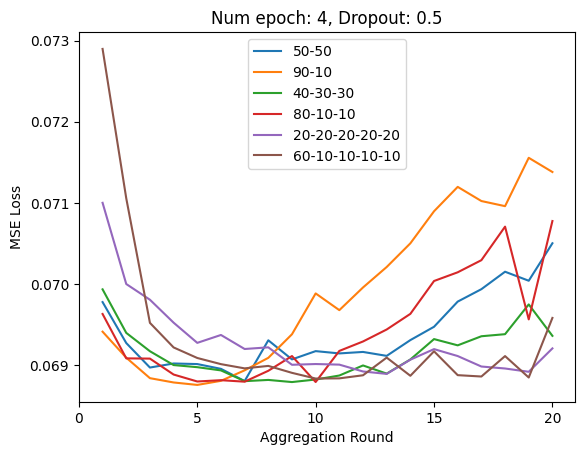

In [46]:
# 4 epoch, dropout
a = [(1, 0.06977660953998566), (2, 0.06927168369293213), (3, 0.06896955519914627), (4, 0.06901953741908073), (5, 0.06901245564222336), (6, 0.06895340979099274), (7, 0.0688028633594513), (8, 0.0693054236471653), (9, 0.06906990334391594), (10, 0.0691719613969326), (11, 0.06914365291595459), (12, 0.06916192919015884), (13, 0.06911348178982735), (14, 0.06930790096521378), (15, 0.06947215646505356), (16, 0.0697825700044632), (17, 0.06993576139211655), (18, 0.07015087082982063), (19, 0.07003968581557274), (20, 0.07050178200006485)]
b = [(1, 0.069411750882864), (2, 0.06909114122390747), (3, 0.06883856281638145), (4, 0.06878550723195076), (5, 0.06875526905059814), (6, 0.06880570575594902), (7, 0.06893519312143326), (8, 0.06908910349011421), (9, 0.06937996298074722), (10, 0.06988335773348808), (11, 0.06967715173959732), (12, 0.06995679810643196), (13, 0.0702090710401535), (14, 0.07050101459026337), (15, 0.07089631259441376), (16, 0.0711970254778862), (17, 0.07102234289050102), (18, 0.07095921039581299), (19, 0.07155532017350197), (20, 0.07138032838702202)]
c = [(1, 0.06993360444903374), (2, 0.06939688697457314), (3, 0.06917065754532814), (4, 0.06900012493133545), (5, 0.06897402554750443), (6, 0.06893425062298775), (7, 0.06880159303545952), (8, 0.06881684064865112), (9, 0.06879055872559547), (10, 0.06882190704345703), (11, 0.06887112185359001), (12, 0.06899531930685043), (13, 0.06889467686414719), (14, 0.0690690204501152), (15, 0.06932030245661736), (16, 0.06924321874976158), (17, 0.0693553239107132), (18, 0.06938090175390244), (19, 0.0697479099035263), (20, 0.06936030462384224)]
d = [(1, 0.06962995231151581), (2, 0.06908271089196205), (3, 0.0690796747803688), (4, 0.06888332217931747), (5, 0.06879755854606628), (6, 0.06881356239318848), (7, 0.06879523023962975), (8, 0.06892948597669601), (9, 0.06911129131913185), (10, 0.06879102811217308), (11, 0.06917458400130272), (12, 0.06929084658622742), (13, 0.06943859159946442), (14, 0.06963144242763519), (15, 0.07003649324178696), (16, 0.07014390453696251), (17, 0.07029323279857635), (18, 0.07070674747228622), (19, 0.0695631168782711), (20, 0.07077579200267792)]
e = [(1, 0.07100041210651398), (2, 0.06999936327338219), (3, 0.06980560347437859), (4, 0.06952286884188652), (5, 0.06927387788891792), (6, 0.06937118247151375), (7, 0.06919823959469795), (8, 0.06921855732798576), (9, 0.06900366768240929), (10, 0.06901279836893082), (11, 0.06900548934936523), (12, 0.06892091408371925), (13, 0.06889140605926514), (14, 0.06906632706522942), (15, 0.06919674202799797), (16, 0.06911125406622887), (17, 0.06898210570216179), (18, 0.06895781680941582), (19, 0.0689171589910984), (20, 0.06920558586716652)]
f = [(1, 0.07289780303835869), (2, 0.0710560567677021), (3, 0.06952039524912834), (4, 0.06921745464205742), (5, 0.06908735260367393), (6, 0.06901145726442337), (7, 0.06895937398076057), (8, 0.06898969411849976), (9, 0.06890405714511871), (10, 0.0688338652253151), (11, 0.06883614510297775), (12, 0.06887422502040863), (13, 0.06909215450286865), (14, 0.06886797025799751), (15, 0.06916969642043114), (16, 0.06887565925717354), (17, 0.06885898113250732), (18, 0.06911079213023186), (19, 0.06884674355387688), (20, 0.0695812776684761)]

aucs = [0.7461362996062552,
0.7410748223880967,
0.7475125574322024,
0.7430488029745618,
0.7470885831031375,
0.7469725083899692]

# ax = plt.gca()
# ax.set_ylim()
start = 0
plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
plt.xticks(range(start, len(a)+1, 5))
plt.legend()
plt.xlabel('Aggregation Round')
plt.ylabel('MSE Loss')
plt.title('Num epoch: 4, Dropout: 0.5')
plt.show()

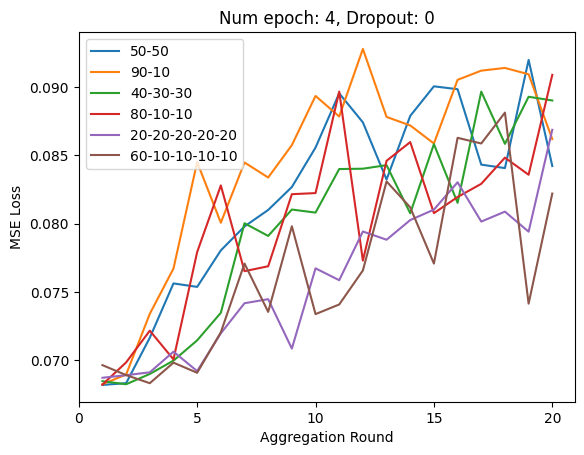

In [47]:
# 4 epoch, no dropout
a = [(1, 0.06818701326847076), (2, 0.06831569969654083), (3, 0.07164066284894943), (4, 0.0756181851029396), (5, 0.07536332309246063), (6, 0.07803601026535034), (7, 0.07978788018226624), (8, 0.08099581301212311), (9, 0.08267505466938019), (10, 0.08556345105171204), (11, 0.08953293412923813), (12, 0.08740818500518799), (13, 0.08322334289550781), (14, 0.08788032829761505), (15, 0.09004650264978409), (16, 0.08983460813760757), (17, 0.08431314677000046), (18, 0.08406034857034683), (19, 0.09197967499494553), (20, 0.08421273529529572)]
b = [(1, 0.06823510676622391), (2, 0.0689493790268898), (3, 0.07339146733283997), (4, 0.0767064243555069), (5, 0.0844988003373146), (6, 0.08006086200475693), (7, 0.08447135984897614), (8, 0.08337046951055527), (9, 0.08574187755584717), (10, 0.08934279531240463), (11, 0.08783725649118423), (12, 0.09278421849012375), (13, 0.0878056138753891), (14, 0.08718181401491165), (15, 0.08586195856332779), (16, 0.09051955491304398), (17, 0.09119388461112976), (18, 0.09139256179332733), (19, 0.09092851728200912), (20, 0.08618408441543579)]
c = [(1, 0.06846068054437637), (2, 0.0682358518242836), (3, 0.06899029016494751), (4, 0.06996682286262512), (5, 0.0714496448636055), (6, 0.0734671801328659), (7, 0.08002256602048874), (8, 0.07909391075372696), (9, 0.08102566748857498), (10, 0.0808022990822792), (11, 0.08399059623479843), (12, 0.08401571214199066), (13, 0.08427529782056808), (14, 0.08074948936700821), (15, 0.08581406623125076), (16, 0.08151695132255554), (17, 0.08965814113616943), (18, 0.08583419024944305), (19, 0.0892820954322815), (20, 0.08901068568229675)]
d = [(1, 0.06820813566446304), (2, 0.06983619183301926), (3, 0.07215818762779236), (4, 0.07005655020475388), (5, 0.07791216671466827), (6, 0.08279016613960266), (7, 0.07651350647211075), (8, 0.07687430083751678), (9, 0.08214978873729706), (10, 0.08223018795251846), (11, 0.08966280519962311), (12, 0.0772872045636177), (13, 0.0845942497253418), (14, 0.0859641507267952), (15, 0.08076096326112747), (16, 0.08194456994533539), (17, 0.08290907740592957), (18, 0.08482612669467926), (19, 0.08357270061969757), (20, 0.09088398516178131)]
e = [(1, 0.06870976090431213), (2, 0.06889926642179489), (3, 0.06910893321037292), (4, 0.0706198588013649), (5, 0.06919916719198227), (6, 0.0719650536775589), (7, 0.07416684925556183), (8, 0.07446515560150146), (9, 0.07084712386131287), (10, 0.07672160118818283), (11, 0.07585350424051285), (12, 0.0794188603758812), (13, 0.078816257417202), (14, 0.08025556802749634), (15, 0.08102021366357803), (16, 0.08302000164985657), (17, 0.08014550805091858), (18, 0.08087286353111267), (19, 0.0794057548046112), (20, 0.08686435222625732)]
f = [(1, 0.06963610649108887), (2, 0.06890565901994705), (3, 0.06831354647874832), (4, 0.06981632858514786), (5, 0.06907550245523453), (6, 0.07204009592533112), (7, 0.07707525044679642), (8, 0.07353249937295914), (9, 0.07980214804410934), (10, 0.07337022572755814), (11, 0.07407641410827637), (12, 0.07656672596931458), (13, 0.08308222144842148), (14, 0.08118394762277603), (15, 0.07707001268863678), (16, 0.08627597987651825), (17, 0.08586114645004272), (18, 0.08812118321657181), (19, 0.07413667440414429), (20, 0.08219657838344574)]

aucs = [0.5941111858606937,
0.5875742633406633,
0.6277294737081869,
0.631963549257061,
0.6535475327942455,
0.7172303181239109]

start = 0
plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
plt.xticks(range(start, len(a)+1, 5))
plt.legend()
plt.xlabel('Aggregation Round')
plt.ylabel('MSE Loss')
plt.title('Num epoch: 4, Dropout: 0')
plt.show()

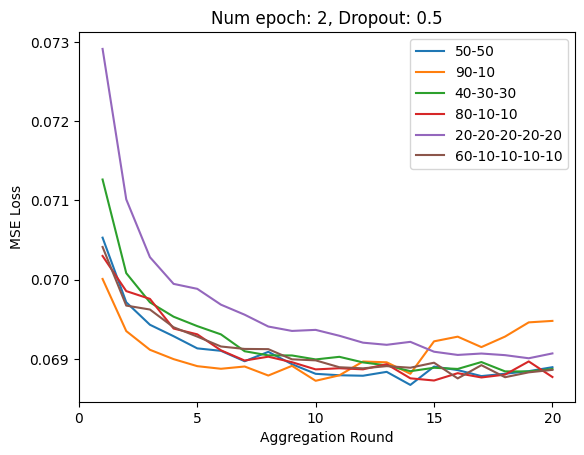

In [48]:
# 2 epoch, dropout
a = [(1, 0.07052857056260109), (2, 0.06971317529678345), (3, 0.06942944973707199), (4, 0.06928496807813644), (5, 0.06913132965564728), (6, 0.06910068169236183), (7, 0.0689690075814724), (8, 0.06908754631876945), (9, 0.06893183290958405), (10, 0.06881028413772583), (11, 0.06879235804080963), (12, 0.06878611445426941), (13, 0.06883518025279045), (14, 0.06867022067308426), (15, 0.06890160962939262), (16, 0.06885731965303421), (17, 0.06878160312771797), (18, 0.0688113197684288), (19, 0.06884389370679855), (20, 0.06889387220144272)]
b = [(1, 0.07000744715332985), (2, 0.06934964284300804), (3, 0.06911363825201988), (4, 0.06899572163820267), (5, 0.0689070001244545), (6, 0.06887400150299072), (7, 0.06890271976590157), (8, 0.06878867372870445), (9, 0.06891109421849251), (10, 0.06872247159481049), (11, 0.06879110634326935), (12, 0.06896549090743065), (13, 0.06895564496517181), (14, 0.06881086155772209), (15, 0.06922020390629768), (16, 0.06927922740578651), (17, 0.06914754956960678), (18, 0.06928032636642456), (19, 0.06945959851145744), (20, 0.06947827711701393)]
c = [(1, 0.07126228511333466), (2, 0.07008082419633865), (3, 0.06971258297562599), (4, 0.06953109428286552), (5, 0.06941226869821548), (6, 0.06930800154805183), (7, 0.06909536942839622), (8, 0.06904309615492821), (9, 0.06904201209545135), (10, 0.06899189949035645), (11, 0.06902485713362694), (12, 0.0689544752240181), (13, 0.06891679763793945), (14, 0.06884364038705826), (15, 0.06888673454523087), (16, 0.06887191906571388), (17, 0.0689588263630867), (18, 0.06884099543094635), (19, 0.068839892745018), (20, 0.06887108832597733)]
d = [(1, 0.07029739022254944), (2, 0.06985422223806381), (3, 0.06975595280528069), (4, 0.06938168033957481), (5, 0.06930851936340332), (6, 0.06910688802599907), (7, 0.06897789239883423), (8, 0.06902647390961647), (9, 0.06895690783858299), (10, 0.06886623054742813), (11, 0.06888053193688393), (12, 0.06886692717671394), (13, 0.06893187016248703), (14, 0.06875350698828697), (15, 0.06872593984007835), (16, 0.06881833076477051), (17, 0.06876438856124878), (18, 0.06880060583353043), (19, 0.06896670535206795), (20, 0.06876993551850319)]
e = [(1, 0.07291031628847122), (2, 0.07101170346140862), (3, 0.07028241828083992), (4, 0.0699453130364418), (5, 0.06988275423645973), (6, 0.06968293339014053), (7, 0.06955644860863686), (8, 0.06940707936882973), (9, 0.06935160234570503), (10, 0.06936484947800636), (11, 0.06929067149758339), (12, 0.06920342892408371), (13, 0.06917645409703255), (14, 0.06921380758285522), (15, 0.06908923014998436), (16, 0.0690486803650856), (17, 0.0690663643181324), (18, 0.06904591992497444), (19, 0.06900660693645477), (20, 0.06906779482960701)]
f = [(1, 0.07041113451123238), (2, 0.06967147067189217), (3, 0.06962164118885994), (4, 0.06939803808927536), (5, 0.06928010657429695), (6, 0.06915513426065445), (7, 0.06912447512149811), (8, 0.06912172585725784), (9, 0.06899311766028404), (10, 0.06898016855120659), (11, 0.06889340654015541), (12, 0.06887947022914886), (13, 0.0689072459936142), (14, 0.06888727843761444), (15, 0.0689505822956562), (16, 0.06875229626893997), (17, 0.06891936808824539), (18, 0.06876737624406815), (19, 0.06882894411683083), (20, 0.06886018067598343)]

aucs = [0.7469705779151715,
0.7457985899142938,
0.746679542737879,
0.7456432471094735,
0.7419396634131639,
0.7467722471356857]

start = 0
plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
plt.xticks(range(start, len(a)+1, 5))
plt.legend()
plt.xlabel('Aggregation Round')
plt.ylabel('MSE Loss')
plt.title('Num epoch: 2, Dropout: 0.5')
plt.show()

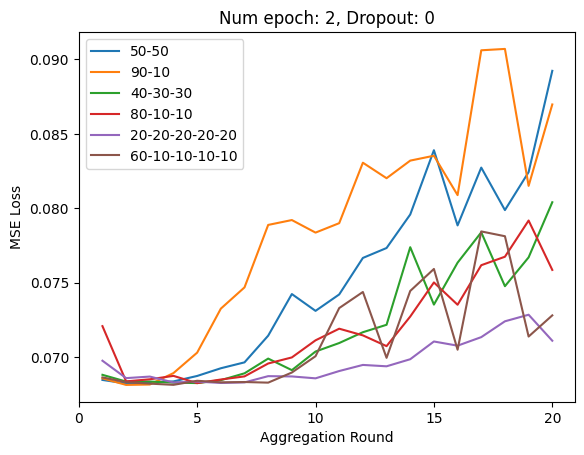

In [49]:
# 2 epoch, no dropout
a = [(1, 0.06847141683101654), (2, 0.06823252886533737), (3, 0.0682927742600441), (4, 0.0683717280626297), (5, 0.06873834133148193), (6, 0.06925536692142487), (7, 0.06965156644582748), (8, 0.07144403457641602), (9, 0.0742390975356102), (10, 0.0731097087264061), (11, 0.07421327382326126), (12, 0.07666479796171188), (13, 0.0773310586810112), (14, 0.07958250492811203), (15, 0.08389927446842194), (16, 0.07884915918111801), (17, 0.08273154497146606), (18, 0.07987842708826065), (19, 0.08242892473936081), (20, 0.089230015873909)]
b = [(1, 0.06857918202877045), (2, 0.06813626736402512), (3, 0.06816451996564865), (4, 0.06893257796764374), (5, 0.07030418515205383), (6, 0.07325877994298935), (7, 0.0746864452958107), (8, 0.07888161391019821), (9, 0.07920888066291809), (10, 0.07836569100618362), (11, 0.07899944484233856), (12, 0.08306032419204712), (13, 0.08201909065246582), (14, 0.08320073038339615), (15, 0.08352815359830856), (16, 0.08088337630033493), (17, 0.09061019122600555), (18, 0.09070202708244324), (19, 0.0815049409866333), (20, 0.0869721993803978)]
c = [(1, 0.06881434470415115), (2, 0.06836206465959549), (3, 0.06836317479610443), (4, 0.0682925432920456), (5, 0.0682593435049057), (6, 0.06845589727163315), (7, 0.06891591101884842), (8, 0.06990499049425125), (9, 0.0691288411617279), (10, 0.07037872076034546), (11, 0.07094956189393997), (12, 0.07167601585388184), (13, 0.0721752941608429), (14, 0.07738468796014786), (15, 0.0735311210155487), (16, 0.0763469934463501), (17, 0.07838347554206848), (18, 0.07476621866226196), (19, 0.07670281082391739), (20, 0.08040528744459152)]
d = [(1, 0.07208405435085297), (2, 0.06837404519319534), (3, 0.06851447373628616), (4, 0.06874396651983261), (5, 0.06825663894414902), (6, 0.06849905103445053), (7, 0.06870970129966736), (8, 0.06957562267780304), (9, 0.06998290866613388), (10, 0.07113165408372879), (11, 0.07191269099712372), (12, 0.07146444916725159), (13, 0.07074099034070969), (14, 0.07272844016551971), (15, 0.07501904666423798), (16, 0.07352031022310257), (17, 0.07617668062448502), (18, 0.07674553245306015), (19, 0.07917706668376923), (20, 0.07585973292589188)]
e = [(1, 0.06976153701543808), (2, 0.06859298050403595), (3, 0.0686970055103302), (4, 0.06830185651779175), (5, 0.06835927069187164), (6, 0.06826809793710709), (7, 0.0683055967092514), (8, 0.06872536987066269), (9, 0.06870624423027039), (10, 0.06857891380786896), (11, 0.06906887888908386), (12, 0.06947885453701019), (13, 0.0693870484828949), (14, 0.06986233592033386), (15, 0.07105319947004318), (16, 0.07077226787805557), (17, 0.0713457390666008), (18, 0.07240930944681168), (19, 0.07285020500421524), (20, 0.0711042657494545)]
f = [(1, 0.06864055246114731), (2, 0.06832374632358551), (3, 0.06822279095649719), (4, 0.06814225018024445), (5, 0.06841505318880081), (6, 0.0683109313249588), (7, 0.06833074241876602), (8, 0.06828969717025757), (9, 0.06896870583295822), (10, 0.07006516307592392), (11, 0.07329774647951126), (12, 0.07437839359045029), (13, 0.06995552033185959), (14, 0.07444737106561661), (15, 0.0759245827794075), (16, 0.07050066441297531), (17, 0.07844452559947968), (18, 0.07812274247407913), (19, 0.07138551771640778), (20, 0.07280702888965607)]

aucs = [0.67524016068301,
0.6426864122734552,
0.7027615913342973,
0.7163079319078894,
0.7402823901269913,
0.7380342618854605]

start = 0
plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
plt.xticks(range(start, len(a)+1, 5))
plt.legend()
plt.xlabel('Aggregation Round')
plt.ylabel('MSE Loss')
plt.title('Num epoch: 2, Dropout: 0')
plt.show()

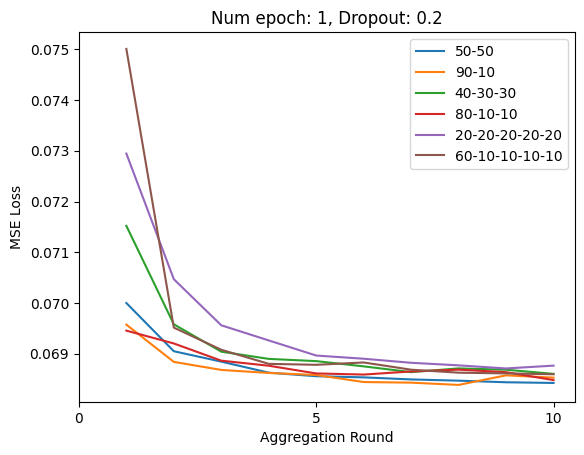

In [47]:
# 1 epoch, dropout
# a = [(1, 0.07217413932085037), (2, 0.07059970498085022), (3, 0.0700313188135624), (4, 0.06977343186736107), (5, 0.0695670060813427), (6, 0.06951440498232841), (7, 0.06942347809672356), (8, 0.06929634883999825), (9, 0.06918080896139145), (10, 0.06914928555488586), (11, 0.0690404400229454), (12, 0.06904001906514168), (13, 0.06903601810336113), (14, 0.06899090856313705), (15, 0.06894943490624428), (16, 0.06891066953539848), (17, 0.06894304603338242), (18, 0.06886399164795876), (19, 0.06889636069536209), (20, 0.06881430745124817)]
# b = [(1, 0.07107852399349213), (2, 0.06995697692036629), (3, 0.0696210078895092), (4, 0.06954682245850563), (5, 0.06936347857117653), (6, 0.06920158490538597), (7, 0.06916188448667526), (8, 0.06907786056399345), (9, 0.06902848556637764), (10, 0.06895515695214272), (11, 0.06894311308860779), (12, 0.06893378123641014), (13, 0.06900051608681679), (14, 0.06887799128890038), (15, 0.06882689893245697), (16, 0.06883783638477325), (17, 0.06892050057649612), (18, 0.06888129934668541), (19, 0.068879634141922), (20, 0.06885011121630669)]
# c = [(1, 0.07390354946255684), (2, 0.07154736667871475), (3, 0.07069197297096252), (4, 0.07031494006514549), (5, 0.06987559422850609), (6, 0.06980697065591812), (7, 0.06967107579112053), (8, 0.06965053826570511), (9, 0.06949364021420479), (10, 0.06941482797265053), (11, 0.06938975304365158), (12, 0.06919596344232559), (13, 0.0692736878991127), (14, 0.06921045854687691), (15, 0.06909211352467537), (16, 0.06912977248430252), (17, 0.06908175721764565), (18, 0.06909863278269768), (19, 0.06898351386189461), (20, 0.06903541088104248)]
# d = [(1, 0.07133327797055244), (2, 0.07112349569797516), (3, 0.07014051452279091), (4, 0.06974496319890022), (5, 0.06961876899003983), (6, 0.06938308477401733), (7, 0.06926960870623589), (8, 0.06931177526712418), (9, 0.06932191923260689), (10, 0.06921925023198128), (11, 0.06902919709682465), (12, 0.06924557313323021), (13, 0.06894142553210258), (14, 0.06903783604502678), (15, 0.06895938143134117), (16, 0.068906269967556), (17, 0.06893972307443619), (18, 0.06884971261024475), (19, 0.06889240443706512), (20, 0.06886069104075432)]
# e = [(1, 0.07465575635433197), (2, 0.07275452837347984), (3, 0.07182274386286736), (4, 0.0711505189538002), (5, 0.07066195830702782), (6, 0.07060786709189415), (7, 0.07037855312228203), (8, 0.07014580816030502), (9, 0.06991171464323997), (10, 0.06984556466341019), (11, 0.06976290792226791), (12, 0.06973376870155334), (13, 0.06962449103593826), (14, 0.06962094455957413), (15, 0.06961972638964653), (16, 0.06957901269197464), (17, 0.06947414949536324), (18, 0.06944362446665764), (19, 0.069328423589468), (20, 0.06934569031000137)]
# f = [(1, 0.07197452709078789), (2, 0.07050400972366333), (3, 0.07036400586366653), (4, 0.07026876136660576), (5, 0.06995503231883049), (6, 0.0698237456381321), (7, 0.06966806948184967), (8, 0.0695817843079567), (9, 0.06953782215714455), (10, 0.06955385208129883), (11, 0.06959262117743492), (12, 0.06934988871216774), (13, 0.0693424753844738), (14, 0.0693301185965538), (15, 0.06925993785262108), (16, 0.06921928748488426), (17, 0.0692456029355526), (18, 0.06934505701065063), (19, 0.06918233633041382), (20, 0.06923532113432884)]

# aucs = [0.7442428446693714,
# 0.746228342273551,
# 0.7439237269829204,
# 0.7449382467758126,
# 0.7359478936957966,
# 0.7385981742636339]

a = [(1, 0.07210175320506096), (2, 0.07058792188763618), (3, 0.06994509696960449), (4, 0.06964127346873283), (5, 0.06950417533516884), (6, 0.06936682760715485), (7, 0.06927689537405968), (8, 0.06925814598798752), (9, 0.06913654878735542), (10, 0.06908436864614487), (11, 0.06901342049241066), (12, 0.06909887865185738), (13, 0.06895333528518677), (14, 0.06884685531258583), (15, 0.0688835084438324), (16, 0.06885207071900368), (17, 0.06882685795426369), (18, 0.0689508356153965), (19, 0.0688246637582779), (20, 0.06877321377396584), (21, 0.06900294125080109), (22, 0.0687880851328373), (23, 0.06877313554286957), (24, 0.06881174445152283), (25, 0.0687091313302517), (26, 0.06872345507144928), (27, 0.06865334138274193), (28, 0.06870602816343307), (29, 0.06869807466864586), (30, 0.06875557452440262)]
b = [(1, 0.07099535316228867), (2, 0.07004274427890778), (3, 0.06976767256855965), (4, 0.06940783187747002), (5, 0.06926211714744568), (6, 0.069235660135746), (7, 0.069121602922678), (8, 0.06904765218496323), (9, 0.06901995092630386), (10, 0.06896600499749184), (11, 0.0689166784286499), (12, 0.06881823390722275), (13, 0.06888064369559288), (14, 0.06907028332352638), (15, 0.06883182749152184), (16, 0.06881154328584671), (17, 0.06889601424336433), (18, 0.06882261112332344), (19, 0.06887638196349144), (20, 0.06887884065508842), (21, 0.0688706487417221), (22, 0.06882286816835403), (23, 0.0688730925321579), (24, 0.06892022117972374), (25, 0.06889032572507858), (26, 0.0690235085785389), (27, 0.0688951276242733), (28, 0.06899977847933769), (29, 0.06912732124328613), (30, 0.06900779902935028)]
c = [(1, 0.07309731468558311), (2, 0.07134616374969482), (3, 0.07055387273430824), (4, 0.07008722424507141), (5, 0.06986645981669426), (6, 0.06975247338414192), (7, 0.0696304403245449), (8, 0.0695551186800003), (9, 0.06946492195129395), (10, 0.06934512406587601), (11, 0.06932860985398293), (12, 0.06918307021260262), (13, 0.0691993497312069), (14, 0.06916378065943718), (15, 0.06912153586745262), (16, 0.06907004863023758), (17, 0.06908038631081581), (18, 0.06906889379024506), (19, 0.06905512511730194), (20, 0.06899940222501755), (21, 0.06898588314652443), (22, 0.0689711719751358), (23, 0.06898274645209312), (24, 0.06898203119635582), (25, 0.06894524395465851), (26, 0.0689912885427475), (27, 0.06884083524346352), (28, 0.0688815712928772), (29, 0.06882012635469437), (30, 0.06887874007225037)]
d = [(1, 0.07120218127965927), (2, 0.07003232091665268), (3, 0.07002276182174683), (4, 0.0697178803384304), (5, 0.06947477906942368), (6, 0.06928981840610504), (7, 0.06928886100649834), (8, 0.06910420209169388), (9, 0.0691383071243763), (10, 0.0690893679857254), (11, 0.06911524385213852), (12, 0.06897709146142006), (13, 0.0689595602452755), (14, 0.06891199946403503), (15, 0.0689493827521801), (16, 0.06891859695315361), (17, 0.06889814883470535), (18, 0.0688469186425209), (19, 0.06886576861143112), (20, 0.06894519552588463), (21, 0.06873714178800583), (22, 0.0687788724899292), (23, 0.06872387230396271), (24, 0.06886601448059082), (25, 0.06876013427972794), (26, 0.06875118240714073), (27, 0.06885956600308418), (28, 0.06874792277812958), (29, 0.06869141012430191), (30, 0.06877878308296204)]
e = [(1, 0.07468659430742264), (2, 0.07266705483198166), (3, 0.0717230960726738), (4, 0.07101618871092796), (5, 0.07067613303661346), (6, 0.07030585408210754), (7, 0.07013501971960068), (8, 0.06995944306254387), (9, 0.06985657289624214), (10, 0.06982123479247093), (11, 0.06972214952111244), (12, 0.06968749314546585), (13, 0.06961455941200256), (14, 0.06950410455465317), (15, 0.06941274926066399), (16, 0.0694778710603714), (17, 0.06941459327936172), (18, 0.06949851661920547), (19, 0.06929104030132294), (20, 0.06944425776600838), (21, 0.06927734985947609), (22, 0.06924832239747047), (23, 0.06937727704644203), (24, 0.06921910494565964), (25, 0.06918735429644585), (26, 0.06914427131414413), (27, 0.06915368139743805), (28, 0.06913140416145325), (29, 0.06908521056175232), (30, 0.06901752576231956)]
f = [(1, 0.07207531854510307), (2, 0.07162092626094818), (3, 0.07131751254200935), (4, 0.07031064480543137), (5, 0.06989217549562454), (6, 0.06966147571802139), (7, 0.0696369893848896), (8, 0.06961105391383171), (9, 0.06962306052446365), (10, 0.06951547041535378), (11, 0.06948601081967354), (12, 0.0694907046854496), (13, 0.06933947280049324), (14, 0.06937454640865326), (15, 0.06939686462283134), (16, 0.06939056888222694), (17, 0.06923400983214378), (18, 0.06924470514059067), (19, 0.06922738626599312), (20, 0.06916943192481995), (21, 0.06923806294798851), (22, 0.06910352781414986), (23, 0.06909877434372902), (24, 0.06914256513118744), (25, 0.06901346519589424), (26, 0.0690210871398449), (27, 0.06908034905791283), (28, 0.06896878406405449), (29, 0.06899748742580414), (30, 0.06902825832366943)]

aucs = [0.7469613837938364,
0.7458787975228542,
0.7433796428664827,
0.7456953844631442,
0.7392325820299508,
0.7453323249639484]

a = [(1, 0.07048599049448967), (2, 0.06947449594736099), (3, 0.06908107921481133), (4, 0.06901279091835022), (5, 0.06896273791790009), (6, 0.06877182796597481), (7, 0.06875821202993393), (8, 0.0687527060508728), (9, 0.06878633052110672), (10, 0.0686476081609726), (11, 0.06868446618318558), (12, 0.06858127936720848), (13, 0.06850584968924522), (14, 0.06851622462272644), (15, 0.06858675926923752)]
b = [(1, 0.06981093809008598), (2, 0.06913800537586212), (3, 0.06889704242348671), (4, 0.06873689964413643), (5, 0.06880084797739983), (6, 0.06861958652734756), (7, 0.0686122216284275), (8, 0.06859713420271873), (9, 0.06864111125469208), (10, 0.06865229830145836), (11, 0.06866391375660896), (12, 0.06861939653754234), (13, 0.06887343898415565), (14, 0.0688067264854908), (15, 0.06864697113633156)]
c = [(1, 0.07150320708751678), (2, 0.0698852501809597), (3, 0.06942832097411156), (4, 0.0692312978208065), (5, 0.06914346665143967), (6, 0.06902921572327614), (7, 0.06894228607416153), (8, 0.06895336136221886), (9, 0.06882292032241821), (10, 0.06889213249087334), (11, 0.06877999007701874), (12, 0.0688270553946495), (13, 0.06872475519776344), (14, 0.06878958642482758), (15, 0.06873971223831177)]
d = [(1, 0.0698978453874588), (2, 0.06923054158687592), (3, 0.06915025785565376), (4, 0.0690990537405014), (5, 0.06901867315173149), (6, 0.06883619353175163), (7, 0.06895088404417038), (8, 0.06871312856674194), (9, 0.0688704326748848), (10, 0.06877773255109787), (11, 0.06866960227489471), (12, 0.06862033158540726), (13, 0.06862026080489159), (14, 0.06874467805027962), (15, 0.06861961632966995)]
e = [(1, 0.07303252071142197), (2, 0.07100088894367218), (3, 0.07007201761007309), (4, 0.06988880038261414), (5, 0.06940176337957382), (6, 0.06932580843567848), (7, 0.06920241564512253), (8, 0.06907597184181213), (9, 0.06911689043045044), (10, 0.0690603256225586), (11, 0.06903383880853653), (12, 0.0689220055937767), (13, 0.06891228631138802), (14, 0.068902887403965), (15, 0.0688614659011364)]
f = [(1, 0.0750666968524456), (2, 0.07021305337548256), (3, 0.06985287368297577), (4, 0.06930797919631004), (5, 0.06911211460828781), (6, 0.06910714507102966), (7, 0.06898604333400726), (8, 0.06899182870984077), (9, 0.06899065151810646), (10, 0.06889164447784424), (11, 0.06889185309410095), (12, 0.06891144067049026), (13, 0.06889907270669937), (14, 0.06889244168996811), (15, 0.06895938515663147)]

aucs = [0.7490972492547194,
0.7483534336673833,
0.746291398750616,
0.7493712150906355,
0.742628176055738,
0.743572247197698]

a = [(1, 0.0699995681643486), (2, 0.06904951483011246), (3, 0.06884479895234108), (4, 0.06862710416316986), (5, 0.06855741143226624), (6, 0.0685347244143486), (7, 0.06849391013383865), (8, 0.06846953928470612), (9, 0.06843815743923187), (10, 0.06842466443777084)]
b = [(1, 0.0695735551416874), (2, 0.06883978843688965), (3, 0.06868138909339905), (4, 0.06862210482358932), (5, 0.06858102977275848), (6, 0.06844286620616913), (7, 0.06843055412173271), (8, 0.0683857835829258), (9, 0.06857475638389587), (10, 0.06852929294109344)]
c = [(1, 0.07152057811617851), (2, 0.06958035379648209), (3, 0.06904101371765137), (4, 0.06889894232153893), (5, 0.06885477155447006), (6, 0.06875143572688103), (7, 0.0686376765370369), (8, 0.0687113106250763), (9, 0.0686853900551796), (10, 0.06860362738370895)]
d = [(1, 0.06945569440722466), (2, 0.06920289248228073), (3, 0.0688634105026722), (4, 0.06876427680253983), (5, 0.06861186400055885), (6, 0.06859000399708748), (7, 0.06865157559514046), (8, 0.06868680566549301), (9, 0.0686369501054287), (10, 0.06848106905817986)]
e = [(1, 0.07294424623250961), (2, 0.07046876102685928), (3, 0.06956085562705994), (4, 0.0692625343799591), (5, 0.06896472349762917), (6, 0.06890176236629486), (7, 0.06882204860448837), (8, 0.06877141445875168), (9, 0.06871044263243675), (10, 0.06876607239246368)]
f = [(1, 0.07500699535012245), (2, 0.06951500475406647), (3, 0.06907874345779419), (4, 0.06880099326372147), (5, 0.06878229975700378), (6, 0.06882834061980247), (7, 0.06868574023246765), (8, 0.0686270259320736), (9, 0.06861275434494019), (10, 0.06859586760401726)]

aucs = [0.7496442413376223,
0.7524199808236196,
0.7497969554593109,
0.7516850572756455,
0.7464941051589833,
0.7486161552143095]

start = 0
plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
plt.xticks(range(start, len(a)+1, 5))
plt.legend()
plt.xlabel('Aggregation Round')
plt.ylabel('MSE Loss')
plt.title('Num epoch: 1, Dropout: 0.2')
plt.show()

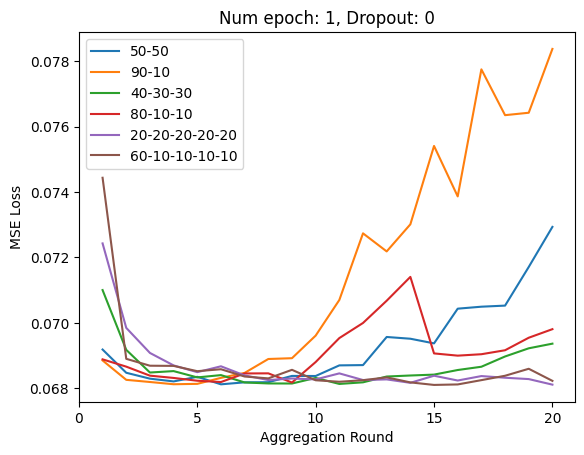

In [51]:
# 1 epoch, no dropout
a = [(1, 0.06918611377477646), (2, 0.0684761106967926), (3, 0.06829572468996048), (4, 0.06821130216121674), (5, 0.06835232675075531), (6, 0.06812279671430588), (7, 0.06818347424268723), (8, 0.0681878849864006), (9, 0.0683794617652893), (10, 0.06837712973356247), (11, 0.0687018558382988), (12, 0.06871049851179123), (13, 0.06956993788480759), (14, 0.0695166364312172), (15, 0.06937440484762192), (16, 0.07043546438217163), (17, 0.07049582898616791), (18, 0.07052891701459885), (19, 0.07171045988798141), (20, 0.07293569296598434)]
b = [(1, 0.06885255128145218), (2, 0.06825995445251465), (3, 0.06819390505552292), (4, 0.06812527775764465), (5, 0.0681367740035057), (6, 0.0683203637599945), (7, 0.06847216933965683), (8, 0.06889704614877701), (9, 0.06892132014036179), (10, 0.0696115717291832), (11, 0.07070140540599823), (12, 0.07273845374584198), (13, 0.07218574732542038), (14, 0.07301416993141174), (15, 0.07540982961654663), (16, 0.07386762648820877), (17, 0.07775142043828964), (18, 0.07635112851858139), (19, 0.0764252096414566), (20, 0.07837631553411484)]
c = [(1, 0.07100395858287811), (2, 0.06917672604322433), (3, 0.0684833824634552), (4, 0.06852703541517258), (5, 0.06833383440971375), (6, 0.06840453296899796), (7, 0.0681796669960022), (8, 0.06814946979284286), (9, 0.06814757734537125), (10, 0.06831791996955872), (11, 0.06813452392816544), (12, 0.06818388402462006), (13, 0.06836091727018356), (14, 0.06839251518249512), (15, 0.06841950863599777), (16, 0.0685601532459259), (17, 0.06866013258695602), (18, 0.06897395104169846), (19, 0.06922388821840286), (20, 0.06936600804328918)]
d = [(1, 0.06888609379529953), (2, 0.06866317987442017), (3, 0.0683874562382698), (4, 0.06831783056259155), (5, 0.06823233515024185), (6, 0.06819246709346771), (7, 0.06845509260892868), (8, 0.06845810264348984), (9, 0.06817800551652908), (10, 0.06880411505699158), (11, 0.06953658163547516), (12, 0.06999817490577698), (13, 0.07067862898111343), (14, 0.07140680402517319), (15, 0.06906758248806), (16, 0.06899940967559814), (17, 0.0690428838133812), (18, 0.06916432082653046), (19, 0.06954691559076309), (20, 0.06980879604816437)]
e = [(1, 0.07243069261312485), (2, 0.06984787434339523), (3, 0.06908213347196579), (4, 0.06870058923959732), (5, 0.06849448382854462), (6, 0.06867387890815735), (7, 0.06839519739151001), (8, 0.06825297325849533), (9, 0.06830063462257385), (10, 0.06827283650636673), (11, 0.06845717877149582), (12, 0.06825396418571472), (13, 0.06827320158481598), (14, 0.06816837936639786), (15, 0.06838566809892654), (16, 0.06823886930942535), (17, 0.06837480515241623), (18, 0.06832406669855118), (19, 0.06828292459249496), (20, 0.0681130513548851)]
f = [(1, 0.07443759590387344), (2, 0.06890231370925903), (3, 0.06869145482778549), (4, 0.06868615001440048), (5, 0.06852418184280396), (6, 0.06858403980731964), (7, 0.06836125254631042), (8, 0.06830426305532455), (9, 0.06856603175401688), (10, 0.06824707984924316), (11, 0.06820090115070343), (12, 0.0682484358549118), (13, 0.0683351531624794), (14, 0.06818164885044098), (15, 0.0681043416261673), (16, 0.06811919808387756), (17, 0.06825071573257446), (18, 0.06838443875312805), (19, 0.06859797984361649), (20, 0.06822854280471802)]

aucs = [0.7395951579130067,
0.6988036748504569,
0.7497822266832599,
0.7471236656495643,
0.7560650954141102,
0.7549760753670676]

start = 0
plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
plt.xticks(range(start, len(a)+1, 5))
plt.legend()
plt.xlabel('Aggregation Round')
plt.ylabel('MSE Loss')
plt.title('Num epoch: 1, Dropout: 0')
plt.show()

### LSTM

In [6]:
# Load data
nts = torch.load('./dataset2/nts.pt')
y = torch.load('./dataset2/y.pt')
ts1 = torch.load('./dataset2/ts1.pt')
ts2 = torch.load('./dataset2/ts2.pt')
ts3 = torch.load('./dataset2/ts3.pt')
ts4 = torch.load('./dataset2/ts4.pt')

In [7]:
# Train test split
from sklearn.model_selection import StratifiedKFold, KFold

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(nts, y)
g = skf.split(nts, y)
# _, train_index = next(g)
# _, test_index = next(g)
train_index, test_index = next(g)
nts_train = nts[train_index]
y_train = y[train_index]
ts1_train = ts1[train_index]
ts2_train = ts2[train_index]
ts3_train = ts3[train_index]
ts4_train = ts4[train_index]
nts_test = nts[test_index]
y_test = y[test_index]
ts1_test = ts1[test_index]
ts2_test = ts2[test_index]
ts3_test = ts3[test_index]
ts4_test = ts4[test_index]

In [8]:
# Verify data
print(nts_train.shape)
print(ts1_train.shape)
print(ts2_train.shape)
print(ts3_train.shape)
print(ts4_train.shape)
print(ts1_train.dtype)
print(y_train.dtype)
print(torch.isnan(ts1_train).any())
print(torch.isnan(ts2_train).any())
print(torch.isnan(ts3_train).any())
print(torch.isnan(ts4_train).any())
print(torch.isnan(ts1_test).any())
print(torch.isnan(ts2_test).any())
print(torch.isnan(ts3_test).any())
print(torch.isnan(ts4_test).any())

torch.Size([153755, 100])
torch.Size([153755, 4, 12, 1])
torch.Size([153755, 4, 4, 8])
torch.Size([153755, 4, 4, 16])
torch.Size([153755, 4, 4, 29])
torch.float32
torch.float32
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [9]:
# Define train function
from net_archs import LSTMModel2 as LSTMModel
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, f1_score

def train_lstm(net, optimizer, x, y, num_epoch=4, batch_size=128):
  print_every = -1

  for n in range(num_epoch):
    # Mini batch sgd
    nts, ts1, ts2, ts3, ts4 = x
    permutation = torch.randperm(nts.size()[0])
    for i in range(0, nts.size()[0], batch_size):
      indices = permutation[i:i+batch_size]
      x_mini = (nts[indices], ts1[indices], ts2[indices], ts3[indices], ts4[indices])
      y_mini = y[indices]
      y_pred = net(x_mini)
      loss = nn.MSELoss()(y_pred, y_mini)
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()
      if print_every != -1 and (i / batch_size) % print_every == 0:
        print(f'Epoch: {n + 1}, Iteration: {round(i / batch_size)}, Loss: {loss.sum()}')
    if print_every == -1:
      print(f'Epoch: {n + 1}, Loss: {loss.sum()}')


In [119]:
# Fold 1 train
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
train_lstm(model, optimizer, (nts_train, ts1_train, ts2_train, ts3_train, ts4_train), y_train, num_epoch=4)
torch.save(model.state_dict(), './lstm2v3.pth')

Epoch: 1, Loss: 0.022889558225870132
Epoch: 2, Loss: 0.005823907442390919
Epoch: 3, Loss: 0.1089847981929779
Epoch: 4, Loss: 0.05668003112077713


In [120]:
# Fold 1 test
test(model, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test)

0.7527724181517002

In [22]:
# Fold 2 train
model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
train_lstm(model, optimizer, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test, num_epoch=4)

Epoch: 1, Loss: 0.03992954269051552
Epoch: 2, Loss: 0.10164852440357208
Epoch: 3, Loss: 0.07106120884418488
Epoch: 4, Loss: 0.10119901597499847


In [23]:
# Fold 2 test
test(model, (nts_train, ts1_train, ts2_train, ts3_train, ts4_train), y_train)

0.7521971433880617

In [33]:
# Print 2 fold cross validation statistics
import statistics
print(statistics.mean([0.7527724181517002, 0.7521971433880617]))
print(statistics.stdev([0.7527724181517002, 0.7521971433880617]))

0.7524847807698809
0.00040678068641427186


In [14]:
# Define LSTM FL simulation wrapper
from fl_simu import lstm_simulation2

def run_lstm_simulation(split, dir='default', num_epoch=4, batch_size=128, num_rounds=5, dropout=True, dropout_rate=0.5):
    return lstm_simulation2(split, nts_train, ts1_train, ts2_train, ts3_train, ts4_train, y_train, nts_test, ts1_test, ts2_test, ts3_test, ts4_test, y_test, dir, num_epoch, batch_size, num_rounds, dropout, dropout_rate)

In [16]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', num_epoch=2, num_rounds=20, dropout=True, dropout_rate=0.2)
auc = test(model_fl, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test)
print(auc)

INFO flwr 2023-06-23 05:31:02,962 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-23 05:31:06,838	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-06-23 05:31:07,430 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 8009772237.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-23 05:31:07,431 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-23 05:31:07,431 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-23 05:31:10,827 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-23 05:31:10,829 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-23 05:31:10,829 | server.py:101 | FL starting
DEBUG flwr 2023-06-23 05:31:10,829 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 0

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-23 05:31:59,805 | server.py:182 | evaluate_round 1 received 1 results and 1 failures
WARNING flwr 2023-06-23 05:31:59,807 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-23 05:31:59,807 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:32:29,400 | server.py:232 | fit_round 2 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:32:29,423 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-23 05:32:48,541 | server.py:182 | evaluate_round 2 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:32:48,543 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:33:16,451 | server.py:232 | fit_round 3 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:33:16,475 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-23 05:33:35,552 | server.py:182 | evaluate_round 3 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:33:35,554 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:34:04,744 | server.py:232 | fit_round 4 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:34:04,768 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-23 05:34:23,104 | server.py:182 | evaluate_round 4 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:34:23,106 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:34:51,663 | server.py:232 | fit_round 5 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:34:51,686 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-23 05:35:09,873 | server.py:182 | evaluate_round 5 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:35:09,875 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:35:37,959 | server.py:232 | fit_round 6 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:35:37,982 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-23 05:35:56,529 | server.py:182 | evaluate_round 6 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:35:56,531 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:36:25,778 | server.py:232 | fit_round 7 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:36:25,802 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-23 05:36:43,855 | server.py:182 | evaluate_round 7 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:36:43,857 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:37:12,285 | server.py:232 | fit_round 8 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:37:12,308 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-23 05:37:30,917 | server.py:182 | evaluate_round 8 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:37:30,920 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:37:58,833 | server.py:232 | fit_round 9 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:37:58,864 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-23 05:38:16,882 | server.py:182 | evaluate_round 9 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:38:16,884 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:38:45,273 | server.py:232 | fit_round 10 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:38:45,298 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-23 05:39:03,712 | server.py:182 | evaluate_round 10 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:39:03,714 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:39:31,728 | server.py:232 | fit_round 11 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:39:31,750 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-23 05:39:49,740 | server.py:182 | evaluate_round 11 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:39:49,742 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:40:17,330 | server.py:232 | fit_round 12 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:40:17,362 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-23 05:40:36,102 | server.py:182 | evaluate_round 12 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:40:36,104 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:41:04,884 | server.py:232 | fit_round 13 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:41:04,908 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-23 05:41:23,156 | server.py:182 | evaluate_round 13 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:41:23,157 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:41:52,013 | server.py:232 | fit_round 14 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:41:52,037 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-23 05:42:09,878 | server.py:182 | evaluate_round 14 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:42:09,880 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:42:38,069 | server.py:232 | fit_round 15 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:42:38,093 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-23 05:42:55,537 | server.py:182 | evaluate_round 15 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:42:55,539 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:43:24,393 | server.py:232 | fit_round 16 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:43:24,419 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-23 05:43:43,443 | server.py:182 | evaluate_round 16 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:43:43,446 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:44:11,822 | server.py:232 | fit_round 17 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:44:11,848 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-23 05:44:30,047 | server.py:182 | evaluate_round 17 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:44:30,049 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:44:57,274 | server.py:232 | fit_round 18 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:44:57,299 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-23 05:45:15,195 | server.py:182 | evaluate_round 18 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:45:15,197 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:45:43,393 | server.py:232 | fit_round 19 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:45:43,418 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-23 05:46:01,658 | server.py:182 | evaluate_round 19 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:46:01,660 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 05:46:29,599 | server.py:232 | fit_round 20 received 1 results and 1 failures
DEBUG flwr 2023-06-23 05:46:29,624 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-23 05:46:47,375 | server.py:182 | evaluate_round 20 received 1 results and 1 failures
INFO flwr 2023-06-23 05:46:47,377 | server.py:147 | FL finished in 936.5333819161169
INFO flwr 2023-06-23 05:46:47,378 | app.py:218 | app_fit: losses_distributed [(1, 0.0742027536034584), (2, 0.07163708657026291), (3, 0.07046503573656082), (4, 0.0698637142777443), (5, 0.06948872655630112), (6, 0.06931274384260178), (7, 0.06915070116519928), (8, 0.06913015991449356), (9, 0.06902742385864258), (10, 0.06898340582847595), (11, 0.06891731917858124), (12, 0.06889353692531586), (13, 0.06886976212263107), (14, 0.06888078153133392), (15, 0.06887782365083694), (16, 0.06873002648353577), (17, 0.06883274763822556), (18, 0.06877515465021133), (19, 0.06886012107133865), (20, 0.06880373507738113)]
INFO flwr 2023-06-23 05:46:47,378 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-23 05:46:47,378 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-23 05:46:47,378 | a

0.7416840889547307


In [12]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', num_epoch=2, num_rounds=20, dropout=True, dropout_rate=0.2)
auc = test(model_fl, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test)
print(auc)

INFO flwr 2023-06-17 20:26:18,878 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-17 20:26:23,175	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-06-17 20:26:23,704 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8447849268.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-17 20:26:23,704 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-17 20:26:23,704 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-17 20:26:26,102 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-17 20:26:26,103 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-17 20:26:26,103 | server.py:101 | FL starting
DEBUG flwr 2023-06-17 20:26:26,104 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 2

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-17 20:28:03,790 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-17 20:28:03,792 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-17 20:28:03,792 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:29:04,965 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:29:04,989 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-17 20:29:41,666 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:29:41,667 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:30:43,247 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:30:43,275 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-17 20:31:31,936 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:31:31,938 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:32:35,343 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:32:35,370 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-17 20:33:23,462 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:33:23,464 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:34:43,258 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:34:43,289 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-17 20:35:31,227 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:35:31,229 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:36:35,595 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:36:35,626 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-17 20:37:23,521 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:37:23,523 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:38:45,075 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:38:45,105 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-17 20:39:33,373 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:39:33,375 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:40:52,672 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:40:52,702 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-17 20:41:40,627 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:41:40,629 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:43:00,894 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:43:00,929 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-17 20:43:48,974 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:43:48,976 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:45:09,437 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:45:09,470 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-17 20:45:57,302 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:45:57,304 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:47:02,657 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:47:02,688 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-17 20:47:51,755 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:47:51,758 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:49:11,493 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:49:11,543 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-17 20:49:59,298 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:49:59,303 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:51:05,985 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:51:06,013 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-17 20:51:54,567 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:51:54,571 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:53:14,976 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:53:15,011 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-17 20:54:03,009 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:54:03,011 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:55:23,249 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:55:23,282 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-17 20:56:11,184 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:56:11,186 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:57:17,934 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:57:17,964 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-17 20:58:07,221 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:58:07,222 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 20:59:14,219 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-17 20:59:14,253 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-17 21:00:02,438 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:00:02,440 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 21:01:06,276 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:01:06,303 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-17 21:01:56,284 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:01:56,286 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 21:03:16,693 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:03:16,726 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-17 21:04:05,726 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:04:05,728 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-17 21:05:11,014 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:05:11,045 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-17 21:05:59,574 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-17 21:05:59,576 | server.py:147 | FL finished in 2373.424594625132
INFO flwr 2023-06-17 21:05:59,577 | app.py:218 | app_fit: losses_distributed [(1, 0.06935819238424301), (2, 0.06901456415653229), (3, 0.06890231743454933), (4, 0.0688408762216568), (5, 0.06880392134189606), (6, 0.06868019700050354), (7, 0.06904244422912598), (8, 0.06883866339921951), (9, 0.06889740377664566), (10, 0.06868627294898033), (11, 0.06882364675402641), (12, 0.06881307065486908), (13, 0.0688134953379631), (14, 0.06860192120075226), (15, 0.068638876080513), (16, 0.06877820193767548), (17, 0.06886183097958565), (18, 0.0686398521065712), (19, 0.06880871579051018), (20, 0.06867573037743568)]
INFO flwr 2023-06-17 21:05:59,577 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-17 21:05:59,577 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-17 21:05:59,578 | app.

0.7434262851780735


In [13]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', num_epoch=2, num_rounds=20, dropout=True, dropout_rate=0.2)
auc = test(model_fl, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test)
print(auc)

INFO flwr 2023-06-17 21:06:08,643 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-17 21:06:12,864	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-06-17 21:06:13,443 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 7658163405.0}
INFO flwr 2023-06-17 21:06:13,444 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-17 21:06:13,444 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-17 21:06:16,438 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-17 21:06:16,439 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-17 21:06:16,439 | server.py:101 | FL starting
DEBUG flwr 2023-06-17 21:06:16,440 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 2

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-17 21:07:30,101 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-17 21:07:30,108 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-17 21:07:30,115 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:08:12,894 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:08:12,918 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-17 21:09:00,415 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:09:00,417 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:09:54,848 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:09:54,873 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-17 21:10:42,322 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:10:42,324 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:11:38,131 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:11:38,158 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-17 21:12:25,961 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:12:25,963 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:13:15,025 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:13:15,051 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-17 21:14:02,419 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:14:02,421 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:14:52,728 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:14:52,760 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-17 21:15:40,398 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:15:40,402 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:16:35,300 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:16:35,326 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-17 21:17:26,957 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:17:26,959 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:18:18,127 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:18:18,160 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-17 21:19:07,514 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:19:07,516 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:20:05,708 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:20:05,740 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-17 21:20:54,152 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:20:54,153 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:21:42,422 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:21:42,449 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-17 21:22:29,792 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:22:29,794 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:23:23,918 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:23:23,945 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-17 21:24:11,722 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:24:11,724 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:25:06,934 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:25:06,965 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-17 21:25:54,635 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:25:54,639 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:26:49,964 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:26:49,997 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-17 21:27:37,529 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:27:37,531 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:28:31,206 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:28:31,235 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-17 21:29:19,302 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:29:19,304 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:30:07,804 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:30:07,834 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-17 21:30:55,908 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:30:55,910 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:31:51,832 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:31:51,866 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-17 21:32:39,621 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:32:39,622 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:33:29,877 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:33:29,911 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-17 21:34:17,793 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:34:17,795 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:35:08,252 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:35:08,282 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-17 21:35:56,985 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:35:56,987 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:36:48,048 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:36:48,084 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-17 21:37:37,494 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:37:37,498 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:38:00,753 | server.py:232 | fit_round 20 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:38:00,772 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-17 21:38:18,303 | server.py:182 | evaluate_round 20 received 1 results and 1 failures
INFO flwr 2023-06-17 21:38:18,304 | server.py:147 | FL finished in 1921.8981514167972
INFO flwr 2023-06-17 21:38:18,304 | app.py:218 | app_fit: losses_distributed [(1, 0.07001930475234985), (2, 0.070020891726017), (3, 0.06897873431444168), (4, 0.0689806118607521), (5, 0.06903624534606934), (6, 0.069533821195364), (7, 0.06898080930113792), (8, 0.06882381811738014), (9, 0.06887868046760559), (10, 0.0689094215631485), (11, 0.06967797502875328), (12, 0.06887407973408699), (13, 0.06878840178251266), (14, 0.06909054517745972), (15, 0.06882332637906075), (16, 0.06903349608182907), (17, 0.06930890306830406), (18, 0.06909511238336563), (19, 0.06869560480117798), (20, 0.06889160722494125)]
INFO flwr 2023-06-17 21:38:18,304 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-17 21:38:18,305 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-17 21:38:18,305 | app.

0.7442342373280199


In [14]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', num_epoch=2, num_rounds=20, dropout=True, dropout_rate=0.2)
auc = test(model_fl, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test)
print(auc)

INFO flwr 2023-06-17 21:38:27,043 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-17 21:38:30,880	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-06-17 21:38:31,426 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 8106547610.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-06-17 21:38:31,427 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-17 21:38:31,427 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-17 21:38:34,231 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-17 21:38:34,232 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-17 21:38:34,232 | server.py:101 | FL starting
DEBUG flwr 2023-06-17 21:38:34,232 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 2

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-17 21:40:03,654 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-17 21:40:03,656 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-17 21:40:03,656 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:40:55,185 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:40:55,219 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-17 21:41:32,304 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:41:32,306 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:41:41,145 | server.py:232 | fit_round 3 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:41:41,167 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-17 21:41:58,467 | server.py:182 | evaluate_round 3 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:41:58,469 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:42:41,360 | server.py:232 | fit_round 4 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:42:41,383 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-17 21:43:00,186 | server.py:182 | evaluate_round 4 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:43:00,187 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:43:07,934 | server.py:232 | fit_round 5 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:43:07,951 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-17 21:43:25,616 | server.py:182 | evaluate_round 5 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:43:25,619 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:43:33,354 | server.py:232 | fit_round 6 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:43:33,378 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-17 21:43:51,654 | server.py:182 | evaluate_round 6 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:43:51,656 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:43:58,933 | server.py:232 | fit_round 7 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:43:58,952 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-17 21:44:16,682 | server.py:182 | evaluate_round 7 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:44:16,684 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:44:24,032 | server.py:232 | fit_round 8 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:44:24,053 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-17 21:44:41,451 | server.py:182 | evaluate_round 8 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:44:41,454 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:44:49,180 | server.py:232 | fit_round 9 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:44:49,216 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-17 21:45:07,078 | server.py:182 | evaluate_round 9 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:45:07,081 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:45:14,811 | server.py:232 | fit_round 10 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:45:14,832 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-17 21:45:32,107 | server.py:182 | evaluate_round 10 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:45:32,109 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:45:39,641 | server.py:232 | fit_round 11 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:45:39,661 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-17 21:45:57,392 | server.py:182 | evaluate_round 11 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:45:57,394 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:46:05,224 | server.py:232 | fit_round 12 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:46:05,246 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-17 21:46:22,447 | server.py:182 | evaluate_round 12 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:46:22,449 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:46:29,809 | server.py:232 | fit_round 13 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:46:29,828 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-17 21:46:48,125 | server.py:182 | evaluate_round 13 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:46:48,127 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:47:31,432 | server.py:232 | fit_round 14 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:47:31,458 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-17 21:47:49,731 | server.py:182 | evaluate_round 14 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:47:49,732 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:48:31,715 | server.py:232 | fit_round 15 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:48:31,760 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-17 21:48:49,953 | server.py:182 | evaluate_round 15 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:48:49,953 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:49:31,324 | server.py:232 | fit_round 16 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:49:31,349 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-17 21:49:49,227 | server.py:182 | evaluate_round 16 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:49:49,228 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:49:56,807 | server.py:232 | fit_round 17 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:49:56,827 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-17 21:50:14,272 | server.py:182 | evaluate_round 17 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:50:14,274 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:50:55,510 | server.py:232 | fit_round 18 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:50:55,532 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-17 21:51:13,781 | server.py:182 | evaluate_round 18 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:51:13,783 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:51:21,731 | server.py:232 | fit_round 19 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:51:21,749 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-17 21:51:38,694 | server.py:182 | evaluate_round 19 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:51:38,696 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-17 21:51:46,105 | server.py:232 | fit_round 20 received 1 results and 1 failures
DEBUG flwr 2023-06-17 21:51:46,126 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-17 21:52:03,796 | server.py:182 | evaluate_round 20 received 1 results and 1 failures
INFO flwr 2023-06-17 21:52:03,798 | server.py:147 | FL finished in 809.5939946670551
INFO flwr 2023-06-17 21:52:03,799 | app.py:218 | app_fit: losses_distributed [(1, 0.06941679492592812), (2, 0.06897272914648056), (3, 0.06904304027557373), (4, 0.06900815665721893), (5, 0.06905075162649155), (6, 0.06893941760063171), (7, 0.0689699649810791), (8, 0.06893399357795715), (9, 0.0691620483994484), (10, 0.06905501335859299), (11, 0.06915271282196045), (12, 0.069053515791893), (13, 0.06915181130170822), (14, 0.06887482106685638), (15, 0.06875012069940567), (16, 0.06879431009292603), (17, 0.06882598251104355), (18, 0.06876110285520554), (19, 0.06881169974803925), (20, 0.06877046078443527)]
INFO flwr 2023-06-17 21:52:03,800 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-17 21:52:03,800 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-17 21:52:03,800 | app

0.7428900517731398


In [15]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', num_epoch=2, num_rounds=20, dropout=True, dropout_rate=0.2)
auc = test(model_fl, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test)
print(auc)

INFO flwr 2023-06-17 21:52:12,822 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-17 21:52:18,029	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-06-17 21:52:18,582 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 8396903220.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-17 21:52:18,582 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-17 21:52:18,582 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-17 21:52:21,382 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-17 21:52:21,382 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-17 21:52:21,383 | server.py:101 | FL starting
DEBUG flwr 2023-06-17 21:52:21,383 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 2

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-17 21:53:28,620 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-17 21:53:28,622 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-17 21:53:28,622 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 21:54:13,445 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:54:13,469 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-17 21:55:01,880 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:55:01,882 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 21:55:46,344 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:55:46,368 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-17 21:56:34,663 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:56:34,665 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 21:57:18,939 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:57:18,965 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-17 21:58:07,468 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:58:07,472 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 21:58:51,846 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:58:51,869 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-17 21:59:39,823 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 21:59:39,825 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:00:24,847 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:00:24,873 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-17 22:01:13,859 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:01:13,864 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:02:00,277 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:02:00,307 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-17 22:02:48,883 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:02:48,885 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:03:34,604 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:03:34,630 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-17 22:04:22,816 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:04:22,818 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:05:07,333 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:05:07,360 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-17 22:05:57,355 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:05:57,358 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:06:41,543 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:06:41,571 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-17 22:07:29,914 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:07:29,917 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:08:13,746 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:08:13,775 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-17 22:09:03,358 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:09:03,363 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:09:50,069 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:09:50,097 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-17 22:10:27,473 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:10:27,477 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:10:54,182 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:10:54,207 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-17 22:11:32,081 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:11:32,086 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:11:59,941 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:11:59,967 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-17 22:12:19,030 | server.py:182 | evaluate_round 14 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:12:19,031 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:12:31,457 | server.py:232 | fit_round 15 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:12:31,474 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-17 22:12:49,480 | server.py:182 | evaluate_round 15 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:12:49,482 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:13:01,838 | server.py:232 | fit_round 16 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:13:01,855 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-17 22:13:19,575 | server.py:182 | evaluate_round 16 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:13:19,576 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:13:32,055 | server.py:232 | fit_round 17 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:13:32,073 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-17 22:13:51,098 | server.py:182 | evaluate_round 17 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:13:51,100 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:14:03,331 | server.py:232 | fit_round 18 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:14:03,351 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-17 22:14:22,091 | server.py:182 | evaluate_round 18 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:14:22,093 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:14:34,457 | server.py:232 | fit_round 19 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:14:34,477 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-17 22:14:52,349 | server.py:182 | evaluate_round 19 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:14:52,350 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:15:04,475 | server.py:232 | fit_round 20 received 1 results and 1 failures
DEBUG flwr 2023-06-17 22:15:04,495 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-17 22:15:22,325 | server.py:182 | evaluate_round 20 received 1 results and 1 failures
INFO flwr 2023-06-17 22:15:22,325 | server.py:147 | FL finished in 1380.959722166881
INFO flwr 2023-06-17 22:15:22,326 | app.py:218 | app_fit: losses_distributed [(1, 0.07071609050035477), (2, 0.06970477849245071), (3, 0.06973564997315407), (4, 0.06953737884759903), (5, 0.06915692985057831), (6, 0.06907784938812256), (7, 0.06917495653033257), (8, 0.06920583173632622), (9, 0.06884535402059555), (10, 0.0688299797475338), (11, 0.06884253025054932), (12, 0.06910882517695427), (13, 0.06883613392710686), (14, 0.06879440695047379), (15, 0.06882357597351074), (16, 0.06873004138469696), (17, 0.06891247630119324), (18, 0.06886466592550278), (19, 0.06889528781175613), (20, 0.0687454342842102)]
INFO flwr 2023-06-17 22:15:22,326 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-17 22:15:22,326 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-17 22:15:22,326 | a

0.74367866497715


In [16]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', num_epoch=2, num_rounds=20, dropout=True, dropout_rate=0.2)
auc = test(model_fl, (nts_test, ts1_test, ts2_test, ts3_test, ts4_test), y_test)
print(auc)

INFO flwr 2023-06-17 22:15:31,117 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-17 22:15:35,365	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-06-17 22:15:35,961 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 7986326733.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-17 22:15:35,961 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-17 22:15:35,961 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-17 22:15:38,476 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-17 22:15:38,478 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-17 22:15:38,478 | server.py:101 | FL starting
DEBUG flwr 2023-06-17 22:15:38,479 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 2

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-17 22:16:33,632 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-17 22:16:33,634 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-17 22:16:33,634 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:17:17,128 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:17:17,156 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-17 22:17:56,516 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:17:56,518 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:18:13,340 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:18:13,366 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-17 22:19:03,187 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:19:03,192 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:19:49,556 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:19:49,585 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-17 22:20:39,159 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:20:39,161 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:21:28,785 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:21:28,813 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-17 22:22:17,215 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:22:17,217 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:22:36,307 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:22:36,333 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-17 22:23:25,564 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:23:25,566 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:23:44,530 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:23:44,552 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-17 22:24:32,451 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:24:32,453 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:25:19,563 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:25:19,595 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-17 22:26:08,371 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:26:08,373 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:26:56,345 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:26:56,372 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-17 22:27:45,404 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:27:45,407 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:28:33,018 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:28:33,050 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-17 22:29:21,830 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:29:21,832 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:29:42,029 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:29:42,055 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-17 22:30:30,483 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:30:30,486 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:31:50,750 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:31:50,780 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-17 22:32:42,618 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:32:42,620 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:33:30,552 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:33:30,579 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-17 22:34:19,745 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:34:19,747 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:35:39,009 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:35:39,039 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-17 22:36:28,015 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:36:28,017 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:37:14,282 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:37:14,312 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-17 22:38:02,665 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:38:02,667 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:39:21,806 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:39:21,834 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-17 22:40:10,308 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:40:10,310 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:40:59,391 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:40:59,418 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-17 22:41:47,286 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:41:47,288 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:42:06,803 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:42:06,827 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-17 22:42:55,599 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:42:55,601 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:43:14,269 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:43:14,292 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-17 22:44:02,650 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:44:02,652 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-17 22:44:21,181 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-17 22:44:21,205 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-17 22:45:08,740 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-17 22:45:08,743 | server.py:147 | FL finished in 1770.1920178749133
INFO flwr 2023-06-17 22:45:08,744 | app.py:218 | app_fit: losses_distributed [(1, 0.0725400522351265), (2, 0.06943624839186668), (3, 0.06922292709350586), (4, 0.06901092827320099), (5, 0.0690971352159977), (6, 0.06888903304934502), (7, 0.06888668984174728), (8, 0.06892320513725281), (9, 0.06882268935441971), (10, 0.06875424459576607), (11, 0.06871344149112701), (12, 0.06878362596035004), (13, 0.06898600980639458), (14, 0.06881126761436462), (15, 0.0689057745039463), (16, 0.06877100467681885), (17, 0.06886903941631317), (18, 0.06881176680326462), (19, 0.06873974949121475), (20, 0.06868593022227287)]
INFO flwr 2023-06-17 22:45:08,745 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-06-17 22:45:08,745 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-06-17 22:45:08,745 | a

0.7444733731124413


In [18]:
# Define loss convergence graph visualisation for FL
def plot_loss(losses, start=0, title='Diagram'):
  assert len(losses) >= 6
  a, b, c, d, e, f, *_ = losses
  plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
  plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
  plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
  plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
  plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
  plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
  plt.xticks(range(start, len(a)+1, 5))
  plt.legend()
  plt.xlabel('Aggregation Round')
  plt.ylabel('MSE Loss')
  plt.title(title)
  plt.show() 

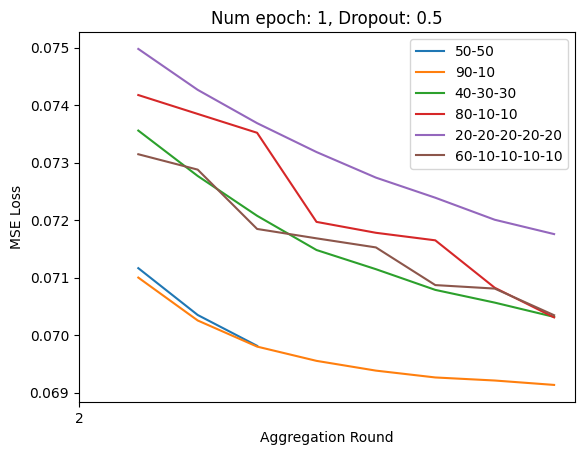

In [23]:
# 1 epoch 0.5 dropout
plot_loss([
    [(1, 0.07473871111869812), (2, 0.07247704267501831), (3, 0.07116499543190002), (4, 0.07035087049007416), (5, 0.06981468945741653)], 
    [(1, 0.07582433521747589), (2, 0.07226352766156197), (3, 0.07100121304392815), (4, 0.07025527954101562), (5, 0.06980101391673088), (6, 0.06955313310027122), (7, 0.06938346475362778), (8, 0.06926441937685013), (9, 0.06921138986945152), (10, 0.06913468986749649)], 
    [(1, 0.08203266561031342), (2, 0.07475914433598518), (3, 0.07355768978595734), (4, 0.07276830822229385), (5, 0.072075966745615), (6, 0.07148069515824318), (7, 0.07114717364311218), (8, 0.07078715786337852), (9, 0.070566076785326), (10, 0.07031752169132233)], 
    [(1, 0.2253989353775978), (2, 0.07565091550350189), (3, 0.07417555153369904), (4, 0.07384692877531052), (5, 0.07351930066943169), (6, 0.07196979597210884), (7, 0.07178014144301414), (8, 0.07164905592799187), (9, 0.07082487642765045), (10, 0.07030904293060303)], 
    [(1, 0.15486642718315125), (2, 0.08167275413870811), (3, 0.074977558106184), (4, 0.07426590844988823), (5, 0.07368658483028412), (6, 0.07318436726927757), (7, 0.0727396234869957), (8, 0.07238989323377609), (9, 0.07200703397393227), (10, 0.07175756990909576)], 
    [(1, 0.20795512199401855), (2, 0.07665058597922325), (3, 0.07314610853791237), (4, 0.0728784091770649), (5, 0.07184692844748497), (6, 0.07168373838067055), (7, 0.07152580469846725), (8, 0.07087073102593422), (9, 0.07081002742052078), (10, 0.07034676522016525)]
  ], start=2, title='Num epoch: 1, Dropout: 0.5')

aucs = [0.7250858045178113,
0.7376749140047716,
0.7153597829442762,
0.7155416579507705,
0.6797073241072182,
0.7142690629736775]

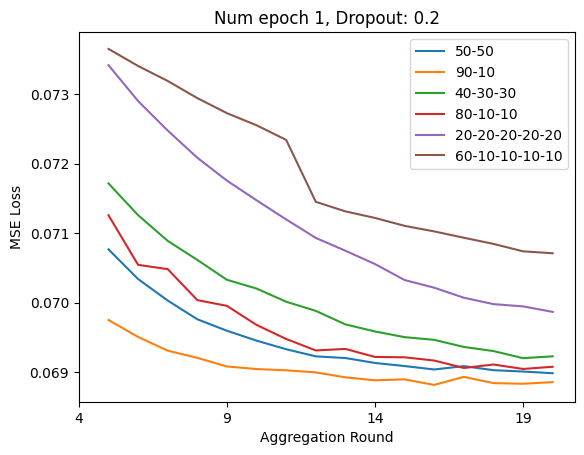

In [29]:
# 1 epoch 0.2 dropout
plot_loss([[(1, 0.07545275613665581), (2, 0.07329028844833374), (3, 0.07212255895137787), (4, 0.07133831456303596), (5, 0.07076610252261162), (6, 0.07033850252628326), (7, 0.07002967223525047), (8, 0.06976005807518959), (9, 0.06959566101431847), (10, 0.06945336610078812), (11, 0.06932969018816948), (12, 0.06922724097967148), (13, 0.06920316815376282), (14, 0.0691322423517704), (15, 0.06908798962831497), (16, 0.06903870776295662), (17, 0.06908658891916275), (18, 0.06902851909399033), (19, 0.06900925934314728), (20, 0.06898467987775803)]
, [(1, 0.075750682502985), (2, 0.07213066145777702), (3, 0.07090219855308533), (4, 0.07018472254276276), (5, 0.06975072994828224), (6, 0.06950638070702553), (7, 0.0693095251917839), (8, 0.0692058652639389), (9, 0.06908183172345161), (10, 0.06904499977827072), (11, 0.06902654841542244), (12, 0.06899667903780937), (13, 0.06892572343349457), (14, 0.0688827708363533), (15, 0.06889671087265015), (16, 0.06881655007600784), (17, 0.06893255561590195), (18, 0.06884286925196648), (19, 0.06883320584893227), (20, 0.06885694712400436)]
, [(1, 0.08101050183176994), (2, 0.07402680441737175), (3, 0.0730895847082138), (4, 0.0722985751926899), (5, 0.07171355187892914), (6, 0.07125730812549591), (7, 0.0708877369761467), (8, 0.07061412930488586), (9, 0.07032782584428787), (10, 0.07020208239555359), (11, 0.07001287117600441), (12, 0.06988152489066124), (13, 0.0696868970990181), (14, 0.06958519294857979), (15, 0.06950348988175392), (16, 0.06946457549929619), (17, 0.06936254724860191), (18, 0.0693034864962101), (19, 0.06920140236616135), (20, 0.06922774389386177)]
, [(1, 0.20540422946214676), (2, 0.15332836657762527), (3, 0.07443056628108025), (4, 0.07234556972980499), (5, 0.07125681638717651), (6, 0.07054312899708748), (7, 0.07048157602548599), (8, 0.07003609463572502), (9, 0.06995333358645439), (10, 0.06967933103442192), (11, 0.0694773979485035), (12, 0.06931235641241074), (13, 0.06933406367897987), (14, 0.06921892613172531), (15, 0.06921378523111343), (16, 0.06916709244251251), (17, 0.06906034052371979), (18, 0.06911010295152664), (19, 0.06904600188136101), (20, 0.06907786056399345)]
, [(1, 0.15295878797769547), (2, 0.08181584626436234), (3, 0.07475320994853973), (4, 0.07399147003889084), (5, 0.07341429591178894), (6, 0.07289788872003555), (7, 0.0724736712872982), (8, 0.07208315283060074), (9, 0.07175369188189507), (10, 0.07147133350372314), (11, 0.07119614630937576), (12, 0.07093028724193573), (13, 0.07074620574712753), (14, 0.07055456936359406), (15, 0.07032451778650284), (16, 0.07021444290876389), (17, 0.07007037848234177), (18, 0.06997828930616379), (19, 0.06994595378637314), (20, 0.06986651569604874)]
, [(1, 0.20536179095506668), (2, 0.15806488692760468), (3, 0.10802223533391953), (4, 0.08137354999780655), (5, 0.07364803552627563), (6, 0.0734025314450264), (7, 0.07318723946809769), (8, 0.07294043898582458), (9, 0.07272428274154663), (10, 0.07254999876022339), (11, 0.0723397359251976), (12, 0.07144946604967117), (13, 0.07131204754114151), (14, 0.0712176188826561), (15, 0.07110370695590973), (16, 0.07102374732494354), (17, 0.0709327682852745), (18, 0.07084456086158752), (19, 0.07073727250099182), (20, 0.07070983946323395)]]
, start=4, title='Num epoch 1, Dropout: 0.2')

aucs = [0.739821222382467,
0.7439393286618805,
0.7362209689598581,
0.7392552250687133,
0.7260512516641446,
0.707612789575986]

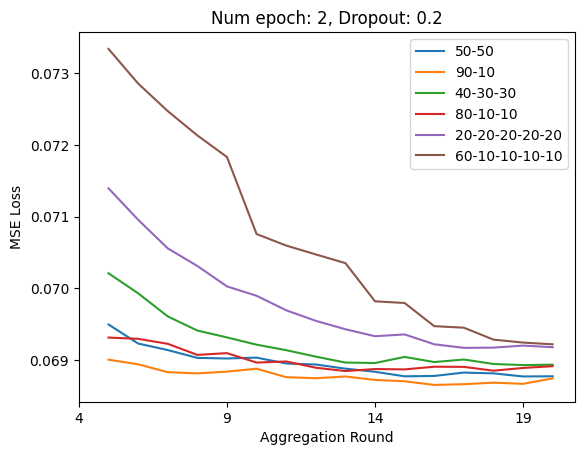

In [31]:
# 2 epoch 0.2 dropout
plot_loss([[(1, 0.0738425962626934), (2, 0.0715833455324173), (3, 0.07045447453856468), (4, 0.06985237821936607), (5, 0.06949759647250175), (6, 0.0692320242524147), (7, 0.0691409483551979), (8, 0.06903195381164551), (9, 0.06902368739247322), (10, 0.06903555244207382), (11, 0.06895386055111885), (12, 0.06893958896398544), (13, 0.06888193637132645), (14, 0.06883856281638145), (15, 0.06877480819821358), (16, 0.06878027319908142), (17, 0.06882721930742264), (18, 0.0688161700963974), (19, 0.06877307593822479), (20, 0.06877562776207924)]
, [(1, 0.07308613881468773), (2, 0.07026134431362152), (3, 0.06943010538816452), (4, 0.06908725202083588), (5, 0.06900657713413239), (6, 0.06894300132989883), (7, 0.06883270293474197), (8, 0.06881563365459442), (9, 0.06884046643972397), (10, 0.06888104975223541), (11, 0.06876330450177193), (12, 0.06874856352806091), (13, 0.06877262890338898), (14, 0.06872479245066643), (15, 0.06870613992214203), (16, 0.0686551108956337), (17, 0.06866516917943954), (18, 0.06868669390678406), (19, 0.06867043673992157), (20, 0.06874629110097885)]
, [(1, 0.07457723468542099), (2, 0.07255591452121735), (3, 0.07135896384716034), (4, 0.07061278820037842), (5, 0.07021087780594826), (6, 0.06993243470788002), (7, 0.06961000710725784), (8, 0.06941327452659607), (9, 0.06931721419095993), (10, 0.06921616196632385), (11, 0.06913937628269196), (12, 0.06904938817024231), (13, 0.06896679848432541), (14, 0.06896057724952698), (15, 0.06904517859220505), (16, 0.06897380948066711), (17, 0.06900931894779205), (18, 0.0689469501376152), (19, 0.06893149763345718), (20, 0.06893713772296906)]
, [(1, 0.07378904893994331), (2, 0.07075700163841248), (3, 0.07063474506139755), (4, 0.06965720653533936), (5, 0.06931503862142563), (6, 0.06929759681224823), (7, 0.06922806799411774), (8, 0.06907369196414948), (9, 0.06909828633069992), (10, 0.06896656006574631), (11, 0.06898191571235657), (12, 0.06889498978853226), (13, 0.06884810328483582), (14, 0.06887669861316681), (15, 0.06887148320674896), (16, 0.06890873610973358), (17, 0.06890673190355301), (18, 0.06885331124067307), (19, 0.06889176368713379), (20, 0.0689162164926529)]
, [(1, 0.07826124876737595), (2, 0.07394367456436157), (3, 0.07278285920619965), (4, 0.07200627774000168), (5, 0.07139541208744049), (6, 0.07095716148614883), (7, 0.07055852562189102), (8, 0.07031287252902985), (9, 0.07002849876880646), (10, 0.06989751011133194), (11, 0.06969574093818665), (12, 0.06954827159643173), (13, 0.06943104416131973), (14, 0.06933365017175674), (15, 0.06935910135507584), (16, 0.06922150403261185), (17, 0.0691719502210617), (18, 0.06917501986026764), (19, 0.06920325756072998), (20, 0.06918103992938995)]
, [(1, 0.14761915057897568), (2, 0.07961784675717354), (3, 0.0745721235871315), (4, 0.0739348866045475), (5, 0.07333825528621674), (6, 0.0728558599948883), (7, 0.07247190922498703), (8, 0.07213262841105461), (9, 0.07183187827467918), (10, 0.07075803726911545), (11, 0.07059774920344353), (12, 0.07047399878501892), (13, 0.07035280019044876), (14, 0.0698203481733799), (15, 0.06979703530669212), (16, 0.06947379186749458), (17, 0.06945304572582245), (18, 0.06928644329309464), (19, 0.0692451111972332), (20, 0.06922132894396782)]]
, start=4, title='Num epoch: 2, Dropout: 0.2')

aucs = [0.7435172830977153,
0.7444869194940524,
0.7409273037913621,
0.7433483773822702,
0.737271196266882,
0.7383021815221873]

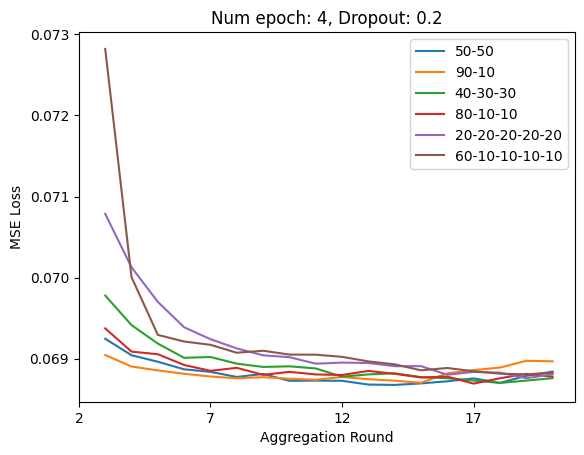

In [80]:
# 4 epoch 0.2 dropout
plot_loss([[(1, 0.07182063162326813), (2, 0.06984119862318039), (3, 0.06924623250961304), (4, 0.0690428838133812), (5, 0.06896284222602844), (6, 0.06886952370405197), (7, 0.06883780285716057), (8, 0.06877543404698372), (9, 0.06881199032068253), (10, 0.06872768327593803), (11, 0.06872963532805443), (12, 0.06872781738638878), (13, 0.0686812773346901), (14, 0.06867697462439537), (15, 0.06869559362530708), (16, 0.06872158497571945), (17, 0.06875758618116379), (18, 0.06870231032371521), (19, 0.06878893077373505), (20, 0.06884057819843292)]
, [(1, 0.0704764574766159), (2, 0.0692891925573349), (3, 0.0690455473959446), (4, 0.06890369951725006), (5, 0.06885606795549393), (6, 0.06881386414170265), (7, 0.0687807984650135), (8, 0.06875927746295929), (9, 0.06877214834094048), (10, 0.06875376775860786), (11, 0.06874030828475952), (12, 0.0687749870121479), (13, 0.06874796748161316), (14, 0.06872908398509026), (15, 0.06870315596461296), (16, 0.06881998479366302), (17, 0.06885948404669762), (18, 0.06889094039797783), (19, 0.06897404044866562), (20, 0.06896837800741196)]
, [(1, 0.07268918678164482), (2, 0.07061195001006126), (3, 0.06977921724319458), (4, 0.06941420212388039), (5, 0.06918668746948242), (6, 0.06901120394468307), (7, 0.06902112811803818), (8, 0.06893940269947052), (9, 0.06889866665005684), (10, 0.0689062811434269), (11, 0.06888017430901527), (12, 0.06877844035625458), (13, 0.06880651041865349), (14, 0.0688200294971466), (15, 0.06877262890338898), (16, 0.06876013427972794), (17, 0.06873136013746262), (18, 0.06870163977146149), (19, 0.06873038038611412), (20, 0.06876040250062943)]
, [(1, 0.07070639356970787), (2, 0.07042090222239494), (3, 0.06937384977936745), (4, 0.06908747926354408), (5, 0.06905551254749298), (6, 0.06892246007919312), (7, 0.0688510462641716), (8, 0.0688876360654831), (9, 0.06880086287856102), (10, 0.06883809342980385), (11, 0.06880620494484901), (12, 0.06879924610257149), (13, 0.06884948164224625), (14, 0.0688144713640213), (15, 0.06876912713050842), (16, 0.06877943873405457), (17, 0.06869310885667801), (18, 0.06875881925225258), (19, 0.06881309300661087), (20, 0.06877928599715233)]
, [(1, 0.0744800977408886), (2, 0.07203225418925285), (3, 0.07078596204519272), (4, 0.0701272152364254), (5, 0.06970063224434853), (6, 0.06938770413398743), (7, 0.06924083456397057), (8, 0.06912707537412643), (9, 0.06904173269867897), (10, 0.06901911273598671), (11, 0.06893870234489441), (12, 0.0689522922039032), (13, 0.06894732266664505), (14, 0.06890790164470673), (15, 0.0689086988568306), (16, 0.0688028447329998), (17, 0.0688377134501934), (18, 0.06882798671722412), (19, 0.06876017153263092), (20, 0.06880775839090347)]
, [(1, 0.07743417471647263), (2, 0.07399625331163406), (3, 0.07281960546970367), (4, 0.0700061023235321), (5, 0.06929375231266022), (6, 0.06921224668622017), (7, 0.06917158141732216), (8, 0.06907385215163231), (9, 0.06909838318824768), (10, 0.06905120238661766), (11, 0.0690496414899826), (12, 0.06902322918176651), (13, 0.06896702200174332), (14, 0.06893053278326988), (15, 0.06885756179690361), (16, 0.06888558343052864), (17, 0.06884557008743286), (18, 0.06881575658917427), (19, 0.06880715489387512), (20, 0.06882761046290398)]]
, start = 2, title = 'Num epoch: 4, Dropout: 0.2')

aucs = [0.7455065359227996,
0.7428549487079372,
0.7442621451426035,
0.7439651694948124,
0.7434802911652321,
0.7424613626854311]

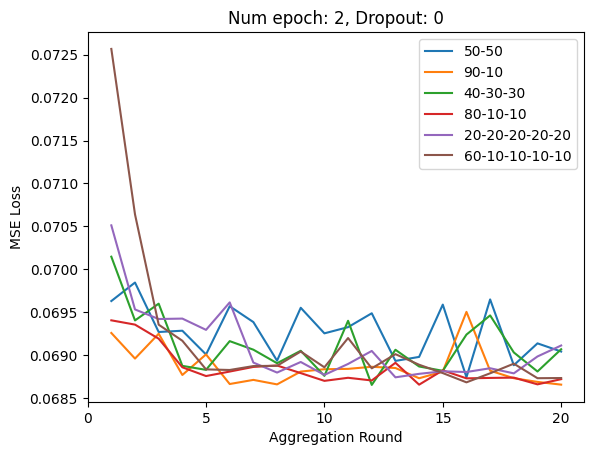

In [130]:
# 2 epoch 0 dropout high lr
plot_loss([[(1, 0.0696292594075203), (2, 0.06984472274780273), (3, 0.06926827505230904), (4, 0.06928325444459915), (5, 0.06900650262832642), (6, 0.06956859305500984), (7, 0.06938378885388374), (8, 0.06893416866660118), (9, 0.06955068930983543), (10, 0.0692526325583458), (11, 0.06932489201426506), (12, 0.0694865770637989), (13, 0.0689314492046833), (14, 0.0689779669046402), (15, 0.06958745792508125), (16, 0.06874113157391548), (17, 0.06964796036481857), (18, 0.06888121366500854), (19, 0.06913592293858528), (20, 0.06904071569442749)]
, [(1, 0.06925689801573753), (2, 0.06895871087908745), (3, 0.06924808397889137), (4, 0.06876736134290695), (5, 0.06900716945528984), (6, 0.06866206601262093), (7, 0.06871016323566437), (8, 0.06865773350000381), (9, 0.06880705058574677), (10, 0.06883441656827927), (11, 0.06883856654167175), (12, 0.06886280328035355), (13, 0.06884864717721939), (14, 0.06872911751270294), (15, 0.06880710273981094), (16, 0.06950286030769348), (17, 0.06881711632013321), (18, 0.06872978061437607), (19, 0.06868652999401093), (20, 0.06865480542182922)]
, [(1, 0.07014602050185204), (2, 0.06940315663814545), (3, 0.06959862634539604), (4, 0.06887362897396088), (5, 0.06882702559232712), (6, 0.06916185468435287), (7, 0.06906217709183693), (8, 0.06890446320176125), (9, 0.06904935836791992), (10, 0.06875720992684364), (11, 0.06939896941184998), (12, 0.0686514787375927), (13, 0.06906114891171455), (14, 0.06886628642678261), (15, 0.068816177546978), (16, 0.06923818215727806), (17, 0.06946153566241264), (18, 0.0690300427377224), (19, 0.06880797818303108), (20, 0.06906748935580254)]
, [(1, 0.06940435245633125), (2, 0.06935438141226768), (3, 0.06919021531939507), (4, 0.06885704398155212), (5, 0.06875493749976158), (6, 0.06880729645490646), (7, 0.0688614621758461), (8, 0.06887774541974068), (9, 0.06878915801644325), (10, 0.06869883090257645), (11, 0.06873466819524765), (12, 0.06870346888899803), (13, 0.06890935078263283), (14, 0.06865448877215385), (15, 0.0688212402164936), (16, 0.06872805953025818), (17, 0.06873311847448349), (18, 0.06873650848865509), (19, 0.06865820661187172), (20, 0.06871866434812546)]
, [(1, 0.0705113485455513), (2, 0.0695311389863491), (3, 0.06941961497068405), (4, 0.06942455098032951), (5, 0.06929324939846992), (6, 0.06961321085691452), (7, 0.0689118467271328), (8, 0.06879555433988571), (9, 0.06891880556941032), (10, 0.06876832619309425), (11, 0.06889602541923523), (12, 0.06904744356870651), (13, 0.06873999163508415), (14, 0.06878067180514336), (15, 0.06881018355488777), (16, 0.06880196556448936), (17, 0.06884578615427017), (18, 0.06878627836704254), (19, 0.06898311525583267), (20, 0.06911098212003708)]
, [(1, 0.07256767898797989), (2, 0.07063934206962585), (3, 0.0693536140024662), (4, 0.0691661387681961), (5, 0.06883256509900093), (6, 0.06882558763027191), (7, 0.06887109950184822), (8, 0.06887463107705116), (9, 0.06904087960720062), (10, 0.06885700672864914), (11, 0.06919792667031288), (12, 0.06884469464421272), (13, 0.0690101906657219), (14, 0.06888673081994057), (15, 0.06878947839140892), (16, 0.06868152320384979), (17, 0.06878704205155373), (18, 0.06889918074011803), (19, 0.06872984394431114), (20, 0.06873169541358948)]]
, start = 0, title = 'Num epoch: 2, Dropout: 0')

aucs = [0.7462887147807837,
0.7439802277112039,
0.7463867552001598,
0.7446719888749205,
0.7418552326416233,
0.7448910005852587]

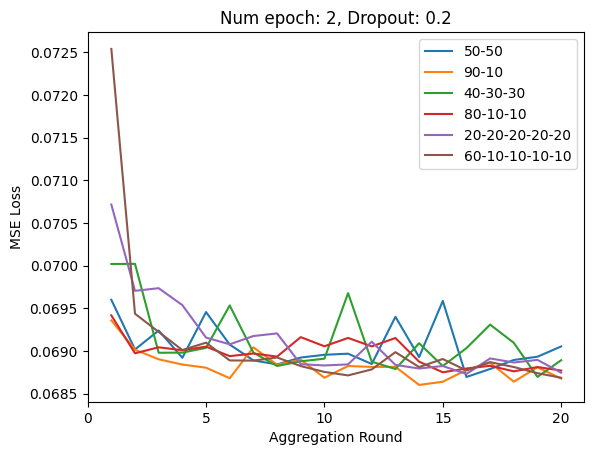

In [21]:
# 2 epoch 0.2 dropout high lr
plot_loss([[(1, 0.06960000097751617), (2, 0.06901741772890091), (3, 0.06923962756991386), (4, 0.0689200647175312), (5, 0.06945588067173958), (6, 0.06907495483756065), (7, 0.06888962909579277), (8, 0.06884187459945679), (9, 0.0689227245748043), (10, 0.06895512714982033), (11, 0.06896794587373734), (12, 0.06884750723838806), (13, 0.06940018013119698), (14, 0.0689280703663826), (15, 0.06958625465631485), (16, 0.06869503110647202), (17, 0.06878883764147758), (18, 0.06889431178569794), (19, 0.06893256679177284), (20, 0.06905309110879898)]
, [(1, 0.06935819238424301), (2, 0.06901456415653229), (3, 0.06890231743454933), (4, 0.0688408762216568), (5, 0.06880392134189606), (6, 0.06868019700050354), (7, 0.06904244422912598), (8, 0.06883866339921951), (9, 0.06889740377664566), (10, 0.06868627294898033), (11, 0.06882364675402641), (12, 0.06881307065486908), (13, 0.0688134953379631), (14, 0.06860192120075226), (15, 0.068638876080513), (16, 0.06877820193767548), (17, 0.06886183097958565), (18, 0.0686398521065712), (19, 0.06880871579051018), (20, 0.06867573037743568)]
, [(1, 0.07001930475234985), (2, 0.070020891726017), (3, 0.06897873431444168), (4, 0.0689806118607521), (5, 0.06903624534606934), (6, 0.069533821195364), (7, 0.06898080930113792), (8, 0.06882381811738014), (9, 0.06887868046760559), (10, 0.0689094215631485), (11, 0.06967797502875328), (12, 0.06887407973408699), (13, 0.06878840178251266), (14, 0.06909054517745972), (15, 0.06882332637906075), (16, 0.06903349608182907), (17, 0.06930890306830406), (18, 0.06909511238336563), (19, 0.06869560480117798), (20, 0.06889160722494125)]
, [(1, 0.06941679492592812), (2, 0.06897272914648056), (3, 0.06904304027557373), (4, 0.06900815665721893), (5, 0.06905075162649155), (6, 0.06893941760063171), (7, 0.0689699649810791), (8, 0.06893399357795715), (9, 0.0691620483994484), (10, 0.06905501335859299), (11, 0.06915271282196045), (12, 0.069053515791893), (13, 0.06915181130170822), (14, 0.06887482106685638), (15, 0.06875012069940567), (16, 0.06879431009292603), (17, 0.06882598251104355), (18, 0.06876110285520554), (19, 0.06881169974803925), (20, 0.06877046078443527)]
, [(1, 0.07071609050035477), (2, 0.06970477849245071), (3, 0.06973564997315407), (4, 0.06953737884759903), (5, 0.06915692985057831), (6, 0.06907784938812256), (7, 0.06917495653033257), (8, 0.06920583173632622), (9, 0.06884535402059555), (10, 0.0688299797475338), (11, 0.06884253025054932), (12, 0.06910882517695427), (13, 0.06883613392710686), (14, 0.06879440695047379), (15, 0.06882357597351074), (16, 0.06873004138469696), (17, 0.06891247630119324), (18, 0.06886466592550278), (19, 0.06889528781175613), (20, 0.0687454342842102)]
, [(1, 0.0725400522351265), (2, 0.06943624839186668), (3, 0.06922292709350586), (4, 0.06901092827320099), (5, 0.0690971352159977), (6, 0.06888903304934502), (7, 0.06888668984174728), (8, 0.06892320513725281), (9, 0.06882268935441971), (10, 0.06875424459576607), (11, 0.06871344149112701), (12, 0.06878362596035004), (13, 0.06898600980639458), (14, 0.06881126761436462), (15, 0.0689057745039463), (16, 0.06877100467681885), (17, 0.06886903941631317), (18, 0.06881176680326462), (19, 0.06873974949121475), (20, 0.06868593022227287)]]
, start = 0, title = 'Num epoch: 2, Dropout: 0.2')

aucs = [0.7462605185634106,
0.7434262851780735,
0.7442342373280199,
0.7428900517731398,
0.74367866497715,
0.7444733731124413]